In [42]:
prediction_year = 2022
SAVE_PREDICTIONS = True
INCLUDE_COUNTRY_ID = True
INCLUDE_MONTH_ID = True
DROP_0_ROWS_PERCENT = 20
DROP_35_LEAST_IMPORTANT = False
SAVE_FIGURES = True

In [43]:
import pandas as pd

cm_features_version = '2.4'
cm_features = pd.read_csv(f'../data/cm_features_v{cm_features_version}_Y{prediction_year}.csv')

cm_features

month_id  country_id  gleditsch_ward  ged_sb  ged_ns  ged_os  acled_sb  \
0           121           1           110.0     0.0     0.0     0.0       0.0   
1           121           2           115.0     0.0     0.0     0.0       0.0   
2           121           3            52.0     0.0     0.0     0.0       0.0   
3           121           4           101.0     0.0     0.0    12.0       0.0   
4           121           7           160.0     0.0     0.0     0.0       0.0   
...         ...         ...             ...     ...     ...     ...       ...   
62865       502         242           510.0     0.0     0.0     1.0       0.0   
62866       502         243           600.0     0.0     0.0     0.0       2.0   
62867       502         244           435.0     0.0     0.0     0.0       0.0   
62868       502         245           625.0     0.0    11.0     9.0       2.0   
62869       502         246           626.0     2.0    62.0     0.0       0.0   

       acled_sb_count  acled_os  ged_sb_tsum_24  ...  \
0                 0.0       0.0             0.0  ...   
1                 0.0       0.0             0.0  ...   
2                 0.0       0.0             0.0  ...   
3                 0.0       0.0             0.0  ...   
4                 0.0       0.0             0.0  ...   
...               ...       ...             ...  ...   
62865             0.0       2.0            30.0  ...   
62866             2.0       0.0             5.0  ...   
62867             0.0       0.0             0.0  ...   
62868             1.0      42.0            79.0  ...   
62869             9.0      26.0           191.0  ...   

       region23_Northern Europe  region23_South America  \
0                           0.0                     1.0   
1                           0.0                     1.0   
2                           0.0                     0.0   
3                           0.0                     1.0   
4                           0.0                     1.0   
...                         ...                     ...   
62865                       0.0                     0.0   
62866                       0.0                     0.0   
62867                       0.0                     0.0   
62868                       0.0                     0.0   
62869                       0.0                     0.0   

       region23_South-Eastern Asia  region23_Southern Africa  \
0                              0.0                       0.0   
1                              0.0                       0.0   
2                              0.0                       0.0   
3                              0.0                       0.0   
4                              0.0                       0.0   
...                            ...                       ...   
62865                          0.0                       0.0   
62866                          0.0                       0.0   
62867                          0.0                       0.0   
62868                          0.0                       0.0   
62869                          0.0                       0.0   

       region23_Southern Asia  region23_Southern Europe  \
0                         0.0                       0.0   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                       0.0   
...                       ...                       ...   
62865                     0.0                       0.0   
62866                     0.0                       0.0   
62867                     0.0                       0.0   
62868                     0.0                       0.0   
62869                     0.0                       0.0   

       region23_Western Africa  region23_Western Asia  \
0                          0.0                    0.0   
1                          0.0                    0.0   
2  

In [44]:
from utilities import views_month_id_to_date

# load benchmark model

model_names = {
    "bootstrap": "bm_cm_bootstrap_expanded_",
    "poisson": "bm_cm_last_historical_poisson_expanded_",
}
benchmark_model = pd.read_parquet(f'../benchmarks/{model_names["poisson"]}{prediction_year}.parquet')
# Group by 'month_id' and 'country_id' and calculate mean and std for each group
agg_funcs = {
    'outcome': ['mean', 'std']  # Assuming 'prediction' is the column to aggregate; adjust if necessary
}
# there is 20 draws per each country per each month. Get the mean of the draws and std for each month
benchmark_model = benchmark_model.groupby(['month_id', 'country_id']).agg(agg_funcs).reset_index()
# Flatten the multi-level columns resulting from aggregation
benchmark_model.columns = ['_'.join(col).strip() if col[1] else col[0] for col in benchmark_model.columns.values]
# Rename columns
benchmark_model.rename(columns={'outcome_mean': 'outcome', 'outcome_std': 'outcome_std'}, inplace=True)

# add date column
benchmark_model['date'] = views_month_id_to_date(benchmark_model['month_id'])
print(benchmark_model['month_id'].unique())
# benchmark_model

[493 494 495 496 497 498 499 500 501 502 503 504]


In [45]:
# load actuals
actuals_model = pd.read_parquet(f'../actuals/cm/window=Y{prediction_year}/cm_actuals_{prediction_year}.parquet')
actuals_model.reset_index(drop=False, inplace=True)
# actuals_model = actuals_model.groupby(['month_id', 'country_id']).mean().reset_index()
actuals_model['date'] = views_month_id_to_date(actuals_model['month_id'])
print(actuals_model['month_id'].unique())
# rename outcome to ged_sb
actuals_model.rename(columns={'outcome': 'ged_sb'}, inplace=True)
# actuals_model

[505 506 507 508 509 510 511 512 513 514 515 516]


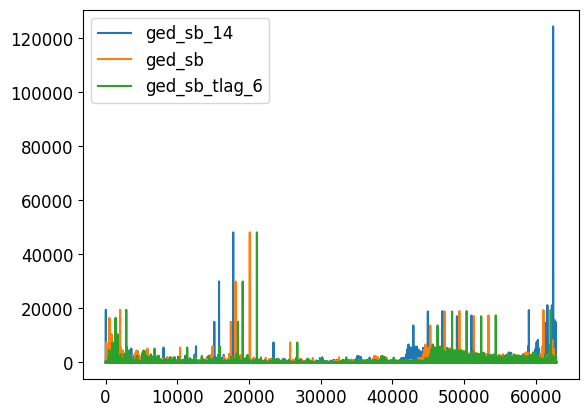

In [46]:
# get all rows that have ged_sb_y_ in the name
all_targets = [col for col in cm_features.columns if col.startswith('ged_sb_y_')]
prediction_window = 14
target = f'ged_sb_{prediction_window}'
try:
    all_targets.remove(target)
except ValueError:
    pass
cm_features.drop(columns=all_targets, inplace=True)
cm_features = cm_features.dropna()  # drop all rows for which ged_sb_y_15 is NAN

# plot target per month
from matplotlib import pyplot as plt

cm_features[target].plot()
cm_features['ged_sb'].plot()
cm_features['ged_sb_tlag_6'].plot()
plt.legend()
plt.show()

In [47]:
cm_features = cm_features.drop(columns=['country', 'gleditsch_ward'], errors='ignore')
# drop if exists 'year', 'ccode'
cm_features = cm_features.drop(columns=['year', 'ccode', 'region', 'region23'], errors='ignore')

LEAST_IMPORTANT_FEATURES = ['general_efficiency_t48',
                            '_wdi_sp_dyn_imrt_in',
                            'vdem_v2x_egal',
                            'vdem_v2x_partipdem',
                            'vdem_v2x_partip',
                            'vdem_v2x_libdem',
                            'dam_cap_pcap_t48',
                            'vdem_v2xdd_dd',
                            'vdem_v2x_edcomp_thick',
                            'groundwater_export_t48',
                            'wdi_sh_sta_stnt_zs',
                            'region_Middle East & North Africa',
                            'vdem_v2x_execorr',
                            'region23_Western Asia',
                            'region23_Southern Europe',
                            'region23_Northern Africa',
                            'region_Sub-Saharan Africa',
                            'region23_Caribbean',
                            'region23_Eastern Europe',
                            'region23_Eastern Africa',
                            'region23_South-Eastern Asia',
                            'region23_Middle Africa',
                            'region23_Northern Europe',
                            'region23_Western Africa',
                            'region23_Southern Africa',
                            'region23_South America',
                            'region_Latin America & Caribbean',
                            'region23_Northern America',
                            'region_North America',
                            'region23_Melanesia',
                            'region23_Eastern Asia',
                            'region23_Central Asia',
                            'region23_Central America',
                            'region_Europe & Central Asia',
                            'region23_Western Europe']
if DROP_35_LEAST_IMPORTANT:
    print("Current number of features:", len(cm_features.columns))
    cm_features = cm_features.drop(columns=LEAST_IMPORTANT_FEATURES)
    print("Number of features after dropping 35 least important:", len(cm_features.columns))


# cm_features = cm_features.drop(
#     columns=['ged_sb_tlag_2', 'ged_sb_tlag_3', 'ged_sb_tlag_4', 'ged_sb_tlag_5', 'ged_sb_tlag_1', 'ged_sb_tlag_6', ])
# # drop ged_sb, ged_ns, ged_os, acled_sb, acled_sb_ count, acled_os, ged_sb_tsum_24
# cm_features = cm_features.drop(
#     columns=['ged_sb', 'ged_ns', 'ged_os', 'acled_sb', 'acled_sb_count', 'acled_os', 'ged_sb_tsum_24', 'ged_os_tlag_1'])
# # drop splag_1_decay_ged_sb_5, splag_1_decay_ged_os_5, splag_1_decay_ged_ns_5, decay_ged_sb_5, decay_ged_os_5, decay_ged_sb_500, decay_ged_os_100, decay_ged_ns_5, decay_ged_ns_100, decay_acled_sb_5, decay_acled_os_5, decay_acled_ns_5
# cm_features = cm_features.drop(
#     columns=['splag_1_decay_ged_sb_5', 'splag_1_decay_ged_os_5', 'splag_1_decay_ged_ns_5', 'decay_ged_sb_5',
#              'decay_ged_os_5', 'decay_ged_sb_500', 'decay_ged_os_100', 'decay_ged_ns_5', 'decay_ged_ns_100',
#              'decay_acled_sb_5', 'decay_acled_os_5', 'decay_acled_ns_5', 'decay_ged_sb_100'])



In [48]:
# save first 50 rows of the dataset to a new csv file with column names
# cm_features.head(50).to_csv('data/cm_features_first_50.csv', index=True)
# cm_features.head(10)
# prepare dataset for machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

cm_features['date'] = pd.to_datetime(cm_features['date'])
cm_features['country_id'] = cm_features['country_id'].astype('category')
# cm_features

In [49]:
# One-hot encode 'country_id'
if INCLUDE_COUNTRY_ID:
    # TODO: try what changes if encode ccode
    from sklearn.preprocessing import OneHotEncoder

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit_transform(cm_features[['country_id']])
    countries_encoded = encoder.transform(cm_features[['country_id']])
    # rename the columns
    countries_encoded = pd.DataFrame(countries_encoded, columns=encoder.get_feature_names_out(['country_id']))
    countries_encoded = countries_encoded.drop(columns='country_id_1')  # drop country_id_1
    # drop na 

    # countries_encoded
    # merge the encoded features with the original dataset
    cm_features = pd.concat([cm_features, countries_encoded], axis=1)
    cm_features = cm_features.dropna()
cm_features.head(10)

month_id country_id  ged_sb  ged_ns  ged_os  acled_sb  acled_sb_count  \
0       121          1     0.0     0.0     0.0       0.0             0.0   
1       121          2     0.0     0.0     0.0       0.0             0.0   
2       121          3     0.0     0.0     0.0       0.0             0.0   
3       121          4     0.0     0.0    12.0       0.0             0.0   
4       121          7     0.0     0.0     0.0       0.0             0.0   
5       121          8     0.0     0.0     0.0       0.0             0.0   
6       121          9     0.0     0.0     0.0       0.0             0.0   
7       121         10     0.0     0.0     0.0       0.0             0.0   
8       121         11     0.0     0.0     0.0       0.0             0.0   
9       121         12     0.0     0.0     0.0       0.0             0.0   

   acled_os  ged_sb_tsum_24  wdi_sp_pop_totl  ...  country_id_235  \
0       0.0             0.0         752897.0  ...             0.0   
1       0.0             0.0         408360.0  ...             0.0   
2       0.0             0.0        1256210.0  ...             0.0   
3       0.0             0.0       19275292.0  ...             0.0   
4       0.0             0.0       32165766.0  ...             0.0   
5       0.0             0.0        6949139.0  ...             0.0   
6       0.0             0.0      148003411.0  ...             0.0   
7       0.0             0.0       13128619.0  ...             0.0   
8       0.0             0.0       10210185.0  ...             0.0   
9       0.0           150.0        3951288.0  ...             0.0   

   country_id_236  country_id_237  country_id_239  country_id_240  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   
5             0.0             0.0             0.0             0.0   
6             0.0             0.0             0.0             0.0   
7             0.0             0.0             0.0             0.0   
8             0.0             0.0             0.0             0.0   
9             0.0             0.0             0.0             0.0   

   country_id_242  country_id_243  country_id_244  country_id_245  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   
5             0.0             0.0             0.0             0.0   
6             0.0             0.0             0.0             0.0   
7             0.0             0.0             0.0             0.0   
8             0.0             0.0             0.0             0.0   
9             0.0             0.0             0.0             0.0   

   country_id_246  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0  
6             0.0  
7             0.0  
8             0.0  
9             0.0  

[10 rows x 329 columns]

In [50]:
# Split the dataset into training and test sets
# prediction_year = 2018
# test(final model evaluation): Jan 2018 - Dec 2018 (12 months)
# Nov 2016 (Nov 2016 month_id 443)    predicts Jan 2018 (Nov 2016 443+3+11=457)
# Oct 2017 (Nov 2016 month_id+11=454) predicts Dec 2018 (Oct 2017 454+3+11=468)
# train_df is until Oct 2016 inclusive 
# test_df is one year from Nov 2016 to Oct 2017 inclusive
# Note: Ideally:
# Oct 2017 454 predicts Jan 2018 457
# Oct 2017 454 predicts Feb 2018 458
# ...
# Oct 2017 454 predicts Dec 2018 468
last_month_id = cm_features['month_id'].max()
train_features_to_oct = last_month_id - 11 - 3
test_features_since_nov = last_month_id - 11
print("features_to_oct:", train_features_to_oct)
print("features_since_nov:", test_features_since_nov)

train_df = cm_features[cm_features['month_id'] <= train_features_to_oct]  # train is till 476 inclusive
# test_df is one year from Nov to Oct inclusive (479-490)
test_df = cm_features[
    (cm_features['month_id'] >= test_features_since_nov)]

features_to_oct: 488
features_since_nov: 491


In [51]:
# print(train_df['month_id'].unique())
# print(test_df['month_id'].unique())
# # count number of unique dates
# print(test_df['month_id'].nunique())

In [52]:
# count number of rows where target is 0
# drop 0 rows from train df 
if DROP_0_ROWS_PERCENT > 0:
    print(f"Initial count: {train_df[train_df[target] == 0].shape[0]}")
    indices = train_df[train_df[target] == 0].index.to_series()
    num_to_drop = int(len(indices) * DROP_0_ROWS_PERCENT / 100)
    indices_to_drop = indices.sample(n=num_to_drop, random_state=42)
    train_df = train_df.drop(indices_to_drop)
    print(f"Count after removal: {train_df[train_df[target] == 0].shape[0]}")
test_df.reset_index(drop=True, inplace=True)

Initial count: 52172
Count after removal: 41738


In [53]:
# shuffle the training set
# train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [54]:
# save date column for test_df
test_df_date = test_df['date']
train_df_date = train_df['date']
test_df_country_name = test_df['gw_statename']
train_df_country_name = train_df['gw_statename']
train_df_country_id = train_df['country_id']
test_df_country_id = test_df['country_id']
train_df_month_id = train_df['month_id']
test_df_month_id = test_df['month_id']

test_df = test_df.drop('date', axis=1)
test_df = test_df.drop("country_id", axis=1)
test_df = test_df.drop("gw_statename", axis=1)

# if CREATE_VAL_DS:
#     val_df_date = validation_df['date']
#     val_df_country_id = validation_df['country_id']
#     val_df_month_id = validation_df['month_id']
#     validation_df = validation_df.drop('date', axis=1)
#     validation_df = validation_df.drop("country_id", axis=1)
#     validation_df = validation_df.drop("gw_statename", axis=1)

train_df = train_df.drop('date', axis=1)
train_df = train_df.drop("country_id", axis=1)
train_df = train_df.drop("gw_statename", axis=1)

if not INCLUDE_MONTH_ID:
    test_df = test_df.drop('month_id', axis=1)
    train_df = train_df.drop('month_id', axis=1)
    # if CREATE_VAL_DS:
    #     validation_df = validation_df.drop('month_id', axis=1)

print(test_df_month_id.unique())
print("Difference between bechmark and test month_id:")
print(benchmark_model['month_id'].min() - test_df_month_id.max())
print(benchmark_model['month_id'].min() - test_df_month_id.min())

train_df.head(10)

[491 492 493 494 495 496 497 498 499 500 501 502]
Difference between bechmark and test month_id:
-9
2


month_id  ged_sb  ged_ns  ged_os  acled_sb  acled_sb_count  acled_os  \
0        121     0.0     0.0     0.0       0.0             0.0       0.0   
1        121     0.0     0.0     0.0       0.0             0.0       0.0   
2        121     0.0     0.0     0.0       0.0             0.0       0.0   
3        121     0.0     0.0    12.0       0.0             0.0       0.0   
5        121     0.0     0.0     0.0       0.0             0.0       0.0   
8        121     0.0     0.0     0.0       0.0             0.0       0.0   
9        121     0.0     0.0     0.0       0.0             0.0       0.0   
10       121    40.0     0.0    46.0       0.0             0.0       0.0   
11       121     0.0     0.0     0.0       0.0             0.0       0.0   
12       121     4.0     0.0     4.0       0.0             0.0       0.0   

    ged_sb_tsum_24  wdi_sp_pop_totl  ged_sb_tlag_1  ...  country_id_235  \
0              0.0         752897.0            0.0  ...             0.0   
1              0.0         408360.0            0.0  ...             0.0   
2              0.0        1256210.0            0.0  ...             0.0   
3              0.0       19275292.0            0.0  ...             0.0   
5              0.0        6949139.0            0.0  ...             0.0   
8              0.0       10210185.0            0.0  ...             0.0   
9            150.0        3951288.0            0.0  ...             0.0   
10          1867.0       21624311.0          104.0  ...             0.0   
11             0.0        3097889.0            0.0  ...             0.0   
12            86.0        8805995.0           17.0  ...             0.0   

    country_id_236  country_id_237  country_id_239  country_id_240  \
0              0.0             0.0             0.0             0.0   
1              0.0             0.0             0.0             0.0   
2              0.0             0.0             0.0             0.0   
3              0.0             0.0             0.0             0.0   
5              0.0             0.0             0.0             0.0   
8              0.0             0.0             0.0             0.0   
9              0.0             0.0             0.0             0.0   
10             0.0             0.0             0.0             0.0   
11             0.0             0.0             0.0             0.0   
12             0.0             0.0             0.0             0.0   

    country_id_242  country_id_243  country_id_244  country_id_245  \
0              0.0             0.0             0.0             0.0   
1              0.0             0.0             0.0             0.0   
2              0.0             0.0             0.0             0.0   
3              0.0             0.0             0.0             0.0   
5              0.0             0.0             0.0             0.0   
8              0.0             0.0             0.0             0.0   
9              0.0             0.0             0.0             0.0   
10             0.0             0.0             0.0             0.0   
11             0.0             0.0             0.0             0.0   
12             0.0             0.0             0.0             0.0   

    country_id_246  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
5              0.0  
8              0.0  
9              0.0  
10             0.0  
11             0.0  
12             0.0  

[10 rows x 326 columns]

In [55]:
X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

# if CREATE_VAL_DS:
#     X_val = validation_df.drop(target, axis=1)
#     y_val = validation_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

In [56]:
print('month_id' in X_train.columns)

True


In [57]:
from sklearn.tree import DecisionTreeRegressor
# Model tuning:
# https://stanfordmlgroup.github.io/ngboost/2-tuning.html#Using-sklearn-Model-Selection
from ngboost.scores import CRPScore, LogScore
from ngboost.distns import Poisson, Normal, MultivariateNormal, Gamma
from ngboost import NGBRegressor

# supress RuntimeWarning for NGBRegressor
import warnings

dist = Normal
score = CRPScore
n_estimators = 300
bs_max_depth = 5
minibatch_frac = 0.5

normal_enabled = True if dist == Normal else False
base_learner = DecisionTreeRegressor(
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=bs_max_depth,
    splitter="best",
    random_state=42,
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(f"Training NGB with {n_estimators} estimators and {score} score...")
    ngb = NGBRegressor(n_estimators=n_estimators, verbose_eval=10, Dist=Normal,
                       learning_rate=0.01,
                       Score=score,
                       random_state=42,
                       Base=base_learner,
                       minibatch_frac=minibatch_frac,
                       # col_sample=1.0,
                       early_stopping_rounds=None).fit(
        X_train, y_train,
        X_test, y_test,  # be careful with this, not to use early stopping
    )
ngb_train_predictions = ngb.predict(X_train)
ngb_predictions = ngb.predict(X_test)
ngb_predictions_dist = ngb.pred_dist(X_test)
# means and stds of the predictions
# mean, std = ngb_predictions_dist.loc, ngb_predictions_dist.scale

ngb_train_predictions = [max(0, pred) for pred in ngb_train_predictions]
ngb_predictions = [max(0, pred) for pred in ngb_predictions]
print("Done!")

# TODO: save the model 

Training NGB with 300 estimators and <class 'ngboost.scores.CRPScore'> score...
[iter 0] loss=111.4754 val_loss=216.6614 scale=512.0000 norm=69.9515
[iter 10] loss=100.4155 val_loss=207.2034 scale=512.0000 norm=67.6410
[iter 20] loss=89.7569 val_loss=197.9210 scale=512.0000 norm=65.2532
[iter 30] loss=82.8562 val_loss=188.7263 scale=512.0000 norm=63.9507
[iter 40] loss=70.2719 val_loss=179.6114 scale=512.0000 norm=61.3290
[iter 50] loss=63.0518 val_loss=170.6341 scale=512.0000 norm=61.9631
[iter 60] loss=53.5825 val_loss=161.7486 scale=512.0000 norm=60.7357
[iter 70] loss=40.5867 val_loss=154.3944 scale=256.0000 norm=30.7205
[iter 80] loss=35.8179 val_loss=148.4411 scale=256.0000 norm=31.8933
[iter 90] loss=28.9078 val_loss=144.3029 scale=256.0000 norm=33.5785
[iter 100] loss=29.9831 val_loss=140.6477 scale=128.0000 norm=18.2559
[iter 110] loss=24.7321 val_loss=138.3302 scale=64.0000 norm=9.9965
[iter 120] loss=26.8255 val_loss=136.9425 scale=64.0000 norm=10.9592
[iter 130] loss=22.057

In [58]:
import CRPS.CRPS as pscore
import numpy as np

sampled_dist = ngb_predictions_dist.sample(1000).T


def calculate_CRPS(sampled_dist, y_true, index_start, index_end):
    scores = []
    for inx, y_point in enumerate(y_true[index_start:index_end]):
        crps_score = pscore(sampled_dist[inx], y_point).compute()[0]
        scores.append(crps_score)
    return np.average(scores)


# average crps score
print(f"Average CRPS score: {calculate_CRPS(sampled_dist, y_test, 0, len(y_test))}")

Average CRPS score: 133.55528948512173


In [59]:
# map predictions to months based on the test_df
test_df['ngb_predictions'] = ngb_predictions
train_df['ngb_predictions'] = ngb_train_predictions

# add date column back to test_df and add to each date shift of 14 months
test_df['date'] = test_df_date + pd.DateOffset(months=prediction_window)
train_df['date'] = train_df_date
test_df['country_id'] = test_df_country_id
train_df['country_id'] = train_df_country_id
test_df['month_id'] = test_df_month_id
train_df['month_id'] = train_df_month_id
test_df['country_name'] = test_df_country_name
train_df['country_name'] = train_df_country_name

# test_df

In [60]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# TODO: Improve metrics and use all metrics from the VIEWS competition
# Calculate RMSE
# train_rmse = sqrt(mean_squared_error(y_train, xg_lss_pred_train))
ngb_train_rmse = sqrt(mean_squared_error(y_train, ngb_train_predictions))
ngb_test_rmse = sqrt(mean_squared_error(y_test, ngb_predictions))
all_zeros_rmse = sqrt(mean_squared_error(y_test, [0] * len(y_test)))
# actuals_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], predictions))
# benchmark_rmse = sqrt(mean_squared_error(y_test, benchmark_model['outcome']))
actuals_bench_rmse = sqrt(mean_squared_error(actuals_model['ged_sb'], benchmark_model['outcome']))

print("Cm features version:", cm_features_version)
print(f"Prediction year: {prediction_year}")
print(f"Include country_id: {INCLUDE_COUNTRY_ID}")
print(f"Include month_id: {INCLUDE_MONTH_ID}")
print(f"Drop train 0 rows: {DROP_0_ROWS_PERCENT}%")
print(f"Normal distribution: {normal_enabled}")
print(f"Number of estimators: {n_estimators}")
print(f"Score: {str(score)}")

# TODO: Improve metrics and use all metrics from the VIEWS competition
# print(f"XGB [train predictions] RMSE: {train_rmse}")
# print(f"XGB [test predictions]  RMSE YTEST VS PREDICTIONS: {rmse}")

print(f"\nNGB [train predictions] RMSE NGB: {ngb_train_rmse}")
# if CREATE_VAL_DS:
#     ngb_val_rmse = sqrt(mean_squared_error(y_val, ngb.predict(X_val)))
#     print(f"NGB [validation predictions] RMSE NGB: {ngb_val_rmse}")
print(f"NGB [test predictions]  RMSE NGB: {ngb_test_rmse}")
# print(f"RMSE YTEST VS ACTUALS: {actuals_rmse}")
# print(f"RMSE YTEST VS BENCHMARK: {benchmark_rmse}")
print(f"All Zeros: {all_zeros_rmse}")
print(f"\nBenchmark: RMSE ACTUALS VS BENCHMARK: {actuals_bench_rmse}")

Cm features version: 2.4
Prediction year: 2022
Include country_id: True
Include month_id: True
Drop train 0 rows: 20%
Normal distribution: True
Number of estimators: 300
Score: <class 'ngboost.scores.CRPScore'>

NGB [train predictions] RMSE NGB: 373.56289974719306
NGB [test predictions]  RMSE NGB: 2919.8491953666785
All Zeros: 2924.496464101202

Benchmark: RMSE ACTUALS VS BENCHMARK: 2757.448049990405


In [61]:


## SHAP plot for loc trees
feature_importance_loc = ngb.feature_importances_[0]
feature_importance_scale = ngb.feature_importances_[1]
feature_importance_loc = pd.DataFrame(feature_importance_loc, index=X_train.columns,
                                      columns=['importance']).sort_values(
    by='importance', ascending=False)
feature_importance_scale = pd.DataFrame(feature_importance_scale, index=X_train.columns,
                                        columns=['importance']).sort_values(by='importance', ascending=False)
# save as list names of 35 least important features
# feature_importance_loc.tail(35).index.tolist()
feature_importance_loc

importance
ged_sb                   0.251363
ged_sb_tlag_1            0.127533
ged_sb_tsum_24           0.086010
wdi_sl_tlf_totl_fe_zs    0.037155
ged_sb_tlag_2            0.030929
...                           ...
country_id_92            0.000000
country_id_93            0.000000
country_id_94            0.000000
country_id_3             0.000000
country_id_246           0.000000

[325 rows x 1 columns]

In [62]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(ngb, model_output=0)  # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, show=False, max_display=10)
plt.savefig(f'../figures/NGBoost_{prediction_year}_shap_values.png', dpi=300)

Afghanistan


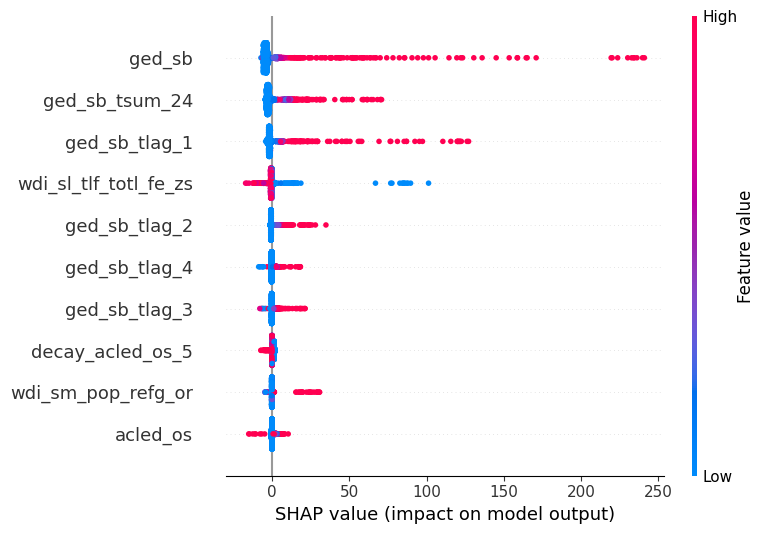

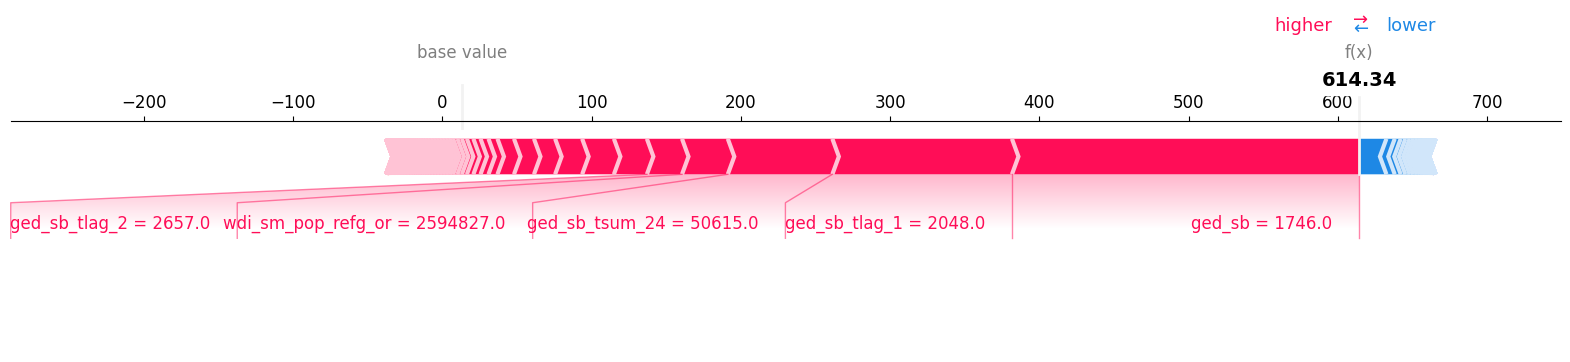

In [63]:
# filter Ethiopia

# ethiopia_test = test_df[test_df['country_id'] == 57]
# ethiopia_test_max_error_index = test_df['ngb_predictions'].idxmax()
# X_test.iloc[ethiopia_test_max_error_index][[target]]
# X_test[ethiopia_test_max_error_index:ethiopia_test_max_error_index + 1]
test_df['ngb_predictions'].idxmax()
# print country name
print(test_df.iloc[test_df['ngb_predictions'].idxmax()]['country_name'])
shap.plots.force(explainer.expected_value, shap_values[test_df['ngb_predictions'].idxmax()],
                 X_test.iloc[test_df['ngb_predictions'].idxmax()], matplotlib=True)

In [64]:
# make a force plot for a separate prediction
countries_to_force_plot = ["Ethiopia", "Turkey", "Algeria"]
for country_name in countries_to_force_plot:
    indexes_for_country = test_df[test_df['country_name'].str.contains(country_name)].index
    for m, index in enumerate(indexes_for_country, start=1):
        shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index], matplotlib=True, show=False)
        # add vectical of true value
        # plt.axvline(x=y_test.iloc[index], color='red', linestyle='--')
        plt.legend([f'Actual: {y_test.iloc[index]}'], loc='upper left')
        plt.savefig(f'../figures/force_plots/NGBoost_{prediction_year}_shap_fp_{country_name}_{m}_{index}.png', dpi=300)
        # add actual value to legend with orange color

        # plt.show()

/Users/zakotianskyi/Library/Caches/pypoetry/virtualenvs/my_project-2R0Z2sPH-py3.10/lib/python3.10/site-packages/shap/plots/_force_matplotlib.py:347: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


In [65]:
# https://stanfordmlgroup.github.io/ngboost/3-interpretation.html
# DO_IMPORTANCE = False
# # print all feature importance sorted
# feature_importance = bst.get_fscore()
# feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
# print(feature_importance)
# 
# if DO_IMPORTANCE:
#     from xgboost import plot_importance
# 
#     # plot
#     plot_importance(bst, max_num_features=10)
#     plt.show()
# 
#     import shap
# 
#     explainer = shap.TreeExplainer(bst)
#     # dtrain = xgb.DMatrix(X_train, label=y_train)
#     dtrain.feature_names = X_train.columns.tolist()
#     explanation = explainer(dtrain)
#     explanation = shap.Explanation(
#         values=explanation.values,
#         base_values=explanation.base_values,
#         data=explanation.data,
#         feature_names=X_train.columns.tolist()
#     )
#     shap.plots.beeswarm(explanation)
# 


In [66]:
PLOT_STD = True
# normal_enabled=False
if PLOT_STD:
    import numpy as np

    # dir(ngb.pred_dist(X_test).scale)
    # ngb.pred_dist(X_test).
    # save std of the predictions
    if normal_enabled:
        ngb_predictions_std = np.sqrt(ngb_predictions_dist.var)
    else:
        # sampled_dist = ngb_predictions_dist.sample(1000)
        ngb_predictions_std = sampled_dist.std(axis=0)
        ngb_predictions_max = sampled_dist.max(axis=0)
        ngb_predictions_min = sampled_dist.min(axis=0)
        test_df['ngb_predictions_max'] = ngb_predictions_max
        test_df['ngb_predictions_min'] = ngb_predictions_min

    # add std to test_df
    test_df['ngb_predictions_std'] = ngb_predictions_std


In [67]:
import matplotlib.pyplot as plt

# Assuming test_df is your DataFrame, and 'target' and 'predictions' are columns in it
unique_months = test_df['month_id'].unique()
# filter all point with actual more than 300
# test_df = test_df[test_df[target] < 300]
n_months = len(unique_months)
print("Unique months:", unique_months)

# Calculate the grid size for the subplot (simple square root approximation for a square grid)
grid_size_x = int(n_months ** 0.5) + (1 if n_months % int(n_months ** 0.5) else 0)
grid_size_y = grid_size_x + 1

# print(f'Grid size: {grid_size}')
# Set overall figure size
plt.figure(figsize=(grid_size_x * 6, grid_size_y * 3))

for index, month_id in enumerate(unique_months, start=1):
    this_month = test_df[test_df['month_id'] == month_id]
    # mean_sq_error = sqrt(mean_squared_error(this_month[target], this_month['ngb_predictions']))
    current_date = this_month["date"].iloc[0]
    target_month = this_month[target]
    predictions_month = this_month['ngb_predictions']
    # get this month max and min index
    month_start_index = this_month.index.min()
    month_end_index = this_month.index.max()
    mean_crps = calculate_CRPS(sampled_dist, y_test, month_start_index, month_end_index)

    # Create subplot for current month
    plt.subplot(grid_size_x, grid_size_y, index)
    plt.scatter(target_month, predictions_month, color='blue', label='Actual vs Predicted', alpha=0.5)

    if PLOT_STD:
        predictions_std_month = this_month['ngb_predictions_std']
        plt.errorbar(target_month, predictions_month, yerr=predictions_std_month, fmt='o', color='blue', alpha=0.5)

    # print current_date in YY/MM format
    print_date = current_date.strftime('%Y-%m')
    plt.title(f'Month: {print_date}; mean CRPS: {mean_crps:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    # plt.xscale('log')
    # plt.yscale('log')
    line_length = 2000
    # if SCALE_DATAFRAME:
    #     line_length = 1

    plt.plot([0, line_length], [0, line_length], color='red', label='45 degree line')
    plt.legend()
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
# set font size to 18
plt.rcParams.update({'font.size': 12})
plt.savefig(f'../figures/NGBoost_{prediction_year}_predictions.png', dpi=300)

Unique months: [491 492 493 494 495 496 497 498 499 500 501 502]


In [68]:
country_list = pd.read_csv('../data/country_list.csv')
# get observations with the highest error
# calculate the error
test_df['error'] = abs(test_df[target] - test_df['ngb_predictions'])
temp_df = test_df.sort_values(by='error', ascending=False)
highest_error_indices = temp_df.head(10).index
del temp_df
# highest_error_indices

# get the highest error
highest_error = test_df.nlargest(30, 'error')
# drop columns that contain 'country_id_'
highest_error = highest_error[highest_error.columns.drop(list(highest_error.filter(regex='country_id_')))]
# add country name
highest_error = highest_error.merge(country_list, on='country_id')
highest_error
# from the test_df get sorted by highest, get the first 10 


month_id  ged_sb  ged_ns  ged_os  acled_sb  acled_sb_count  acled_os  \
0        500   629.0     0.0   112.0     765.0            78.0     475.0   
1        495    26.0     0.0     0.0      18.0           399.0       1.0   
2        499    54.0     0.0   210.0     177.0            30.0     432.0   
3        501    95.0     0.0   264.0     452.0            46.0     185.0   
4        502    15.0     0.0     0.0       3.0           588.0       1.0   
5        493     8.0     0.0     0.0       4.0           349.0       0.0   
6        494    23.0     0.0     0.0      12.0           348.0       1.0   
7        496    27.0     0.0     0.0      16.0           665.0       4.0   
8        501    14.0     0.0     0.0       9.0           515.0       0.0   
9        499    18.0     0.0     0.0       7.0           544.0       0.0   
10       500    20.0     0.0     0.0      12.0           481.0       0.0   
11       498    11.0     0.0     0.0      16.0           393.0       0.0   
12       497    23.0     0.0     0.0      15.0           674.0       2.0   
13       492     8.0     0.0     0.0       6.0           297.0       0.0   
14       491   316.0    86.0     0.0    1524.0           406.0      72.0   
15       498  2668.0     0.0    67.0     263.0            14.0     193.0   
16       492  2051.0     0.0    19.0    2355.0           547.0     171.0   
17       498  7512.0     0.0    76.0    7769.0          1044.0     216.0   
18       496  2768.0     0.0    22.0    2931.0           667.0     179.0   
19       500  5163.0     0.0    32.0    5380.0           414.0     116.0   
20       497  4861.0     4.0   124.0    5550.0           907.0     354.0   
21       494  2048.0     0.0     8.0    2172.0           590.0     148.0   
22       491  2247.0     0.0    23.0    2665.0           589.0     236.0   
23       495  1746.0     0.0    28.0    1776.0           611.0     165.0   
24       493  2657.0     7.0    30.0    2439.0           623.0     161.0   
25       500   280.0     0.0    11.0     310.0           110.0      56.0   
26       501   513.0     0.0    48.0     152.0            30.0      23.0   
27       493   106.0     2.0     7.0     105.0            27.0      61.0   
28       501    34.0     0.0     1.0      67.0           105.0      46.0   
29       496  2793.0     2.0     2.0    1617.0           401.0      56.0   

    ged_sb_tsum_24  wdi_sp_pop_totl  ged_sb_tlag_1  ...  \
0          29698.0      117190911.0           54.0  ...   
1            498.0       44132049.0           23.0  ...   
2          29069.0      117190911.0         2668.0  ...   
3          29792.0      117190911.0          629.0  ...   
4            419.0       44132049.0           14.0  ...   
5            507.0       44132049.0            8.0  ...   
6            499.0       44132049.0            8.0  ...   
7            495.0       44132049.0           26.0  ...   
8            428.0       44132049.0           20.0  ...   
9            447.0       44132049.0           11.0  ...   
10           444.0       44132049.0           18.0  ...   
11           462.0       44132049.0           23.0  ...   
12           482.0       44132049.0           27.0  ...   
13           507.0       44386203.0            6.0  ...   
14          8451.0       31546691.0          743.0  ...   
15         29015.0      117190911.0          103.0  ...   
16         50429.0       37769499.0         2247.0  ...   
17         58175.0       38972230.0         4861.0  ...   
18         51349.0       38972230.0         1746.0  ...   
19         65336.0       38972230.0         8356.0  ...   
20         53423.0       38972230.0         2768.0  ...   
21         51299.0       38972230.0         2657.0  ...   
22         50799.0       37769499.0         2335.0  ...   
23         50615.0       38972230.0         2048.0  ...   
24         50948.0       38972230.0         2051.0  ...   
25          4411.0       16537016.0          222.0  ...   
26         62246.0       38972230.0         5163.0  ..

In [69]:
# get mean error for Ethiopia
ethiopia_error = test_df[test_df['country_id'] == 57]
ethiopia_error['error'].mean()

13584.068406982502

Max date in training set: 2020-08-01 00:00:00
Min date in test set: 2022-01-01 00:00:00
Expected min date in test set: 2022-01-01 00:00:00
Skipping Guyana as all actual are 0
Skipping Suriname as all actual are 0
Skipping Trinidad and Tobago as all actual are 0
Skipping Venezuela as all actual are 0
Skipping Argentina as all actual are 0
Skipping Bolivia as all actual are 0
Skipping Brazil as all actual are 0
Skipping Chile as all actual are 0
Skipping Ecuador as all actual are 0
Skipping Paraguay as all actual are 0
Skipping Uruguay as all actual are 0
Skipping Guatemala as all actual are 0
Skipping Mexico as all actual are 0
Skipping Barbados as all actual are 0
Skipping Dominican Republic as all actual are 0
Skipping Haiti as all actual are 0
Skipping Jamaica as all actual are 0
Skipping Costa Rica as all actual are 0
Skipping Cuba as all actual are 0
Skipping El Salvador as all actual are 0
Skipping Honduras as all actual are 0
Skipping Nicaragua as all actual are 0
Skipping Panama

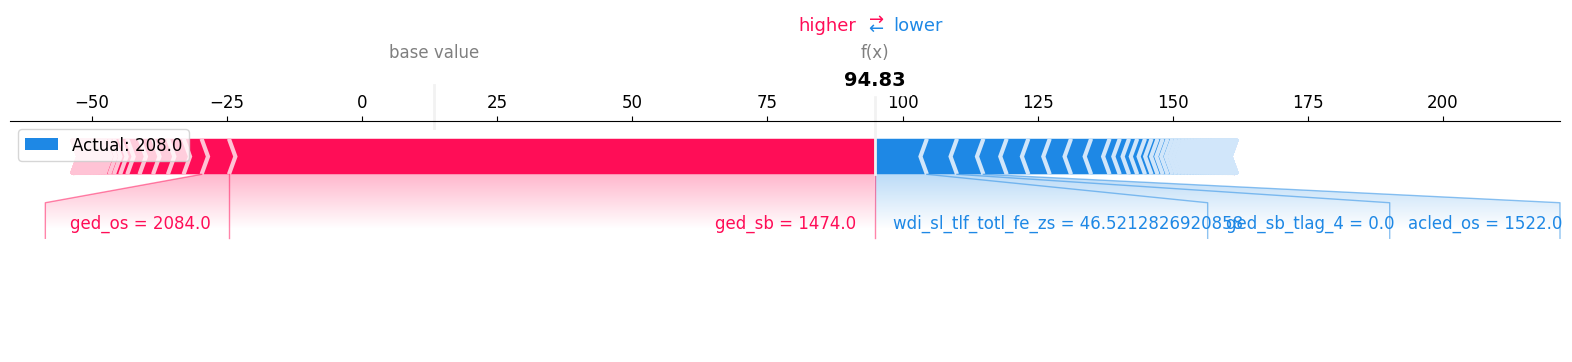

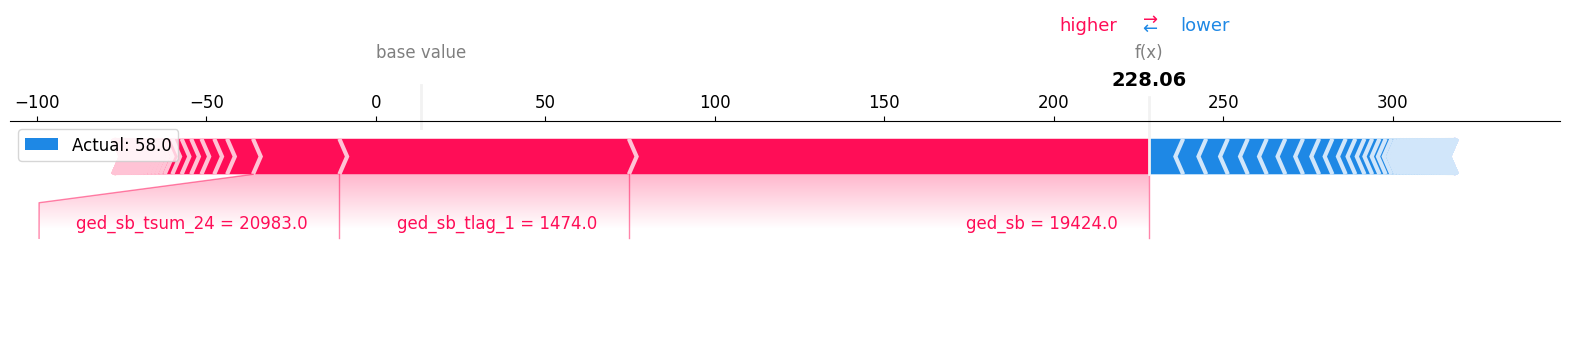

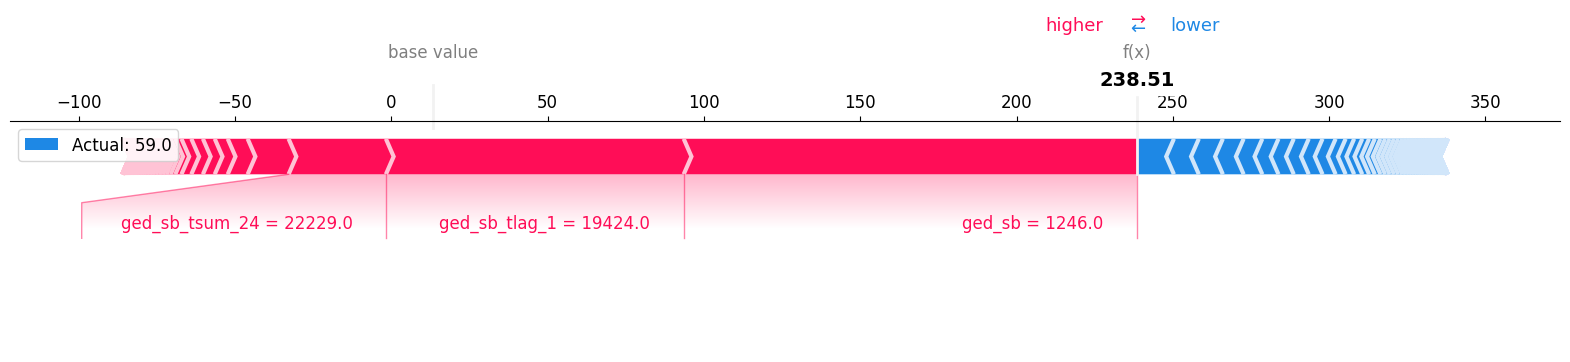

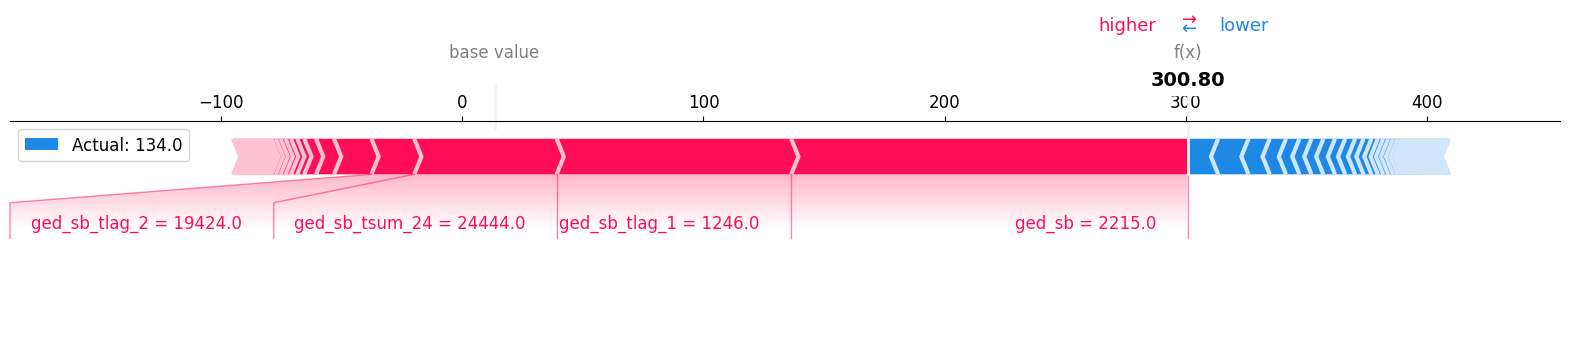

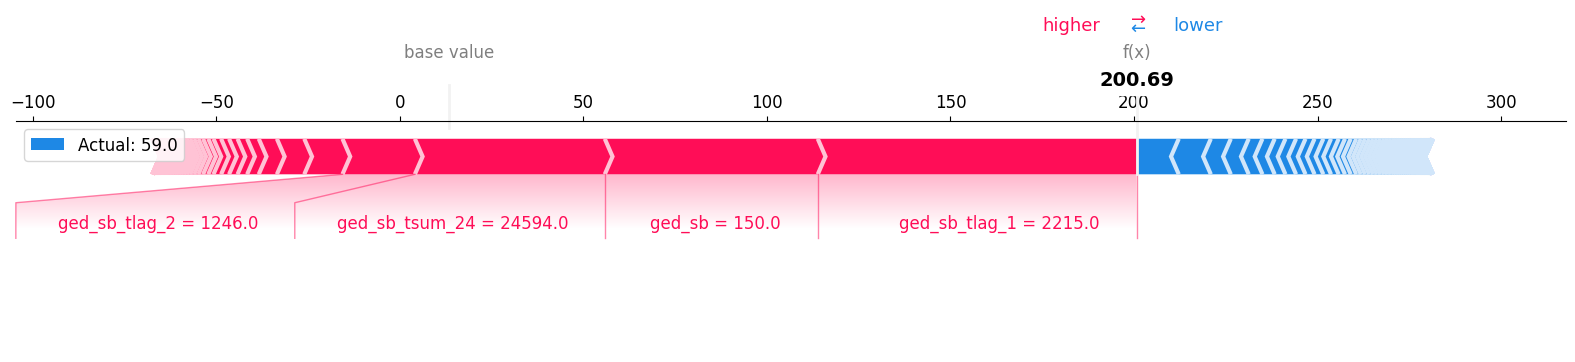

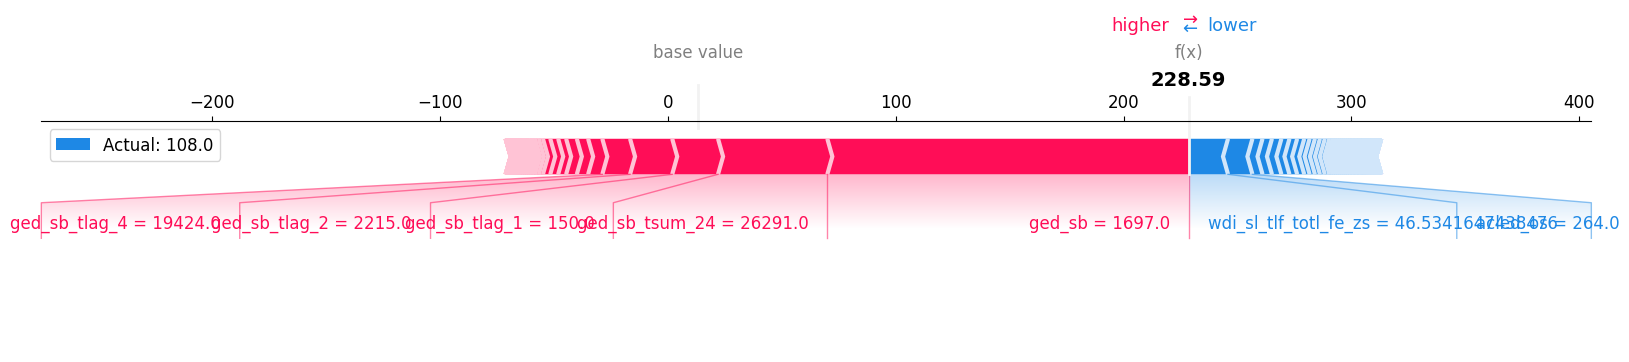

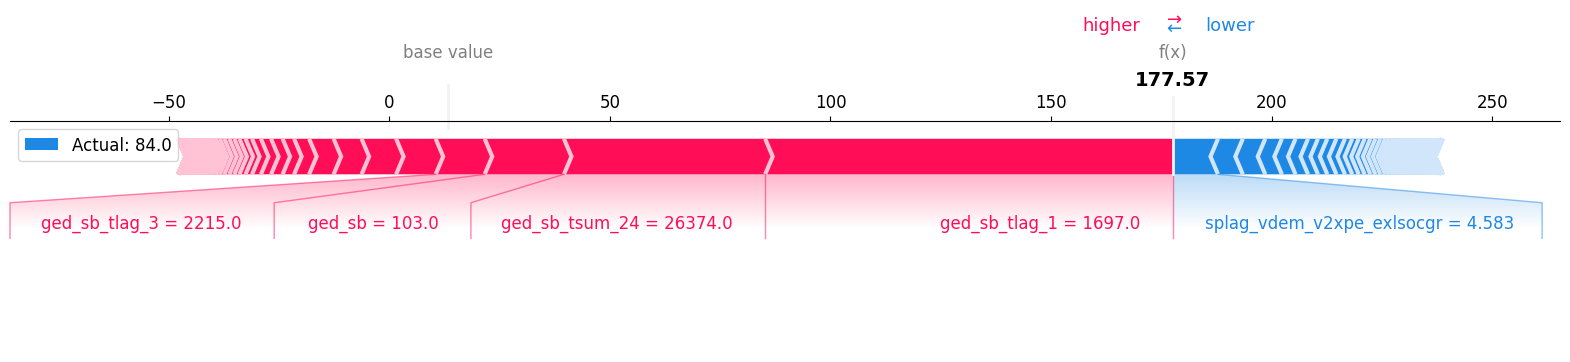

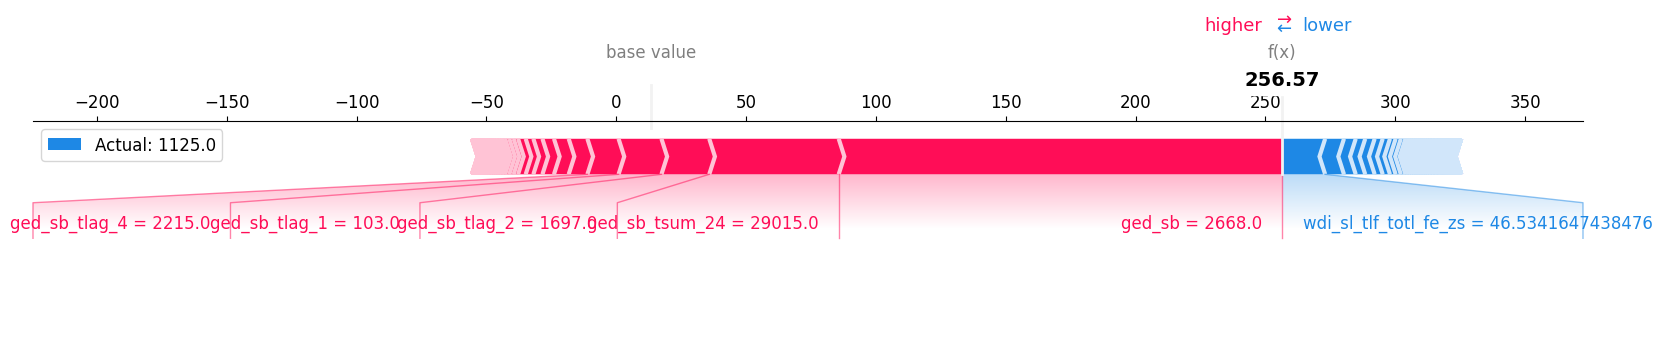

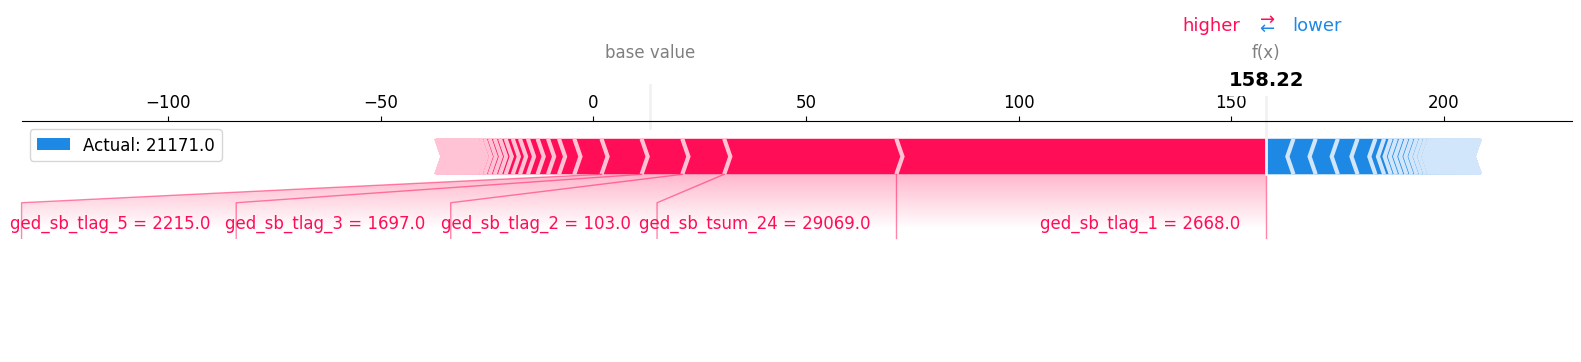

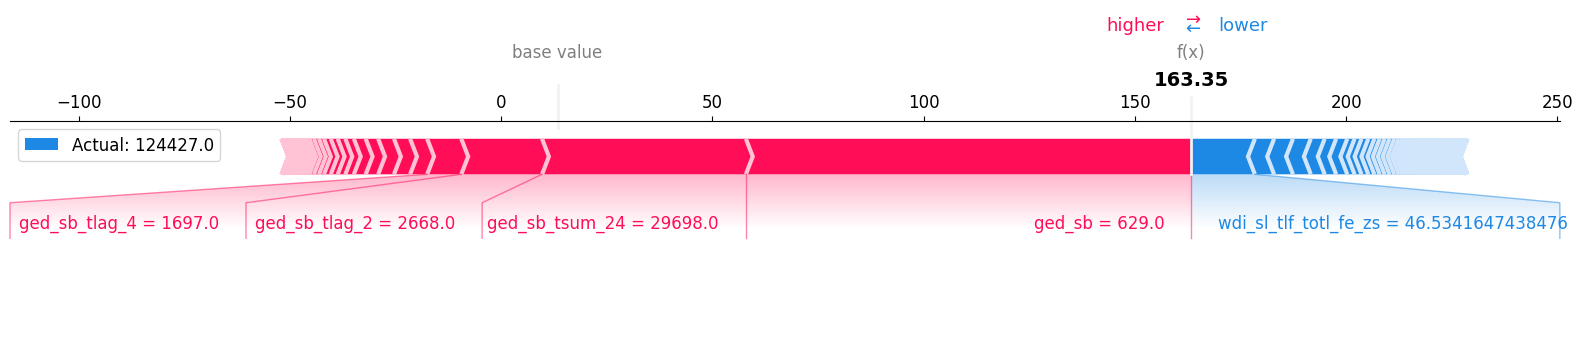

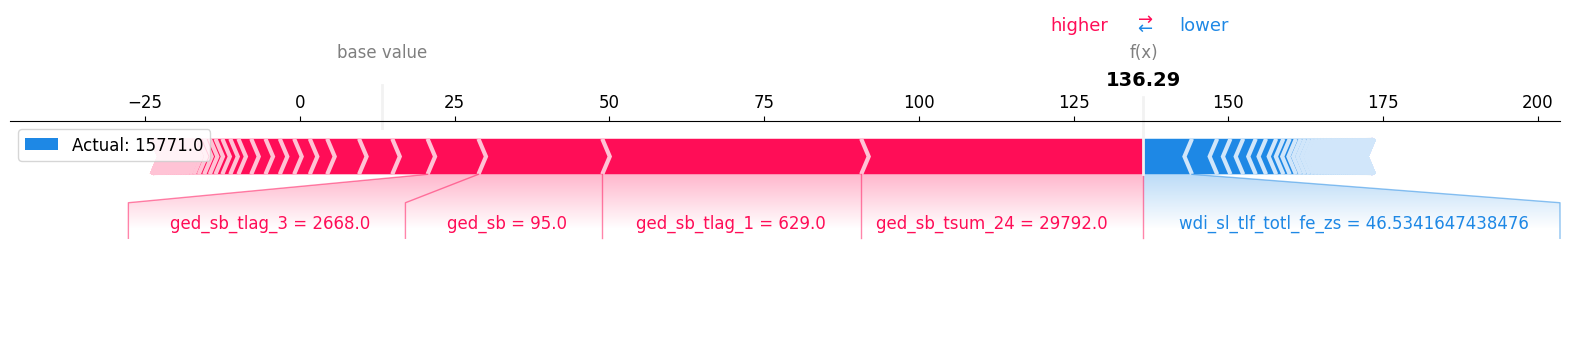

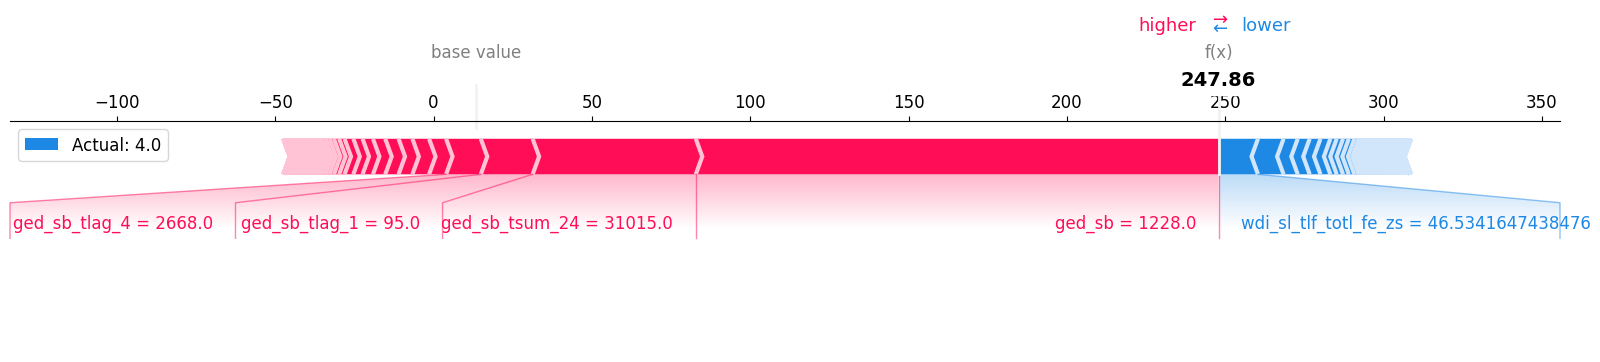

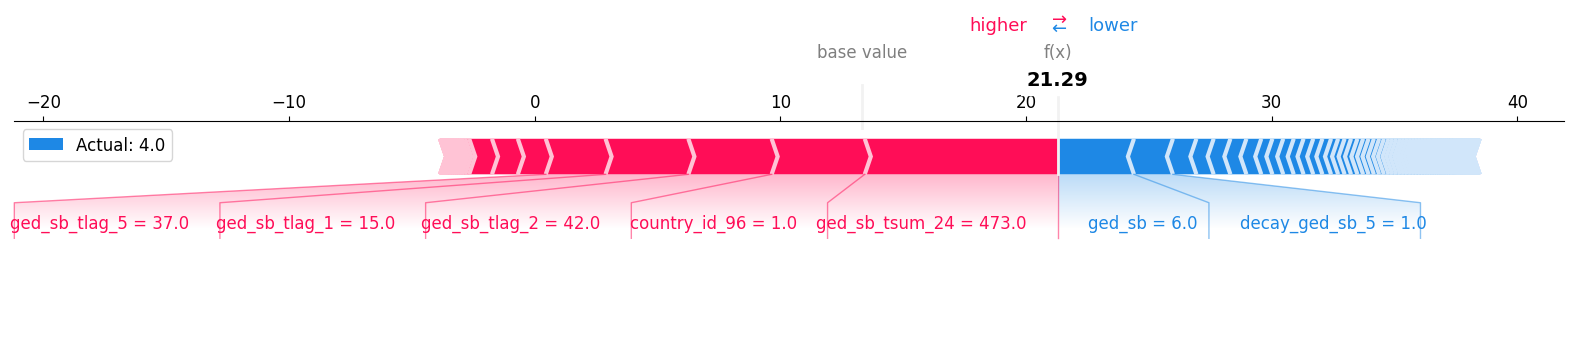

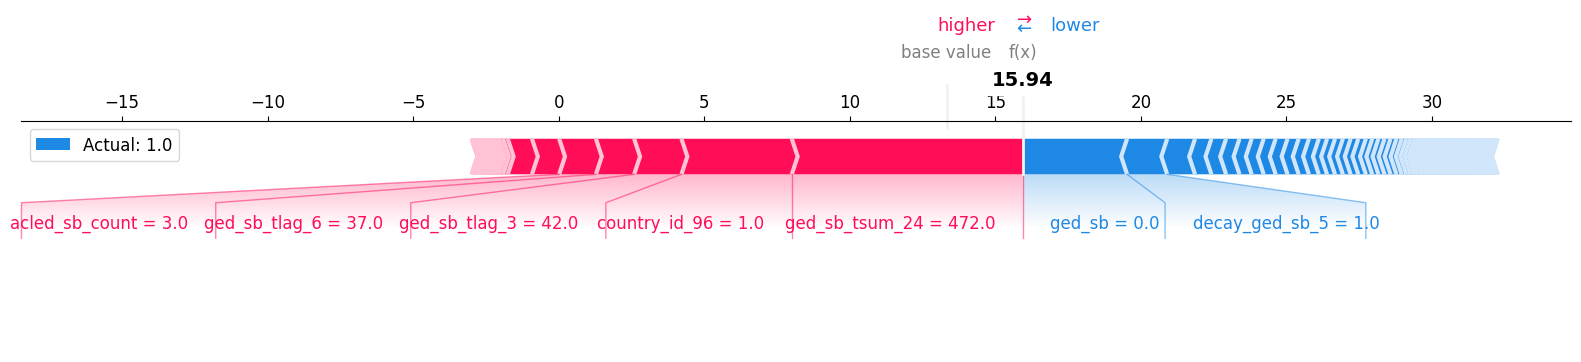

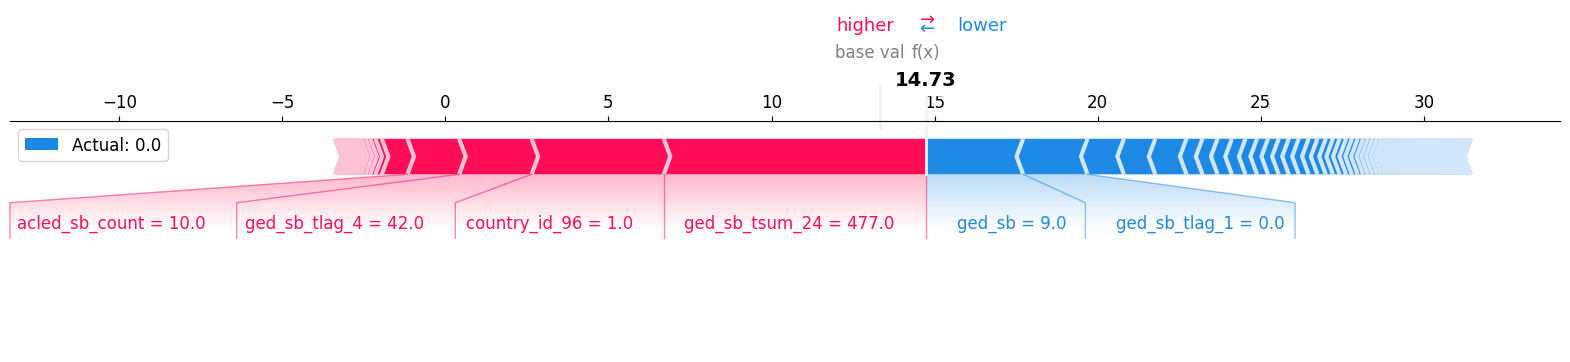

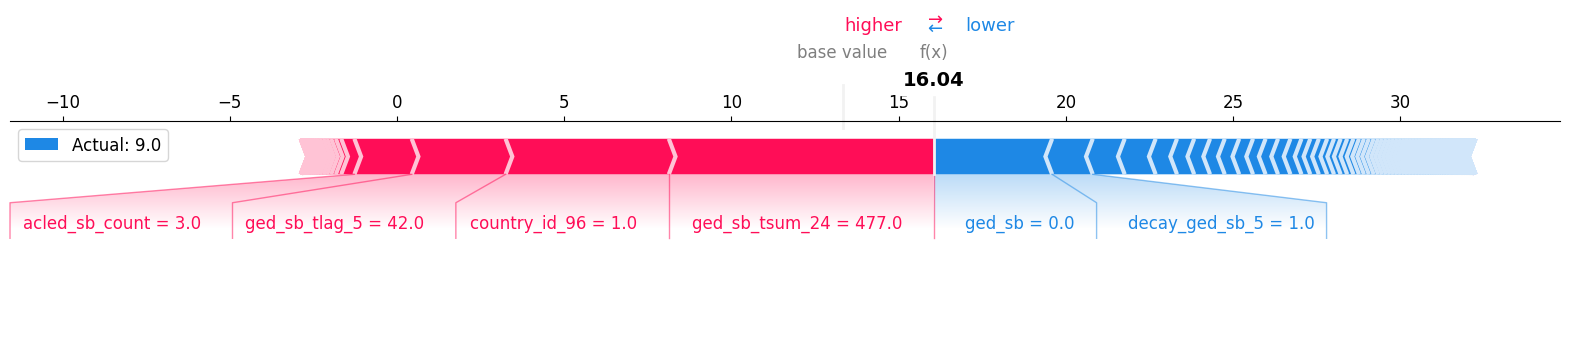

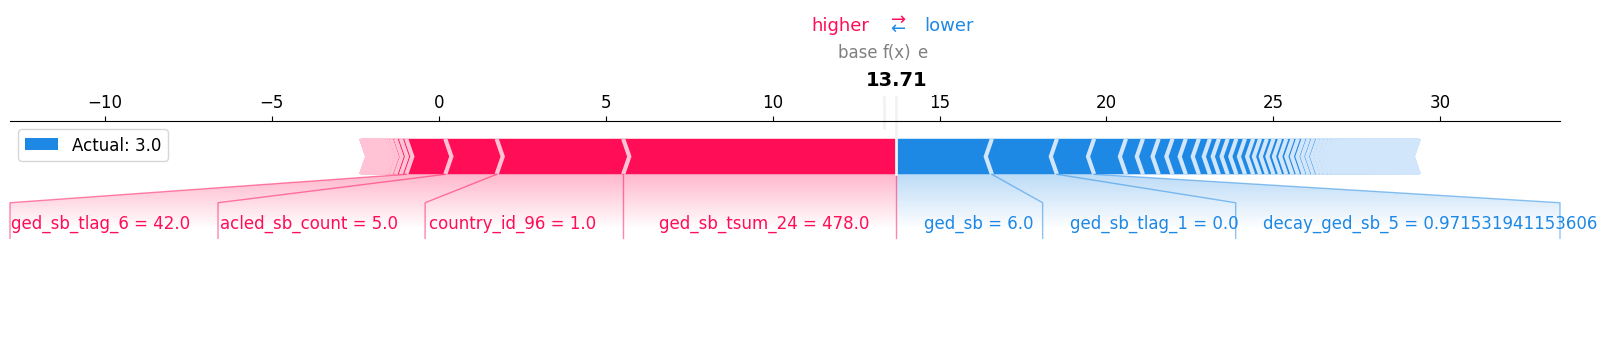

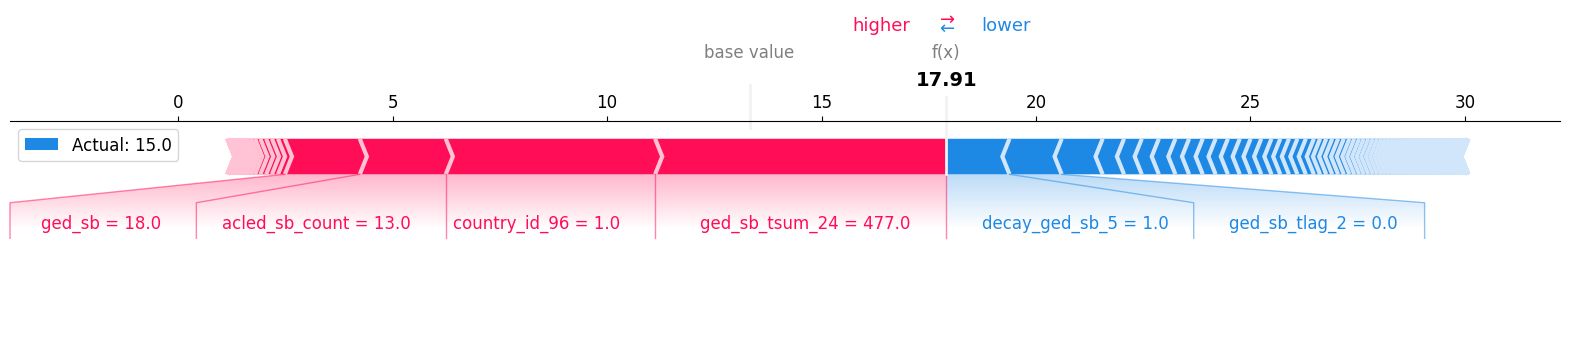

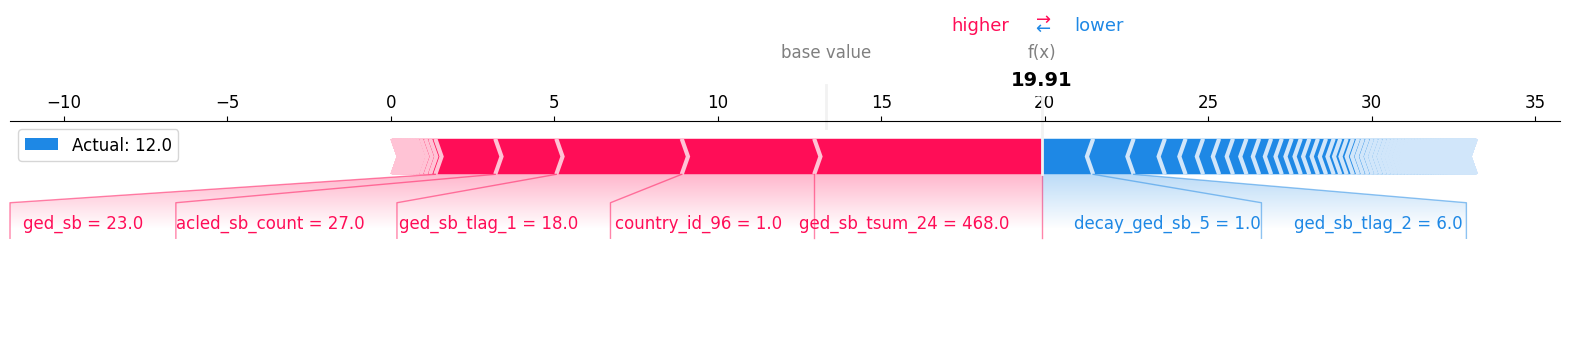

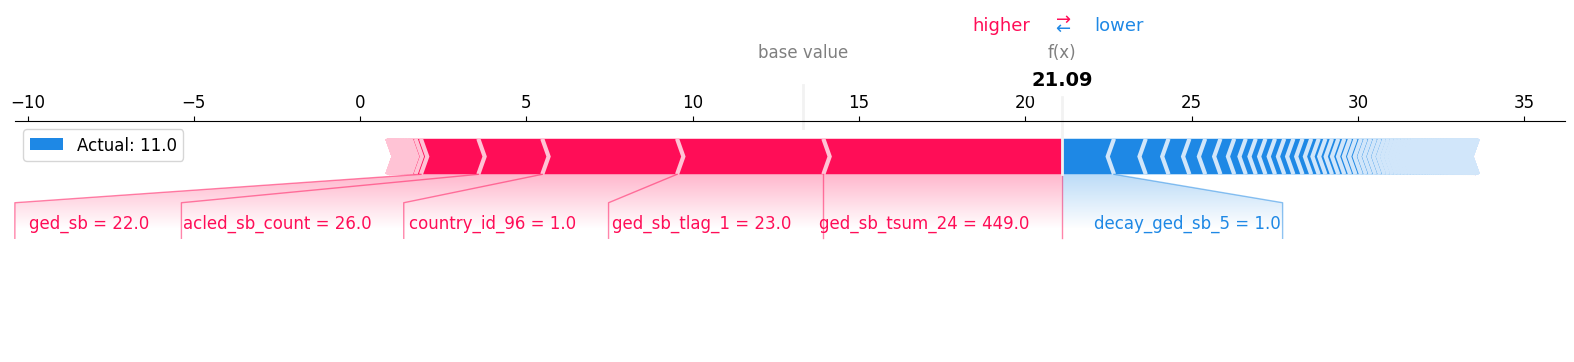

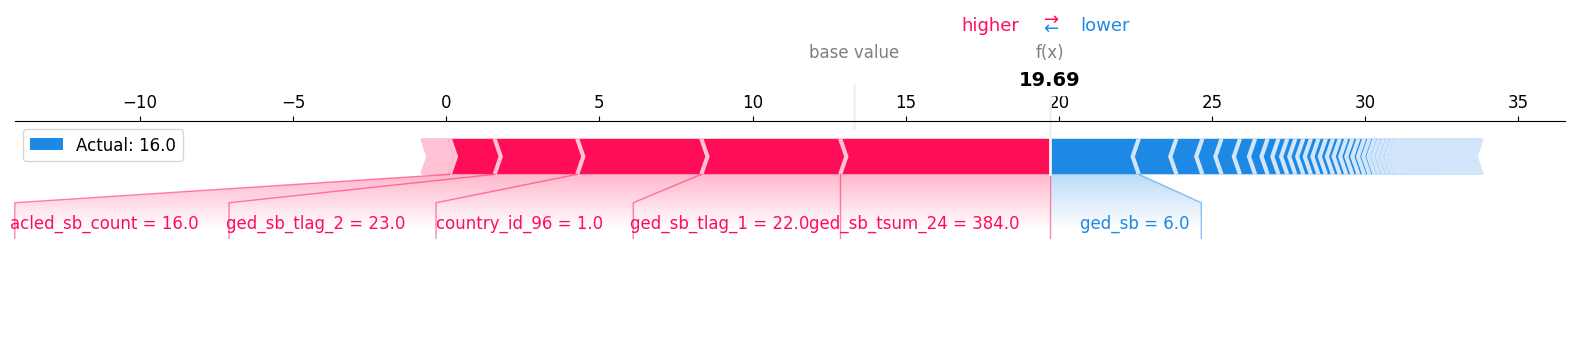

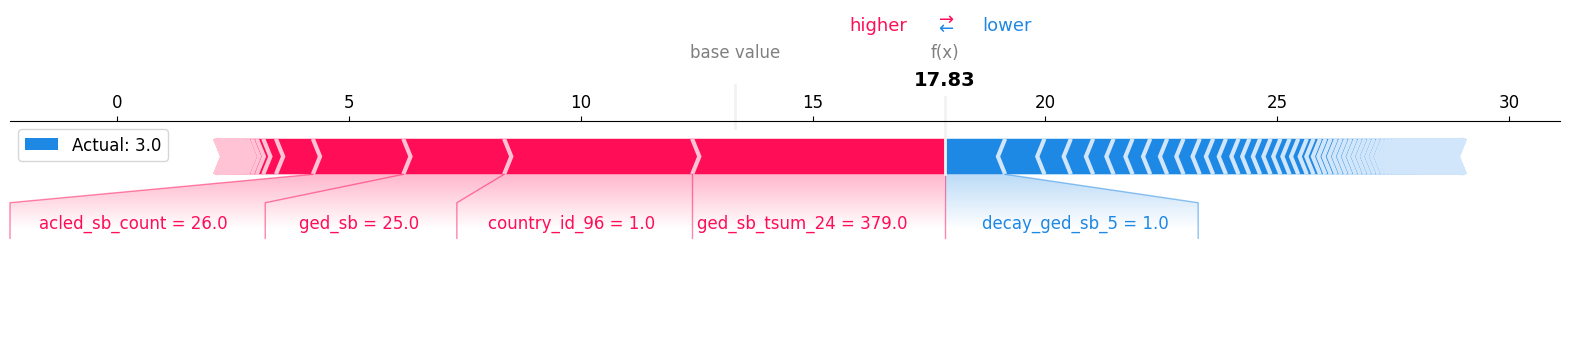

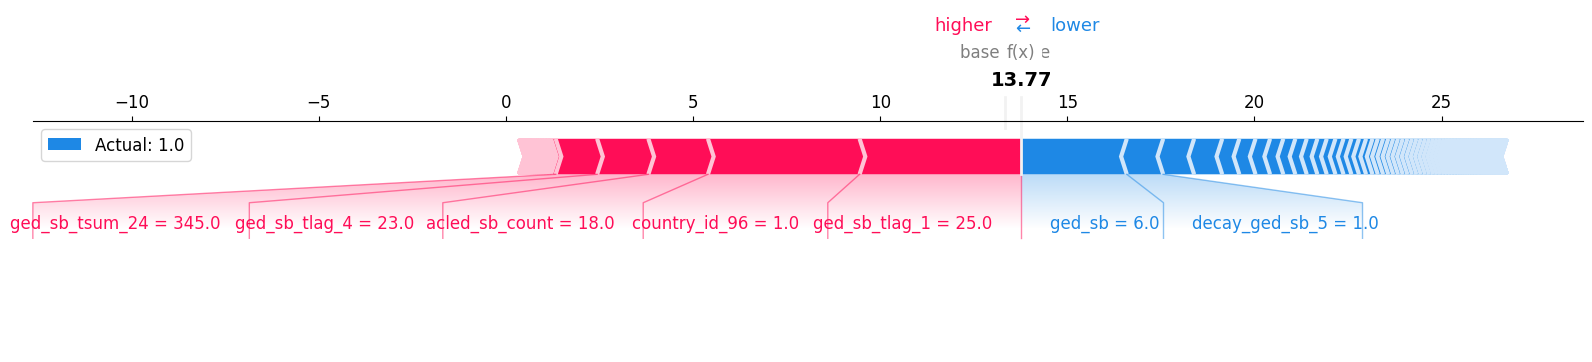

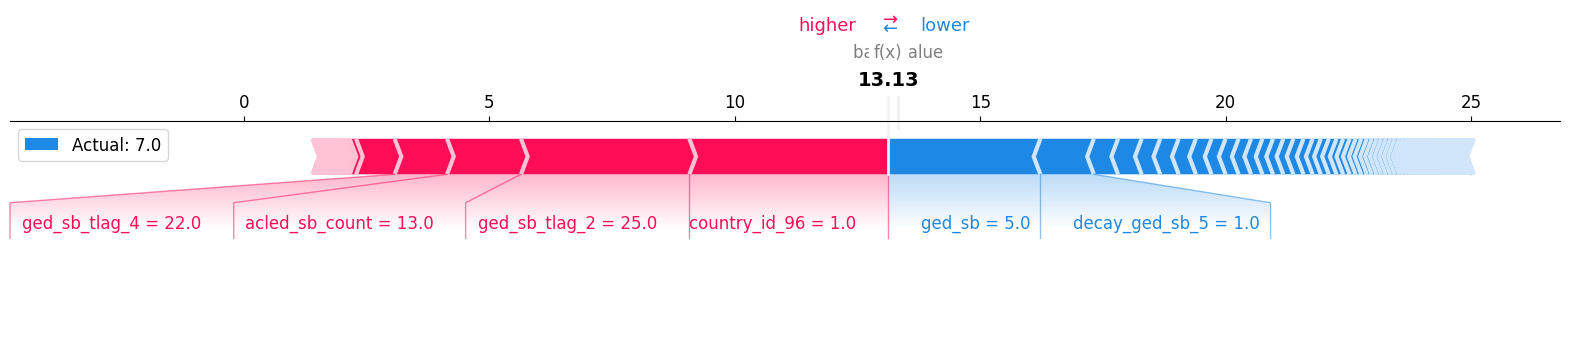

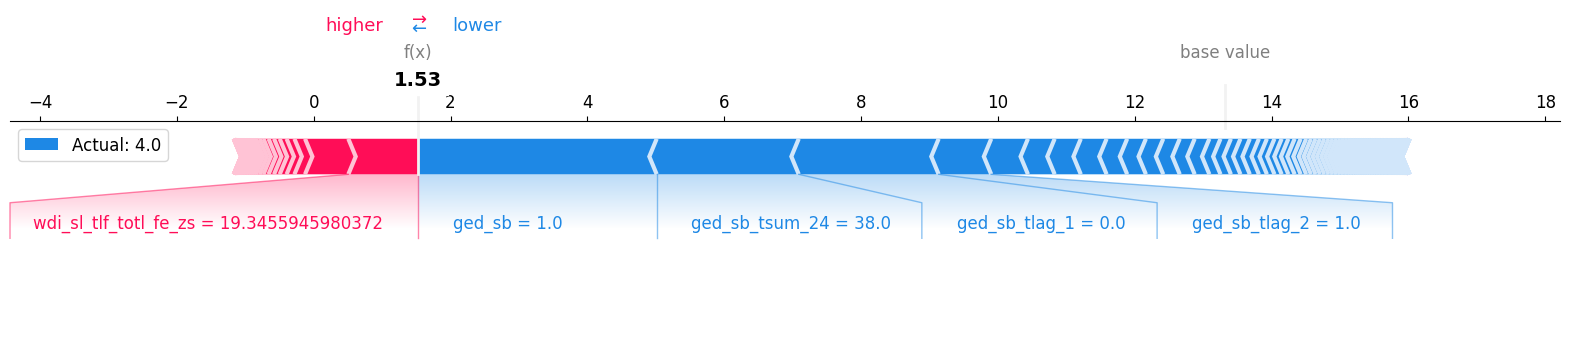

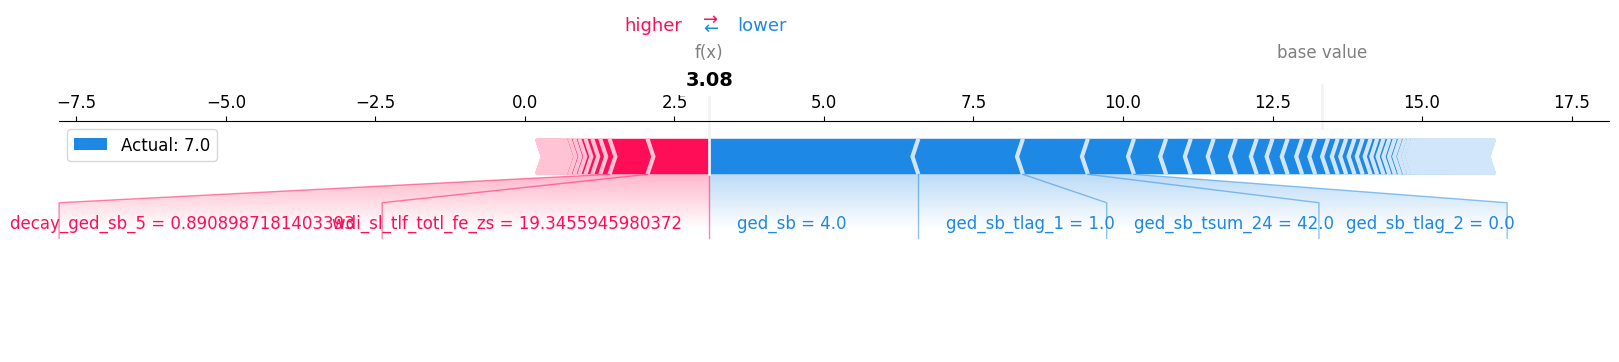

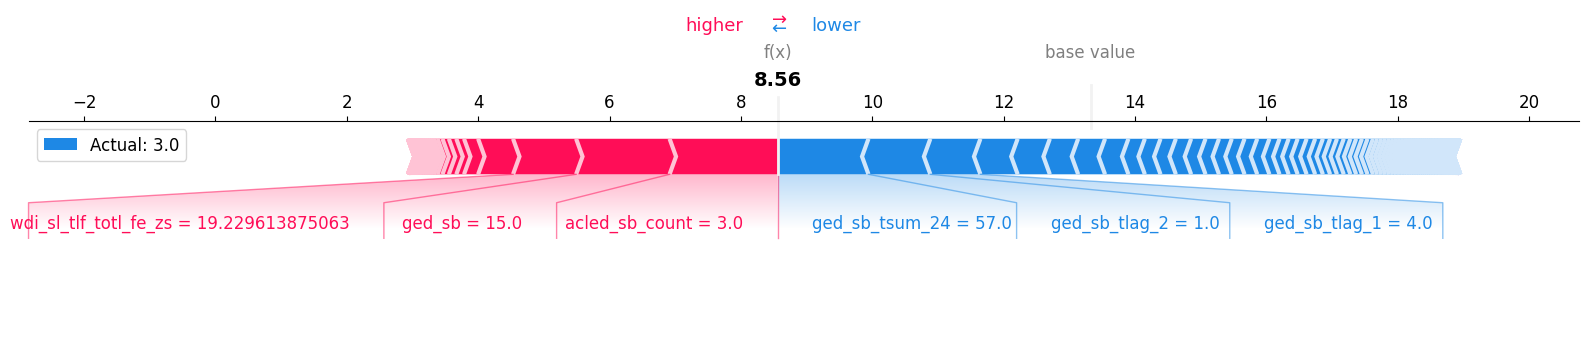

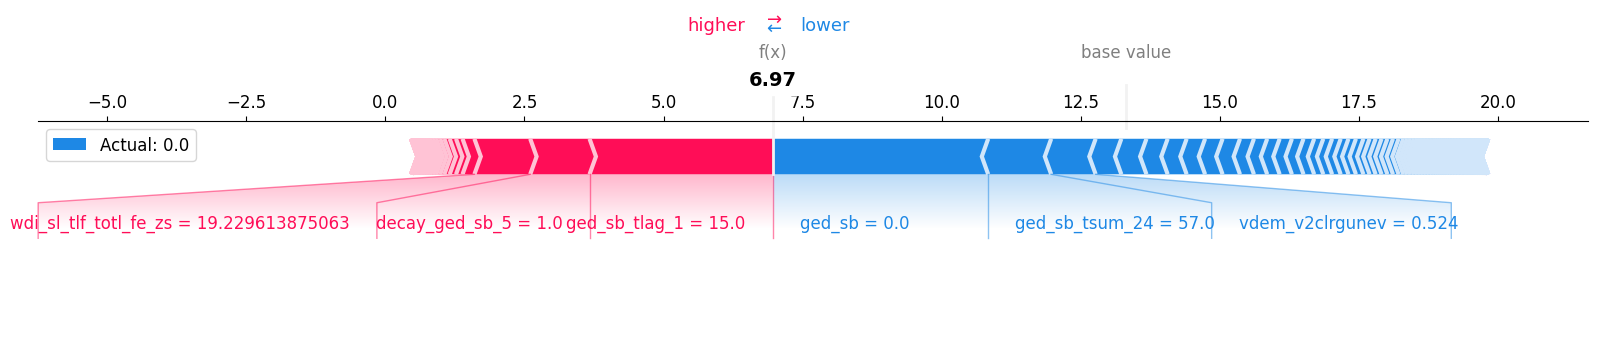

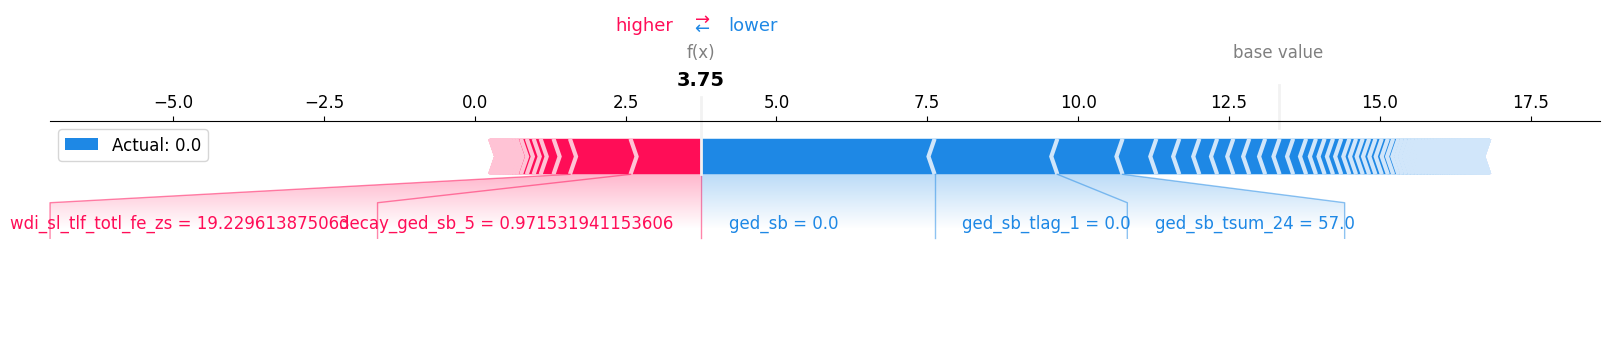

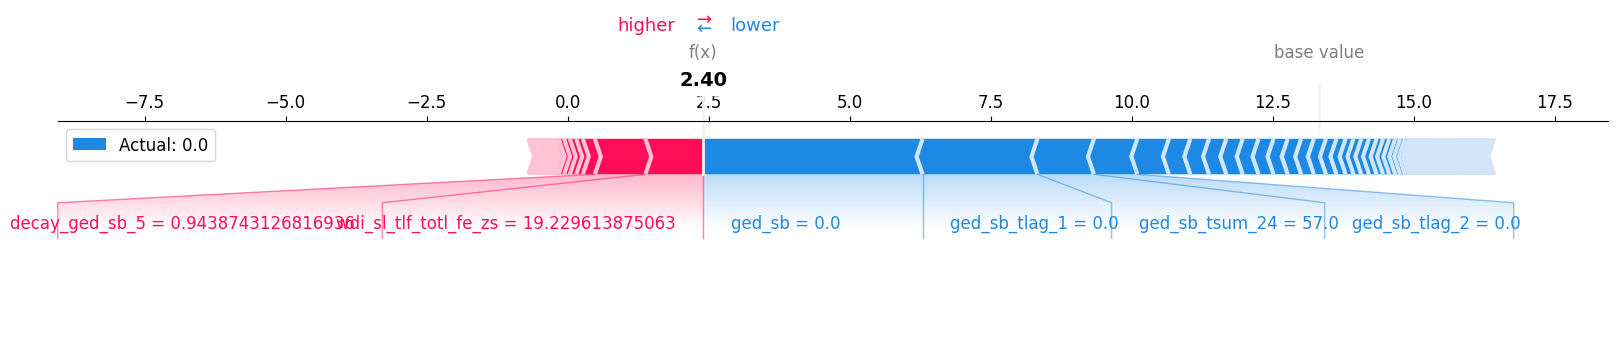

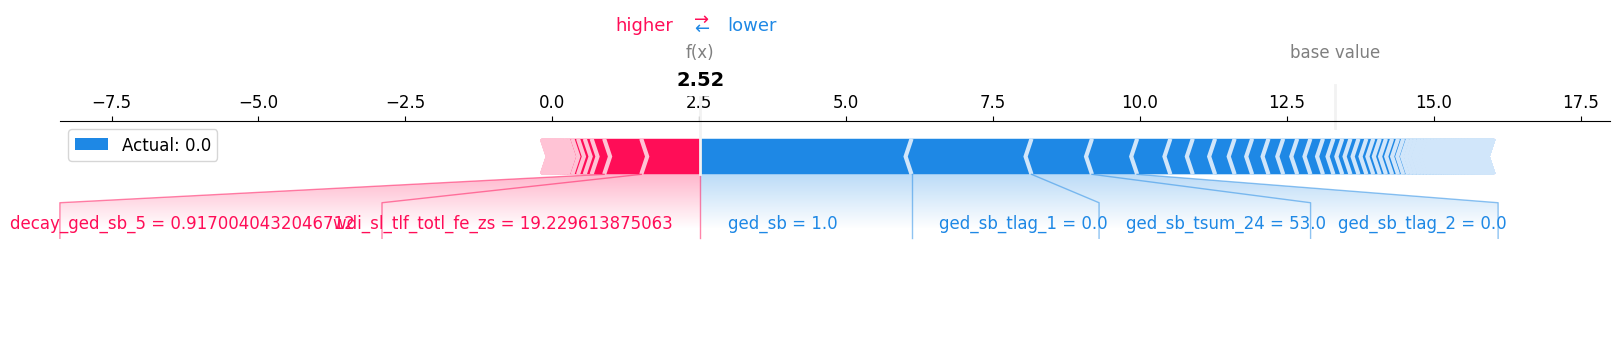

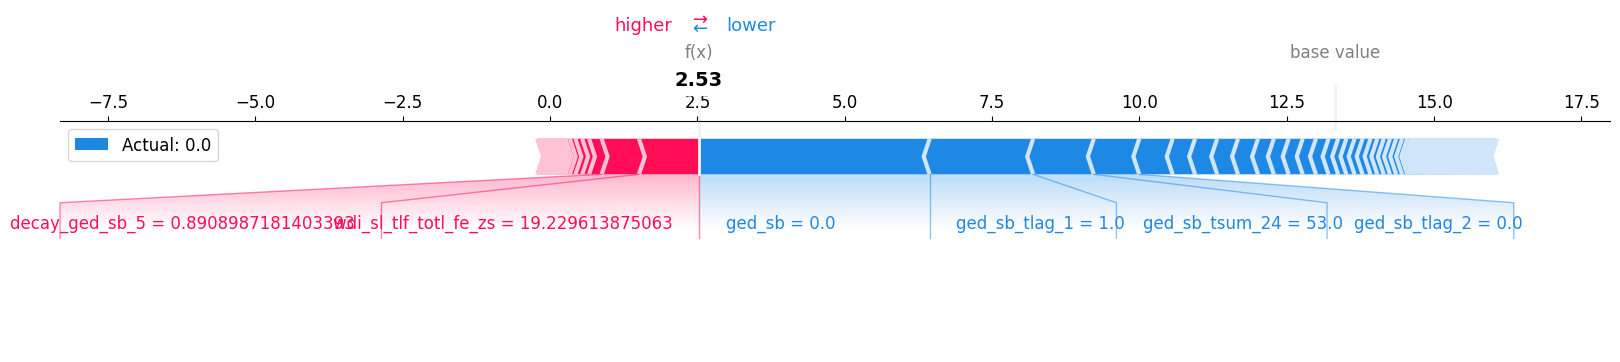

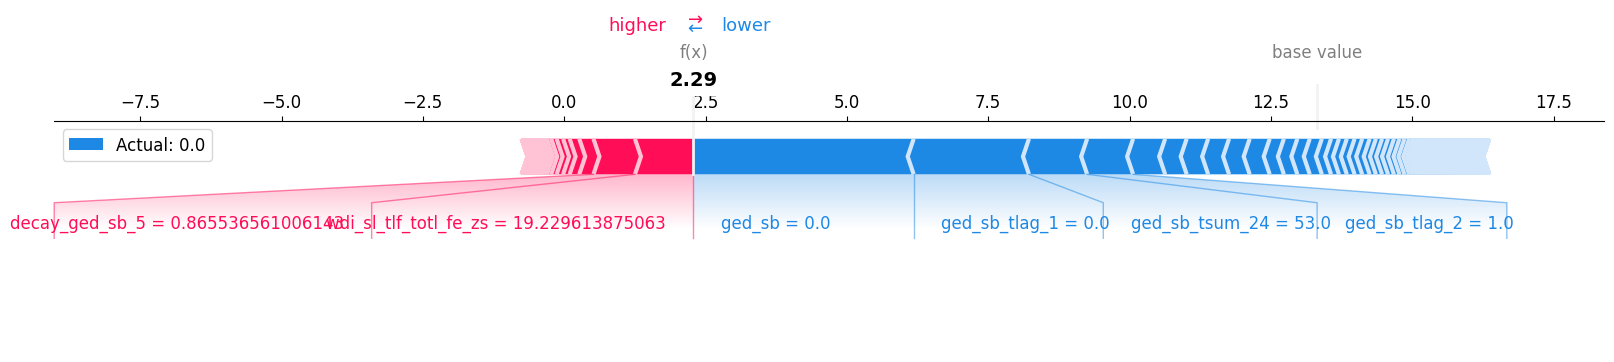

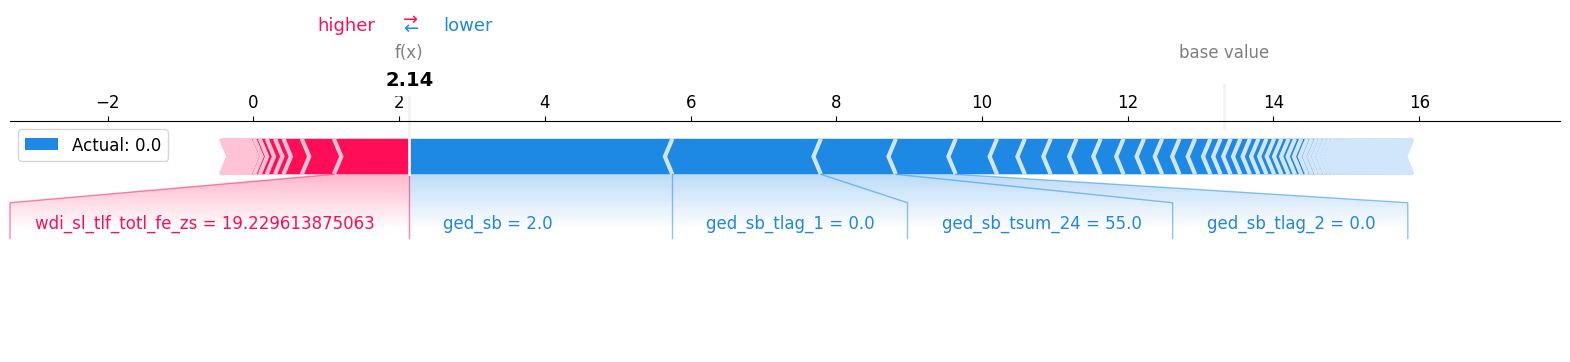

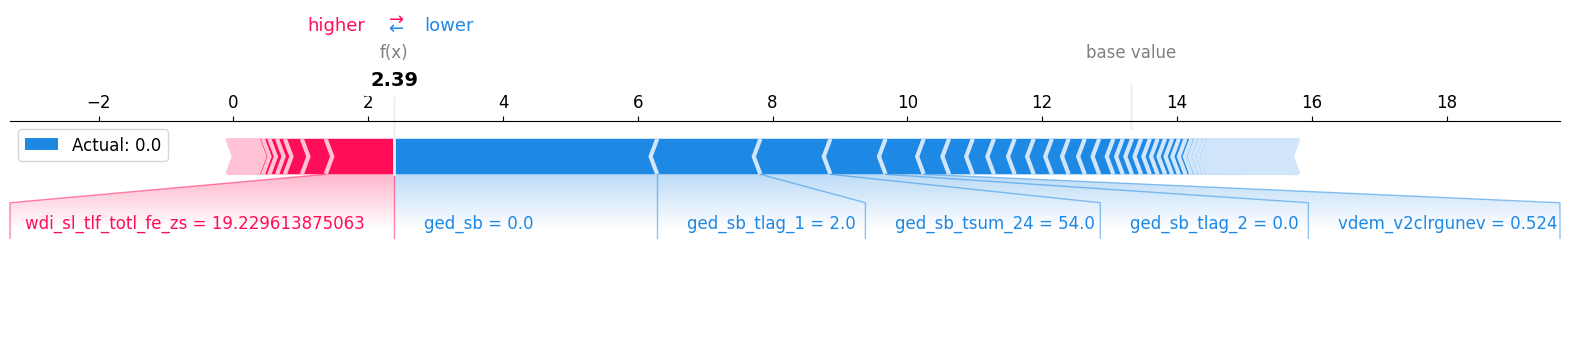

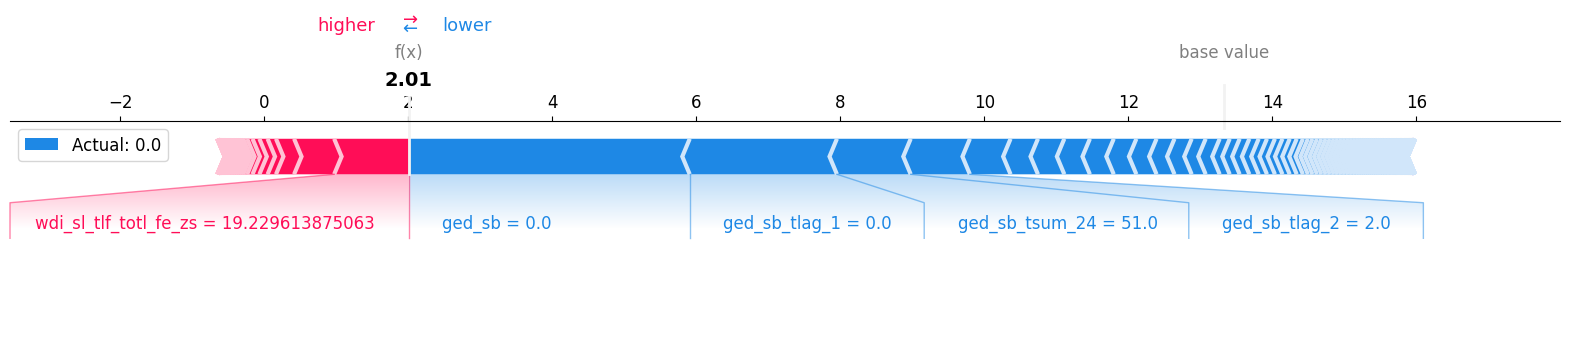

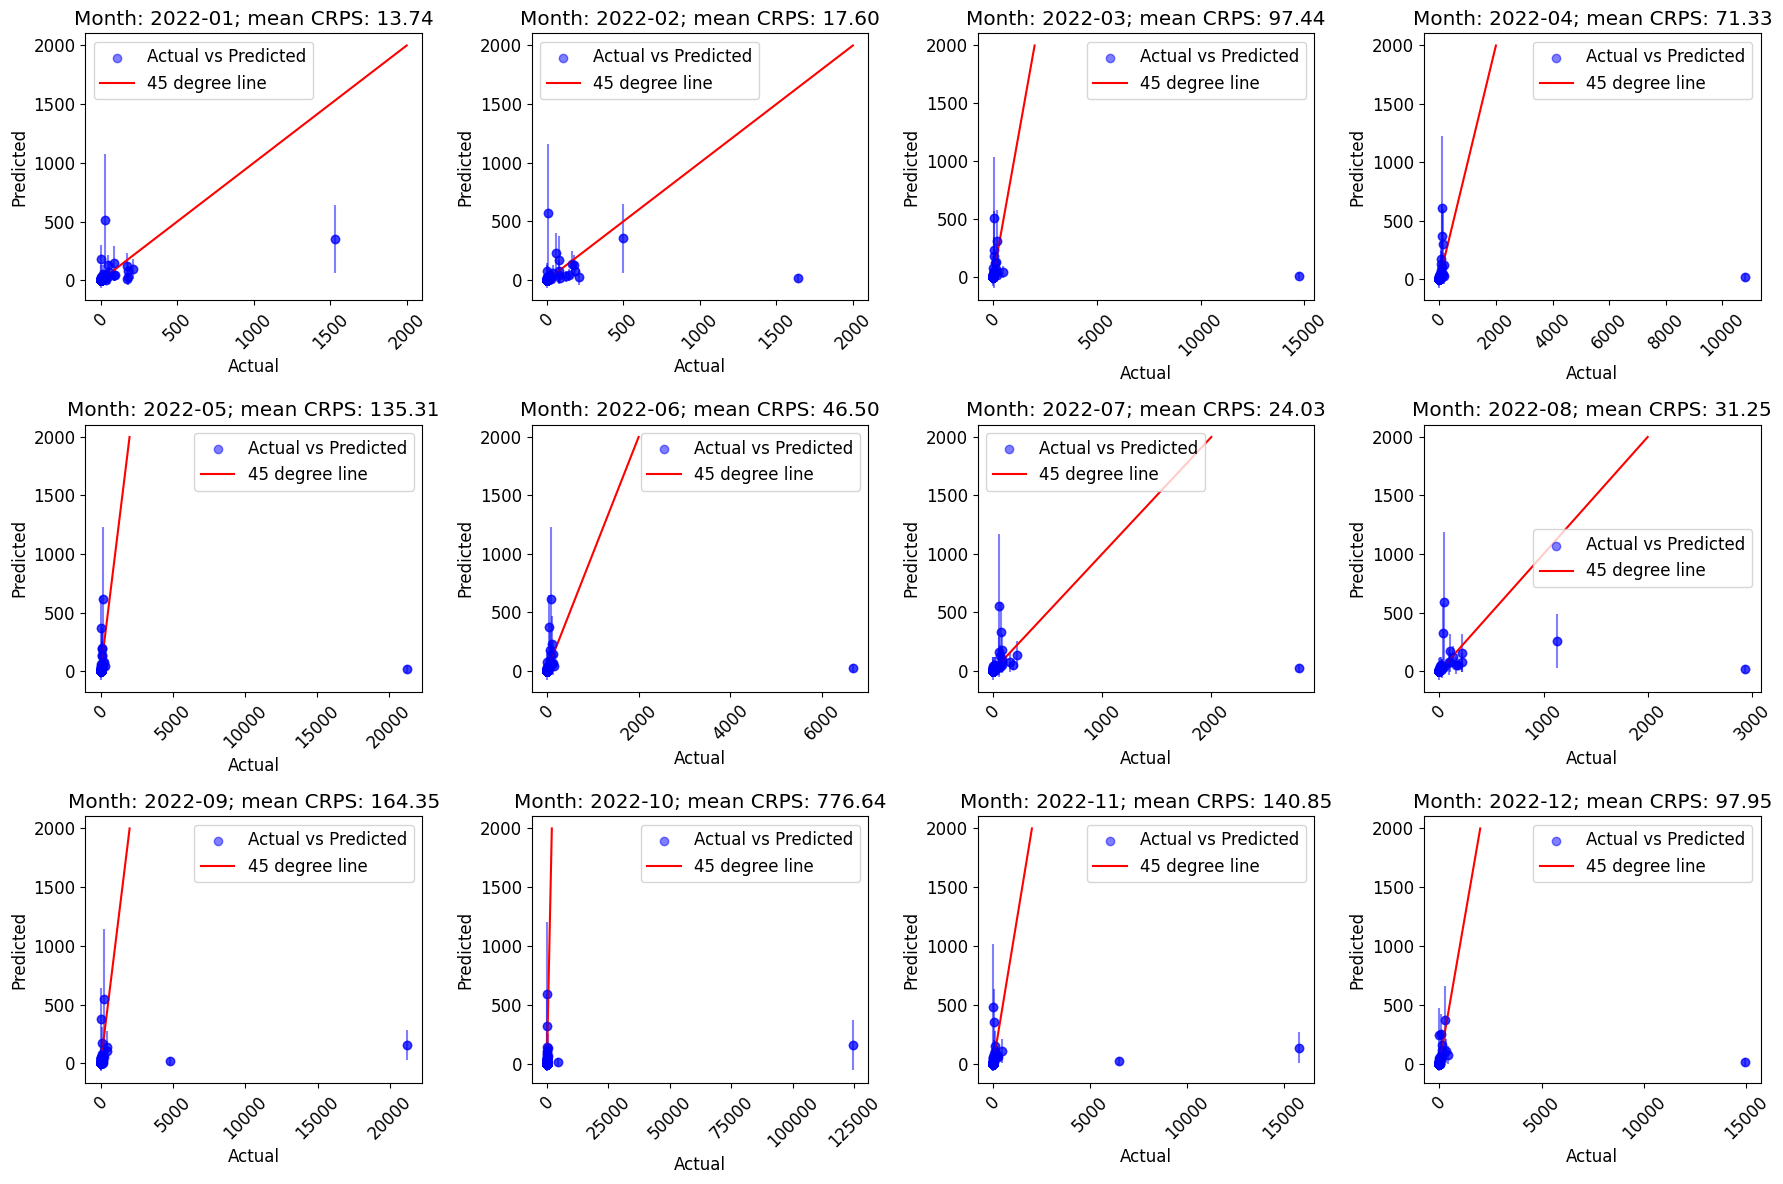

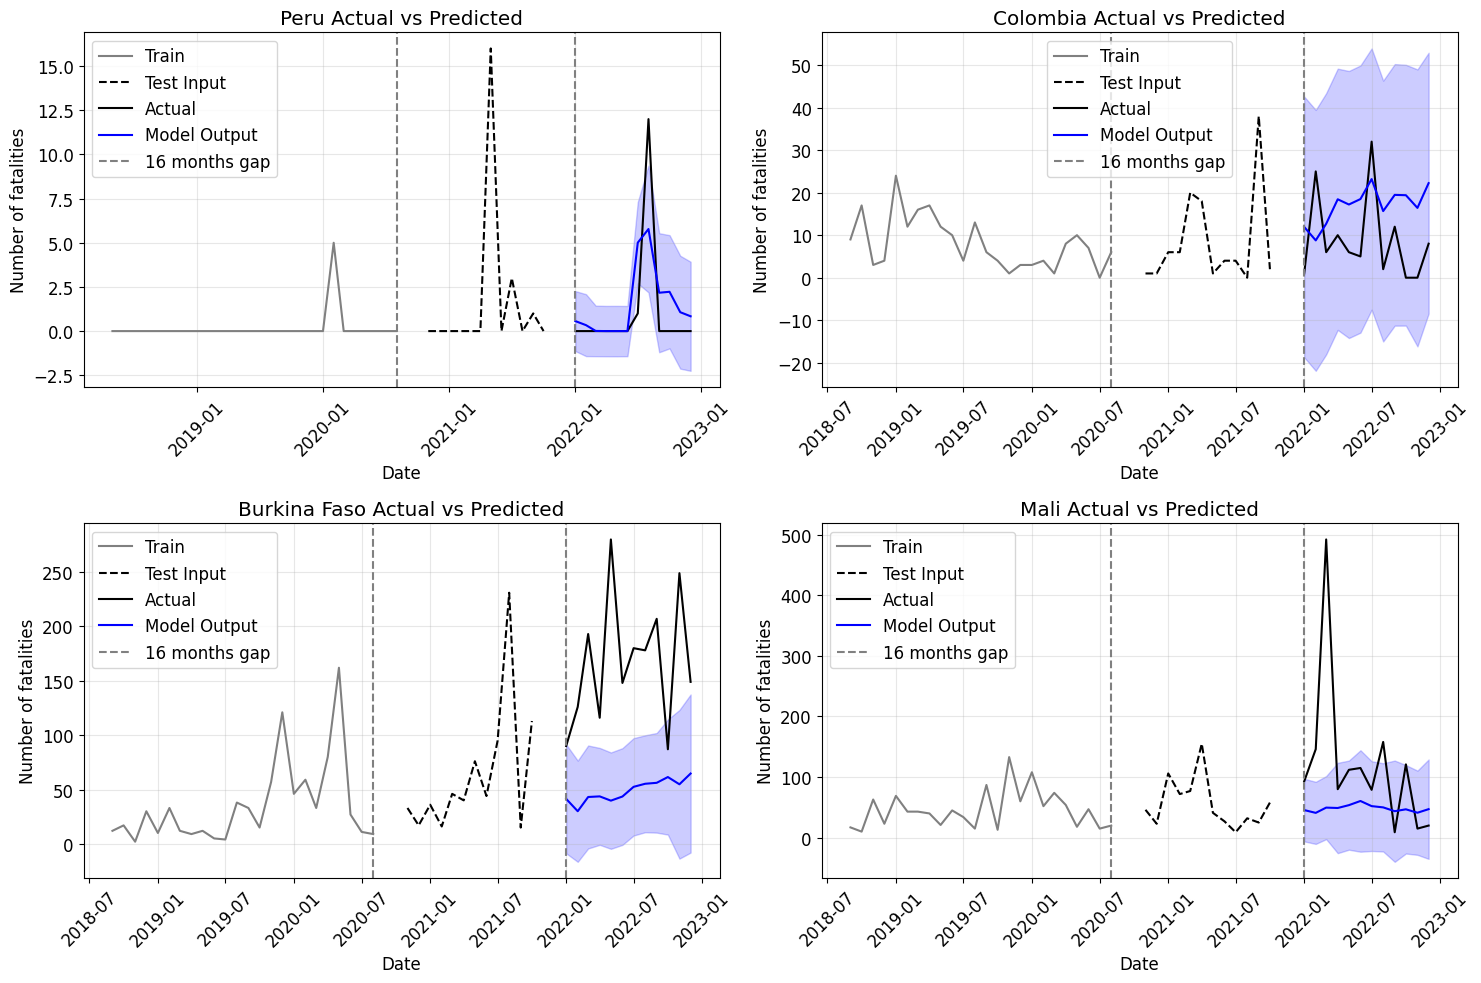

Skipping Senegal as all actual are 0
Skipping Sierra Leone as all actual are 0
Skipping The Gambia as all actual are 0
Skipping Djibouti as all actual are 0
Skipping Mongolia as all actual are 0
Skipping Jordan as all actual are 0
Skipping Kazakhstan as all actual are 0
Skipping Norway as all actual are 0


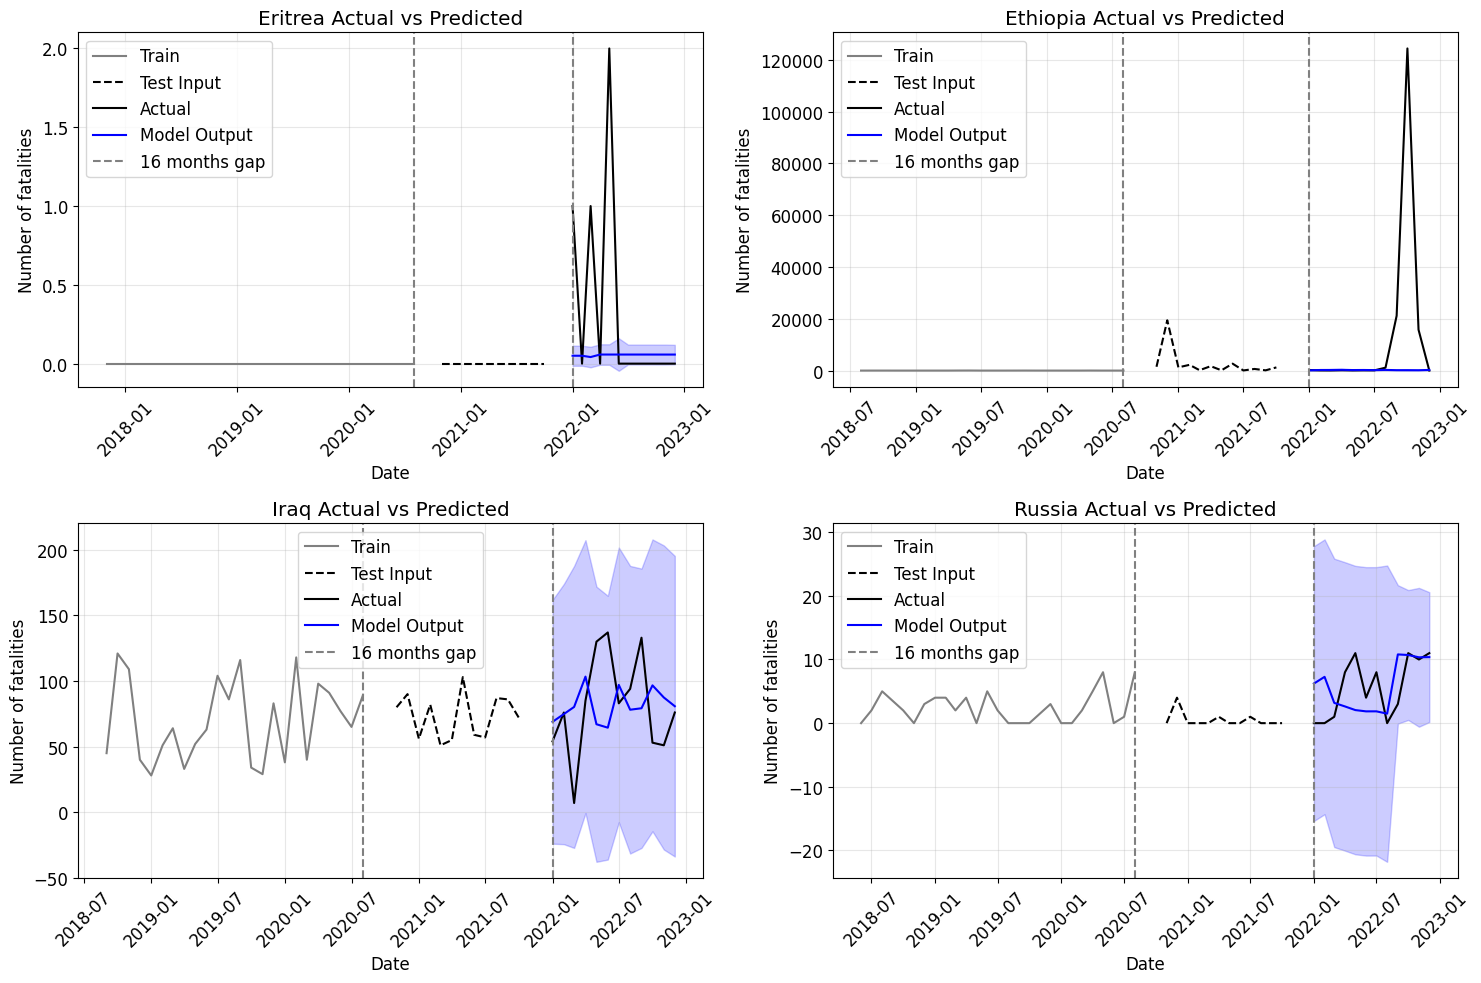

Skipping Sweden as all actual are 0


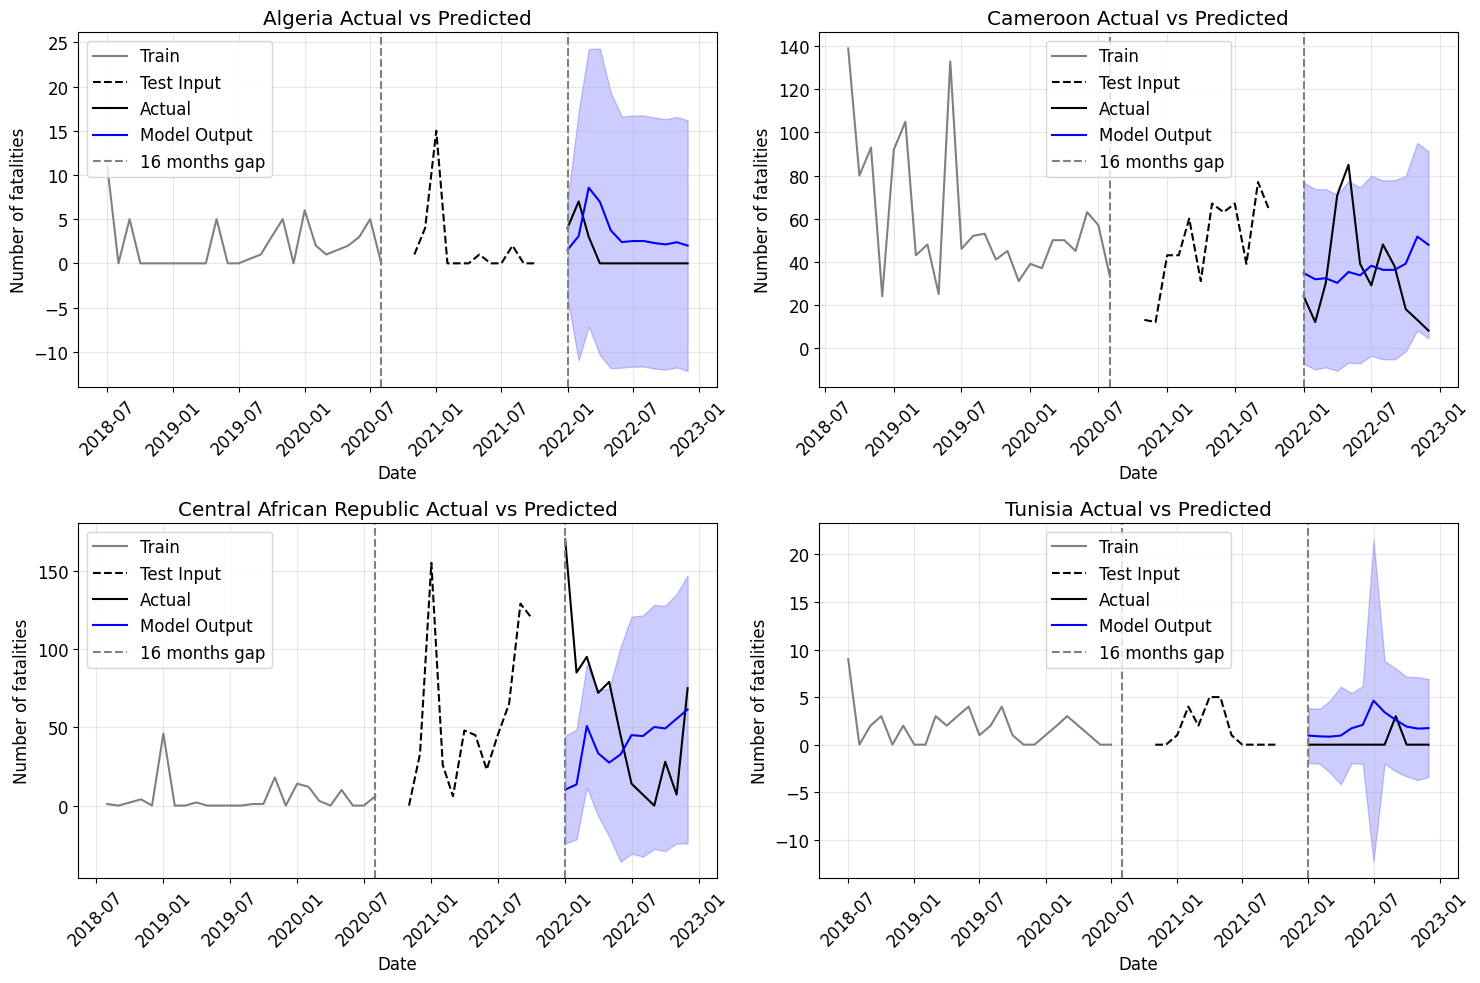

Skipping Equatorial Guinea as all actual are 0


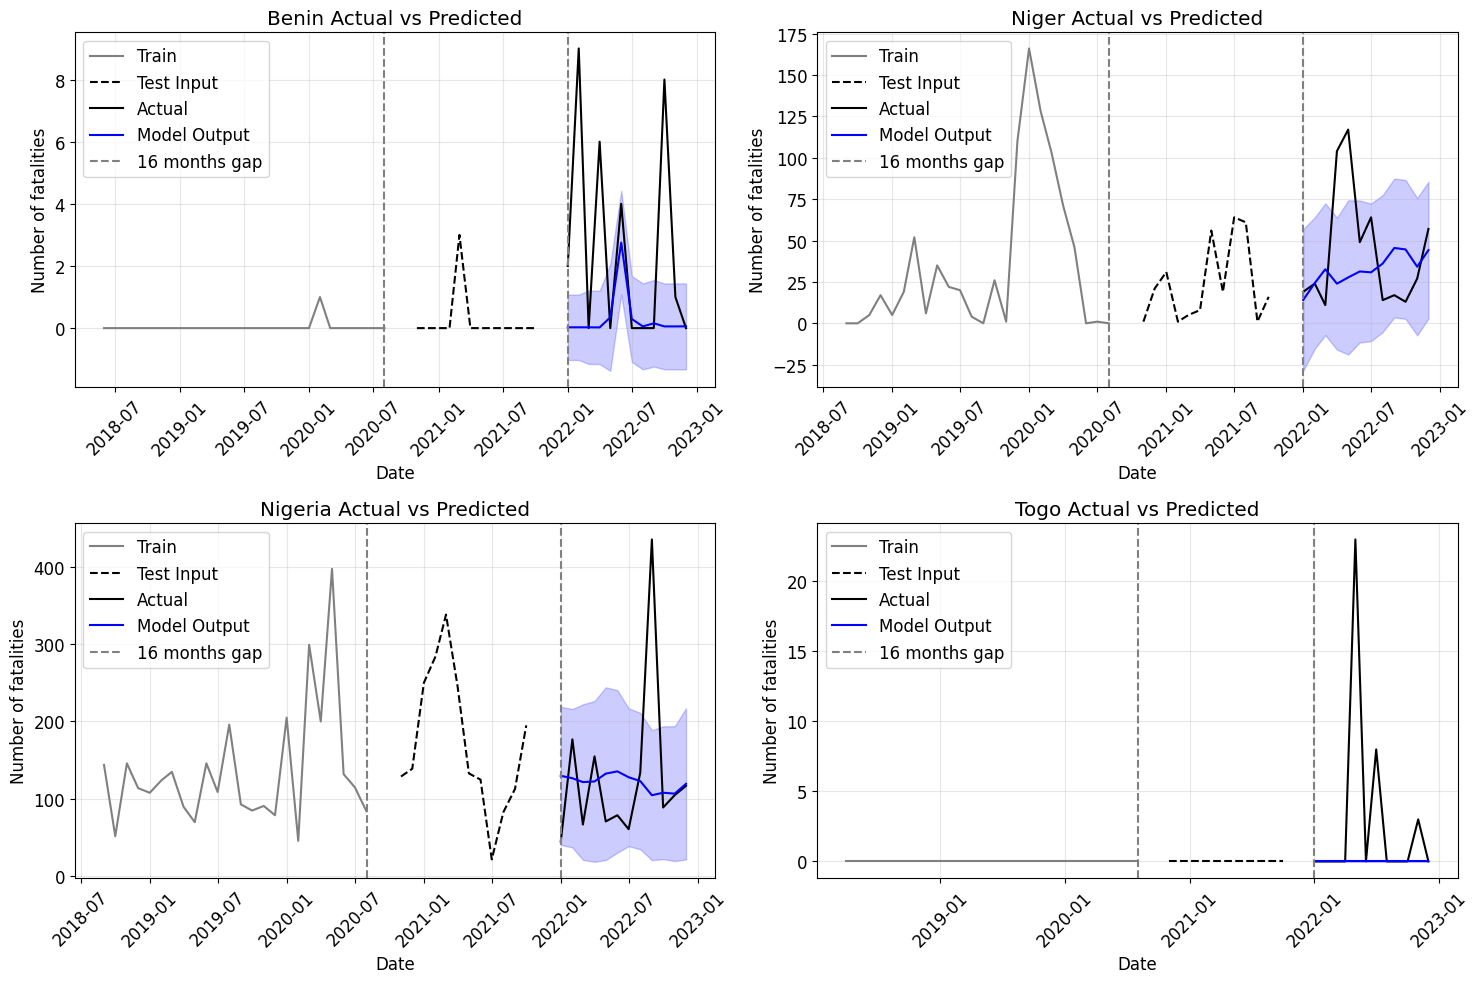

Skipping Albania as all actual are 0
Skipping Bosnia and Herzegovina as all actual are 0
Skipping Croatia as all actual are 0
Skipping Italy as all actual are 0
Skipping Macedonia as all actual are 0
Skipping Malta as all actual are 0
Skipping Bulgaria as all actual are 0
Skipping Cyprus as all actual are 0
Skipping Georgia as all actual are 0
Skipping Greece as all actual are 0
Skipping Lebanon as all actual are 0
Skipping Austria as all actual are 0
Skipping Czech Republic as all actual are 0
Skipping Denmark as all actual are 0
Skipping Hungary as all actual are 0
Skipping Slovakia as all actual are 0
Skipping Slovenia as all actual are 0
Skipping Belgium as all actual are 0
Skipping France as all actual are 0
Skipping Luxembourg as all actual are 0
Skipping Netherlands as all actual are 0
Skipping Switzerland as all actual are 0
Skipping Belarus as all actual are 0
Skipping Estonia as all actual are 0
Skipping Finland as all actual are 0
Skipping Latvia as all actual are 0
Skipping

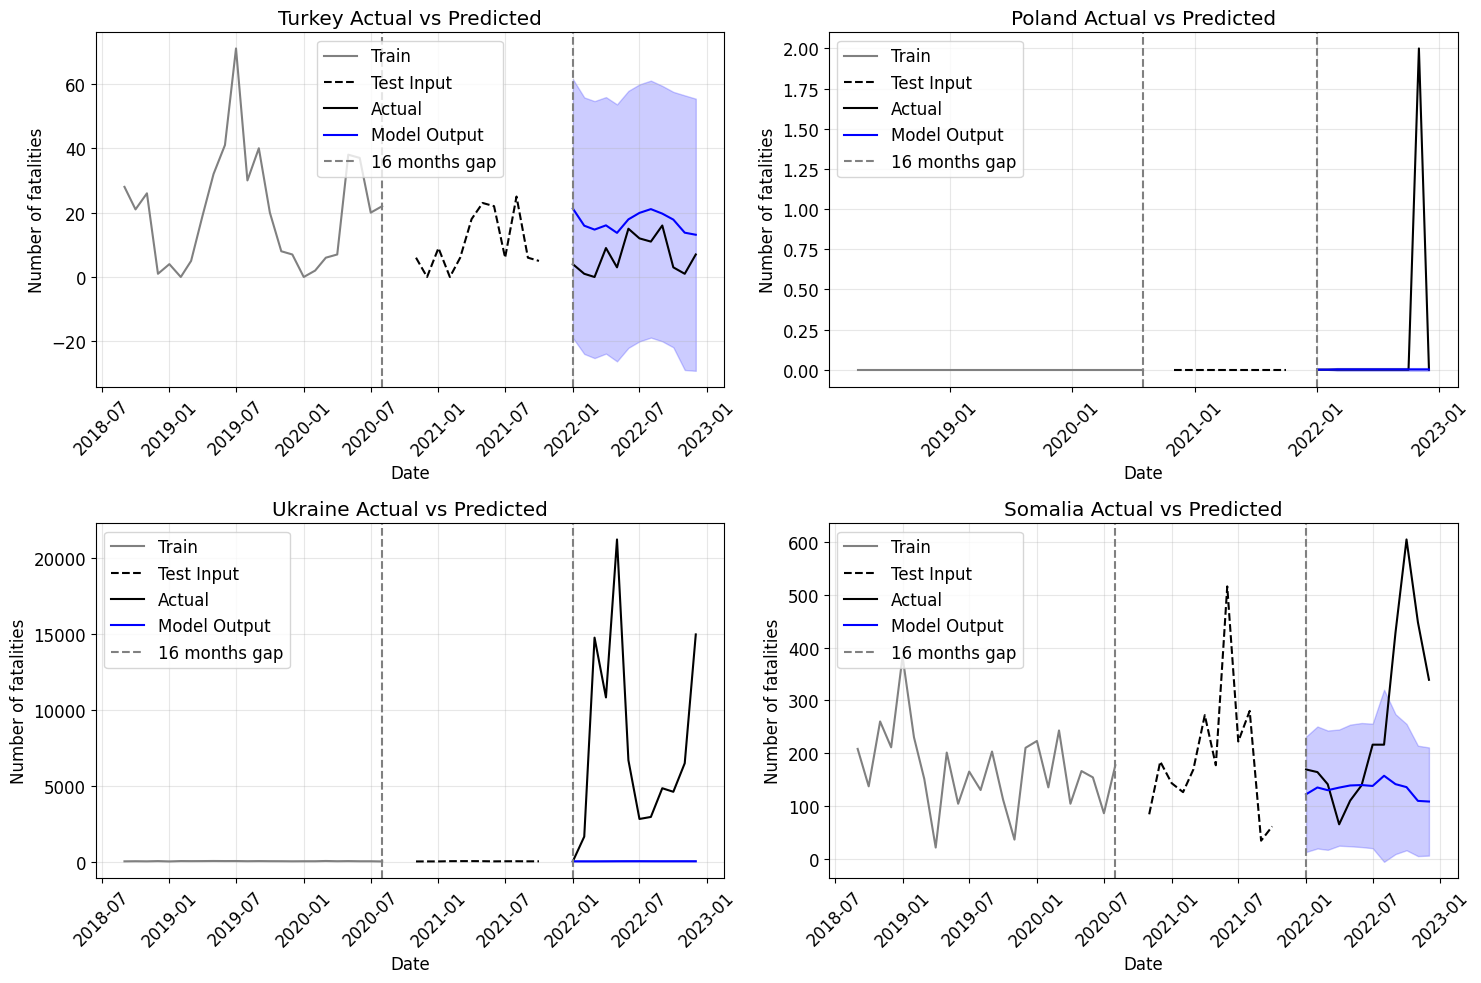

Skipping Sri Lanka as all actual are 0
Skipping Turkmenistan as all actual are 0
Skipping Uzbekistan as all actual are 0
Skipping Bahrain as all actual are 0


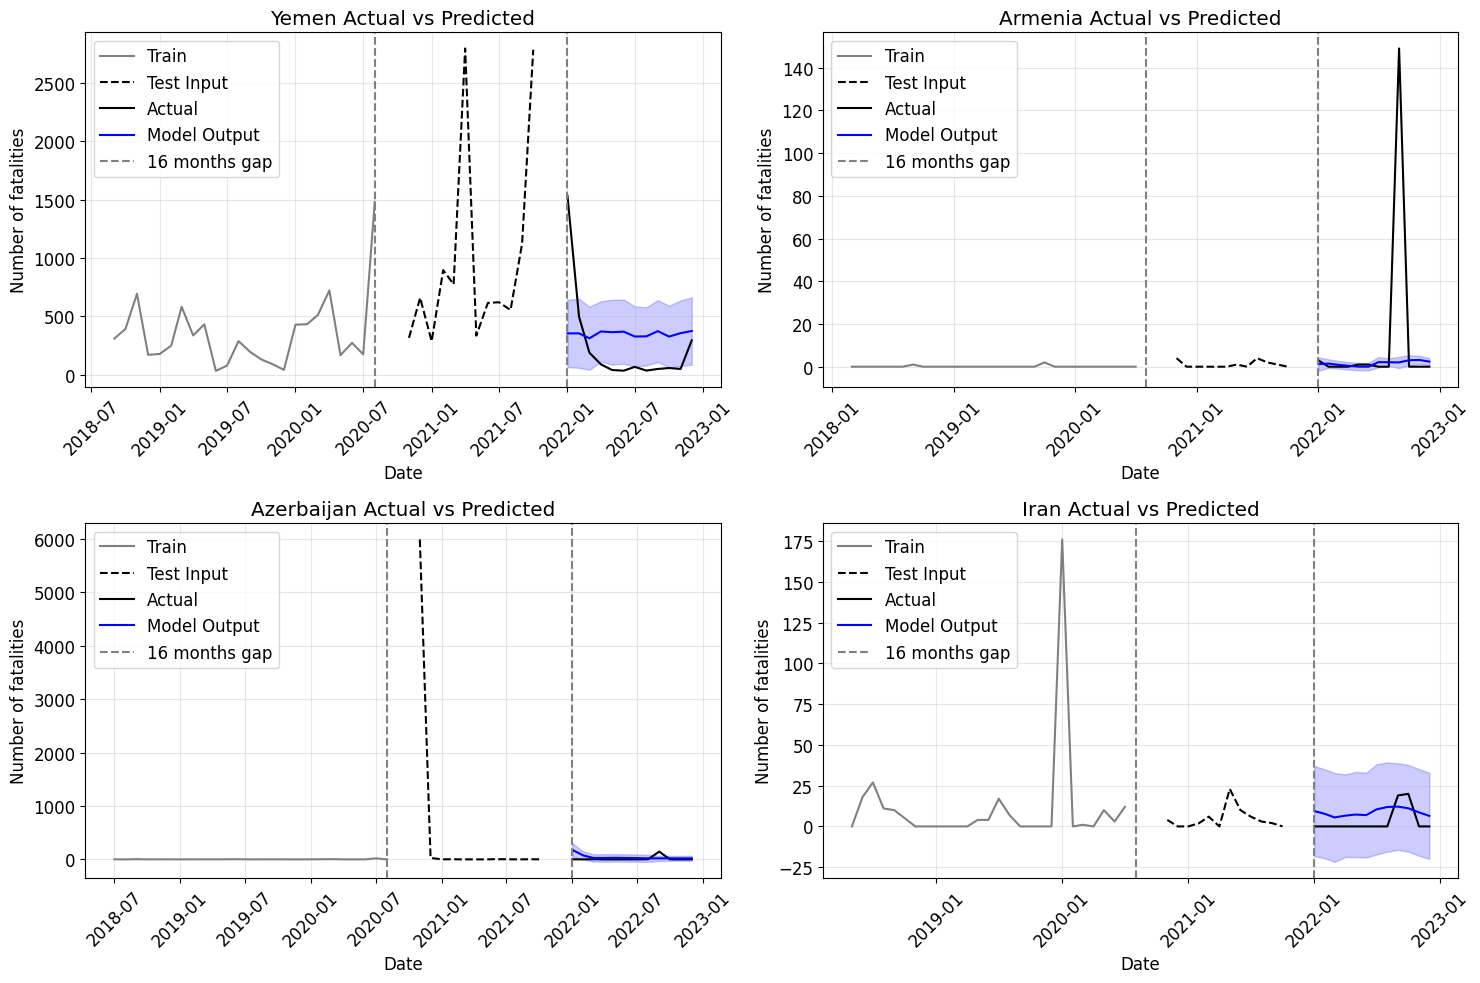

Skipping Kuwait as all actual are 0
Skipping Qatar as all actual are 0
Skipping Saudi Arabia as all actual are 0
Skipping Nepal as all actual are 0


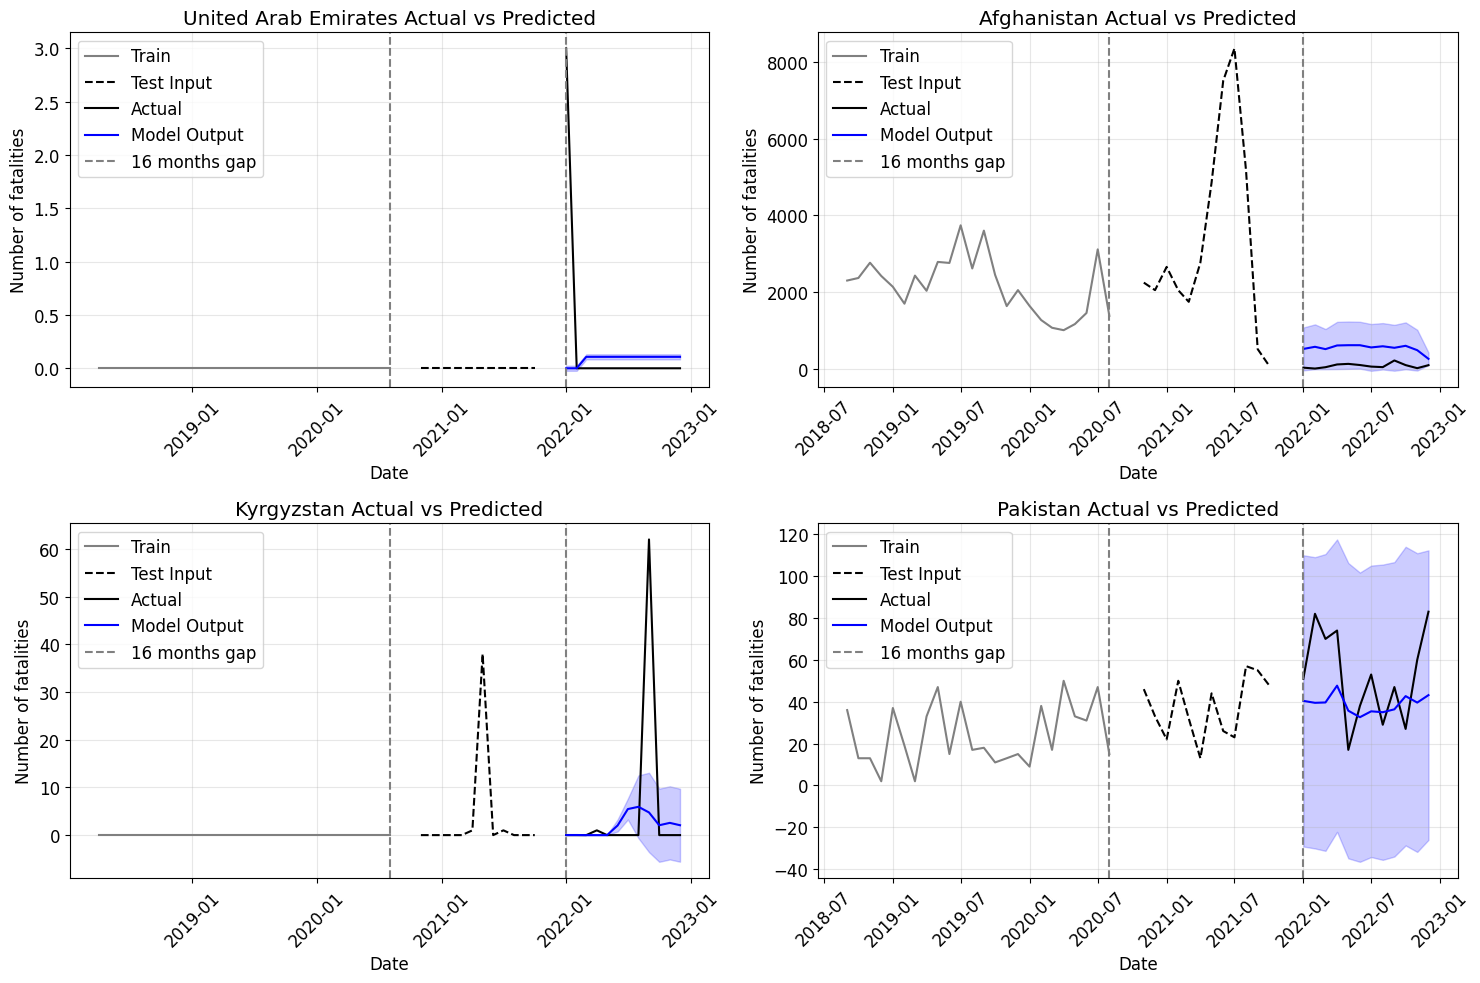

Skipping Bhutan as all actual are 0
Skipping Japan as all actual are 0
Skipping North Korea as all actual are 0
Skipping South Korea as all actual are 0
Skipping Cambodia as all actual are 0
Skipping Laos as all actual are 0


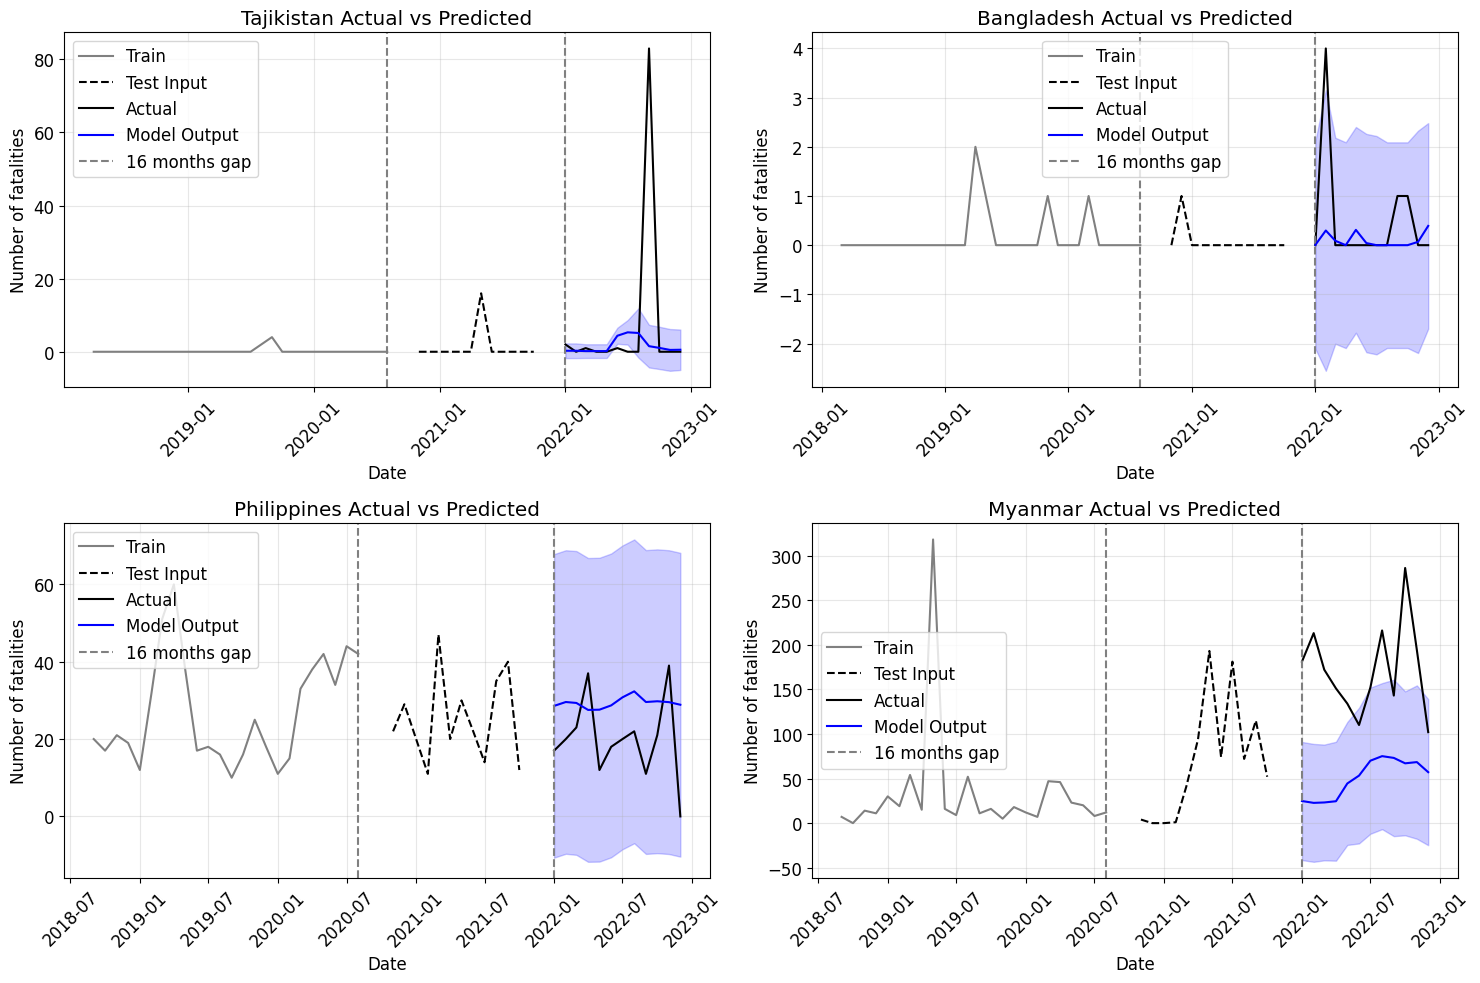

Skipping Vietnam as all actual are 0
Skipping Botswana as all actual are 0
Skipping Zambia as all actual are 0
Skipping Zimbabwe as all actual are 0
Skipping Comoros as all actual are 0
Skipping Lesotho as all actual are 0
Skipping Malawi as all actual are 0


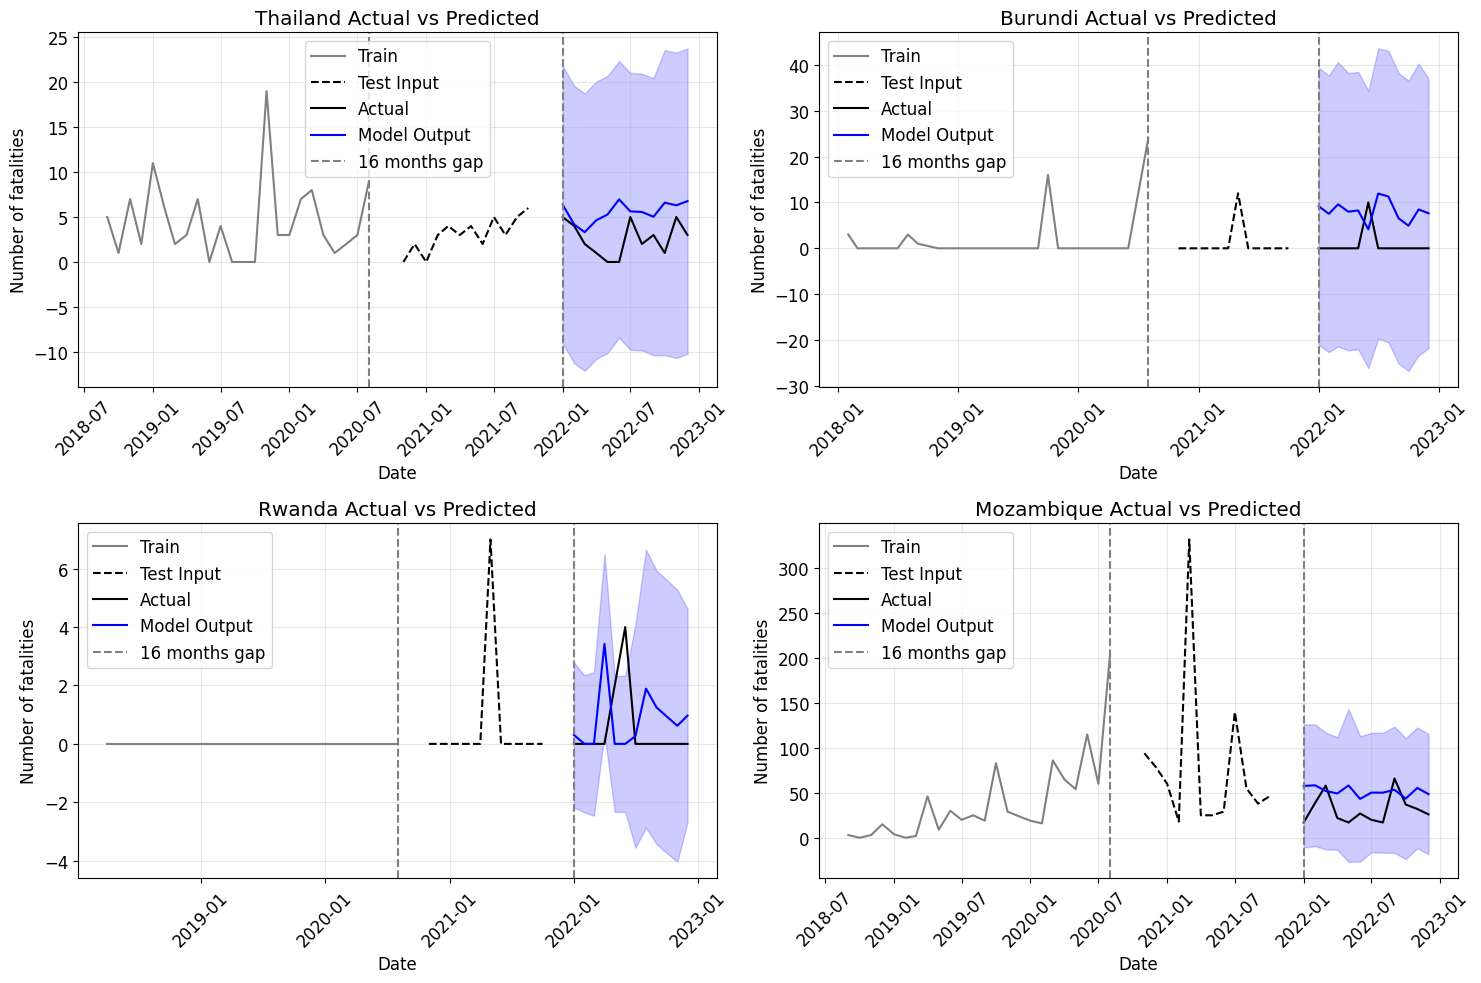

Skipping South Africa as all actual are 0
Skipping Swaziland as all actual are 0
Skipping Fiji as all actual are 0
Skipping Gabon as all actual are 0
Skipping Namibia as all actual are 0
Skipping New Zealand as all actual are 0
Skipping Madagascar as all actual are 0
Skipping Mauritius as all actual are 0
Skipping Timor Leste as all actual are 0
Skipping Australia as all actual are 0
Skipping Papua New Guinea as all actual are 0
Skipping Solomon Is. as all actual are 0
Skipping Canada as all actual are 0
Skipping Germany as all actual are 0
Skipping China as all actual are 0
Skipping Malaysia as all actual are 0
Skipping Singapore as all actual are 0


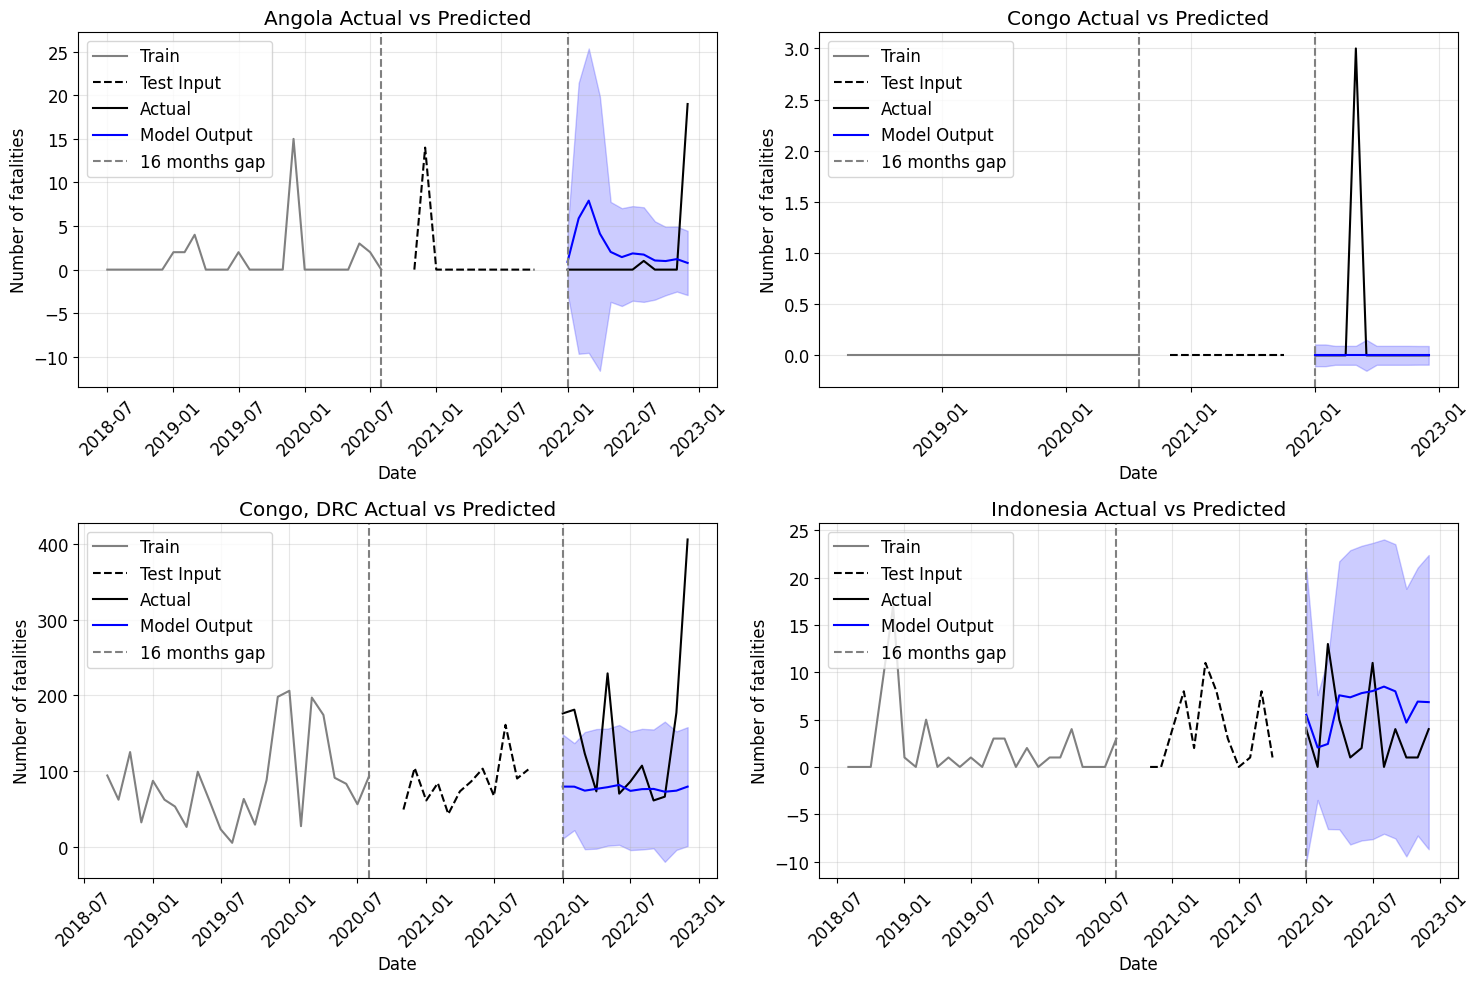

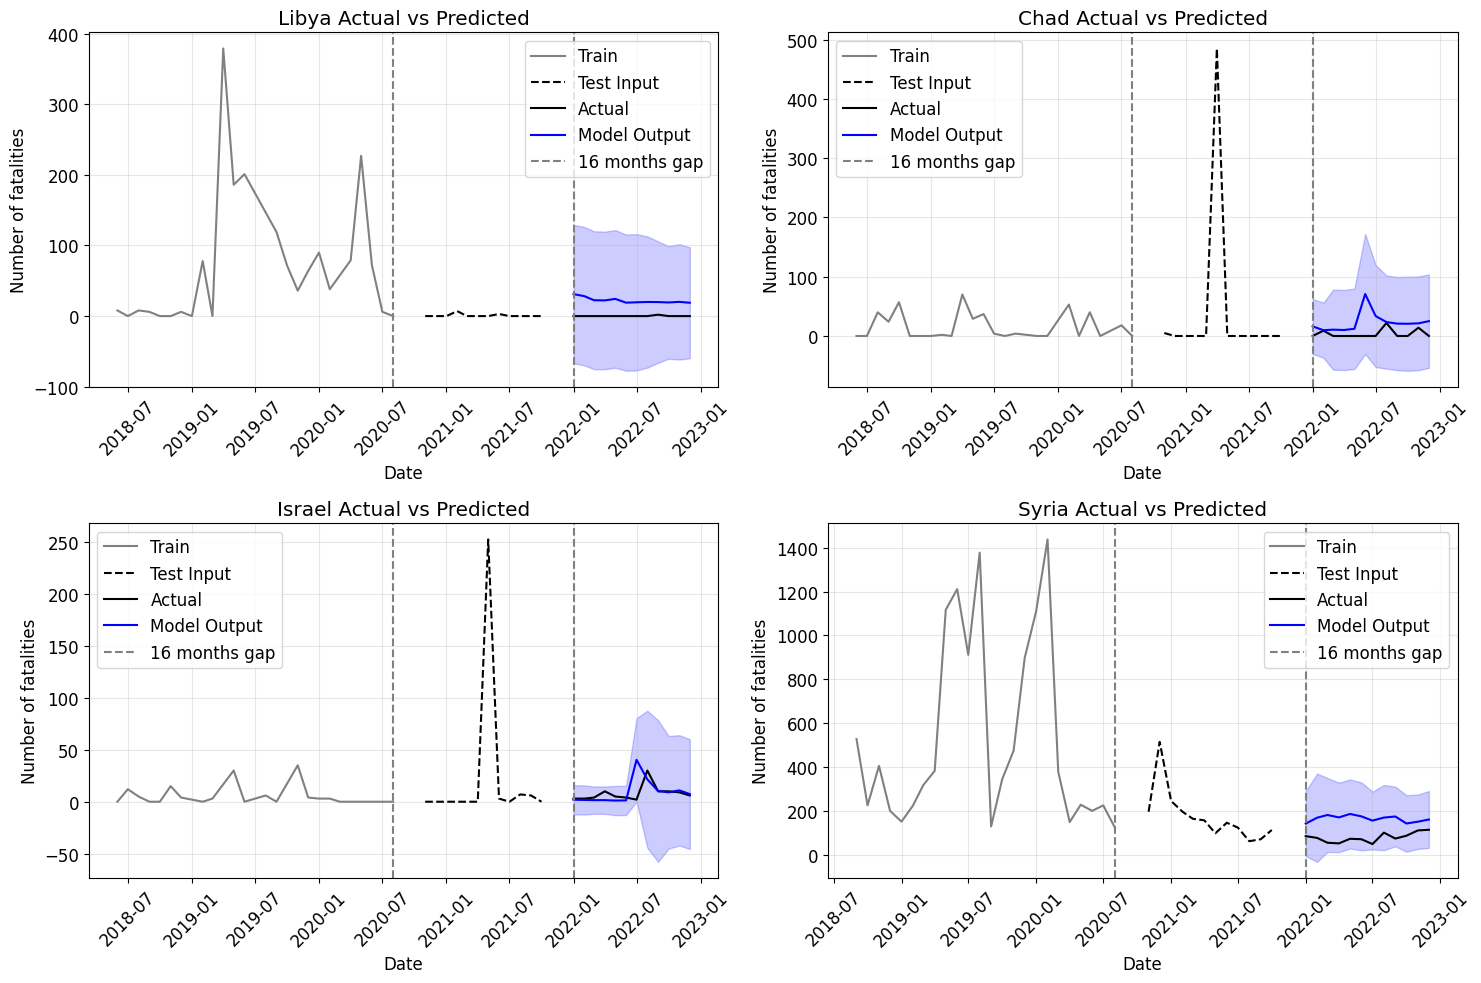

Skipping Montenegro as all actual are 0
Skipping Serbia as all actual are 0
Skipping United States as all actual are 0


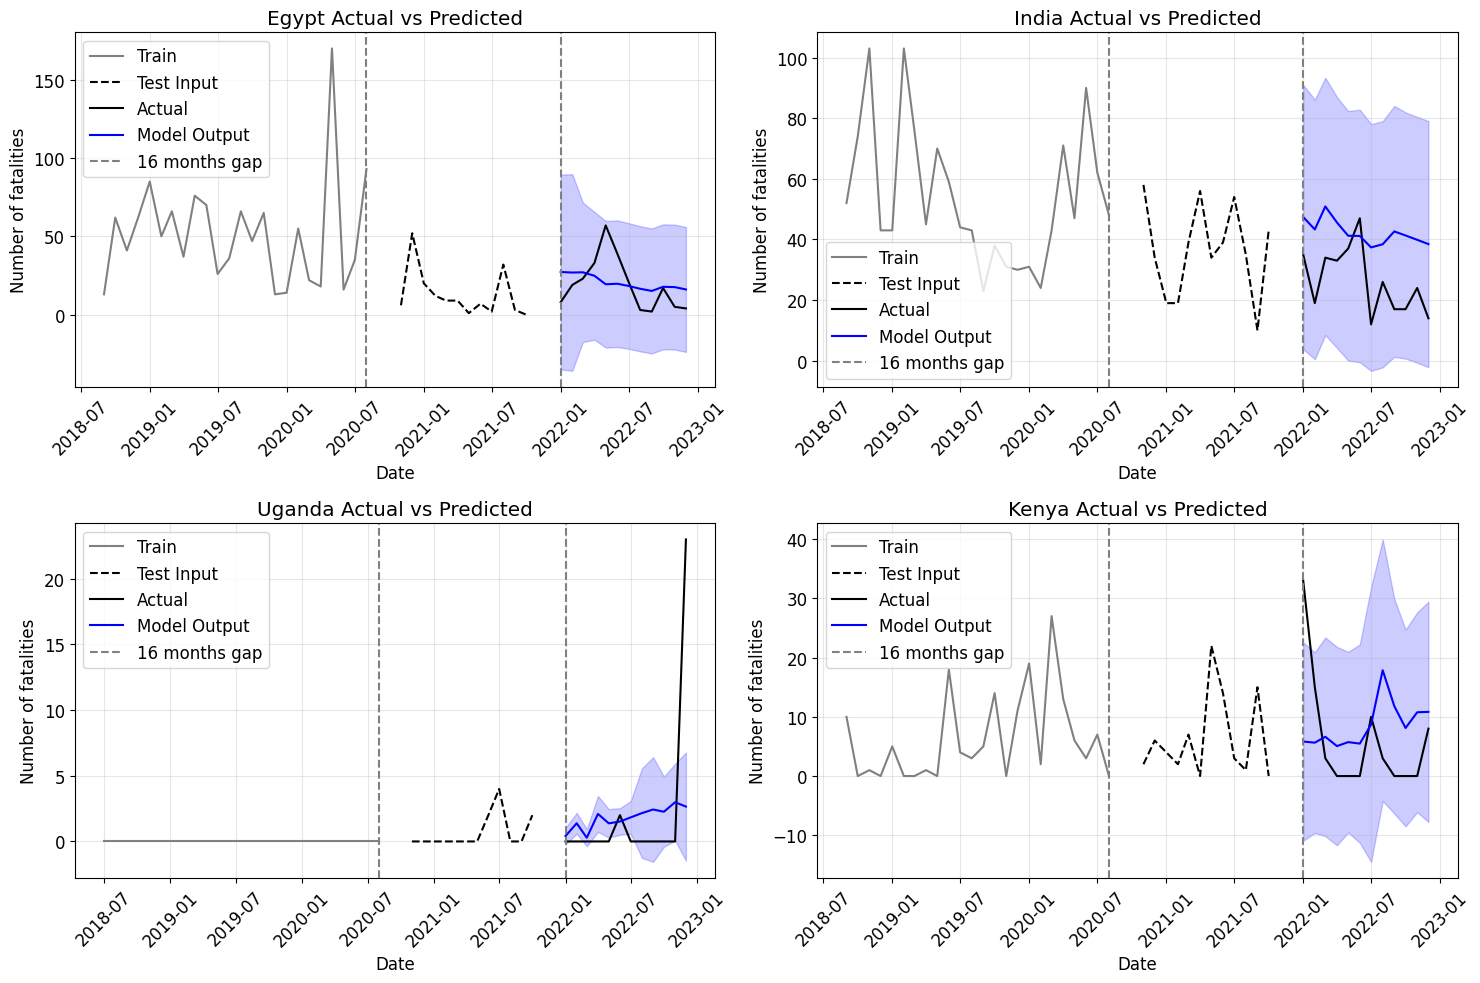

Skipping Mauritania as all actual are 0


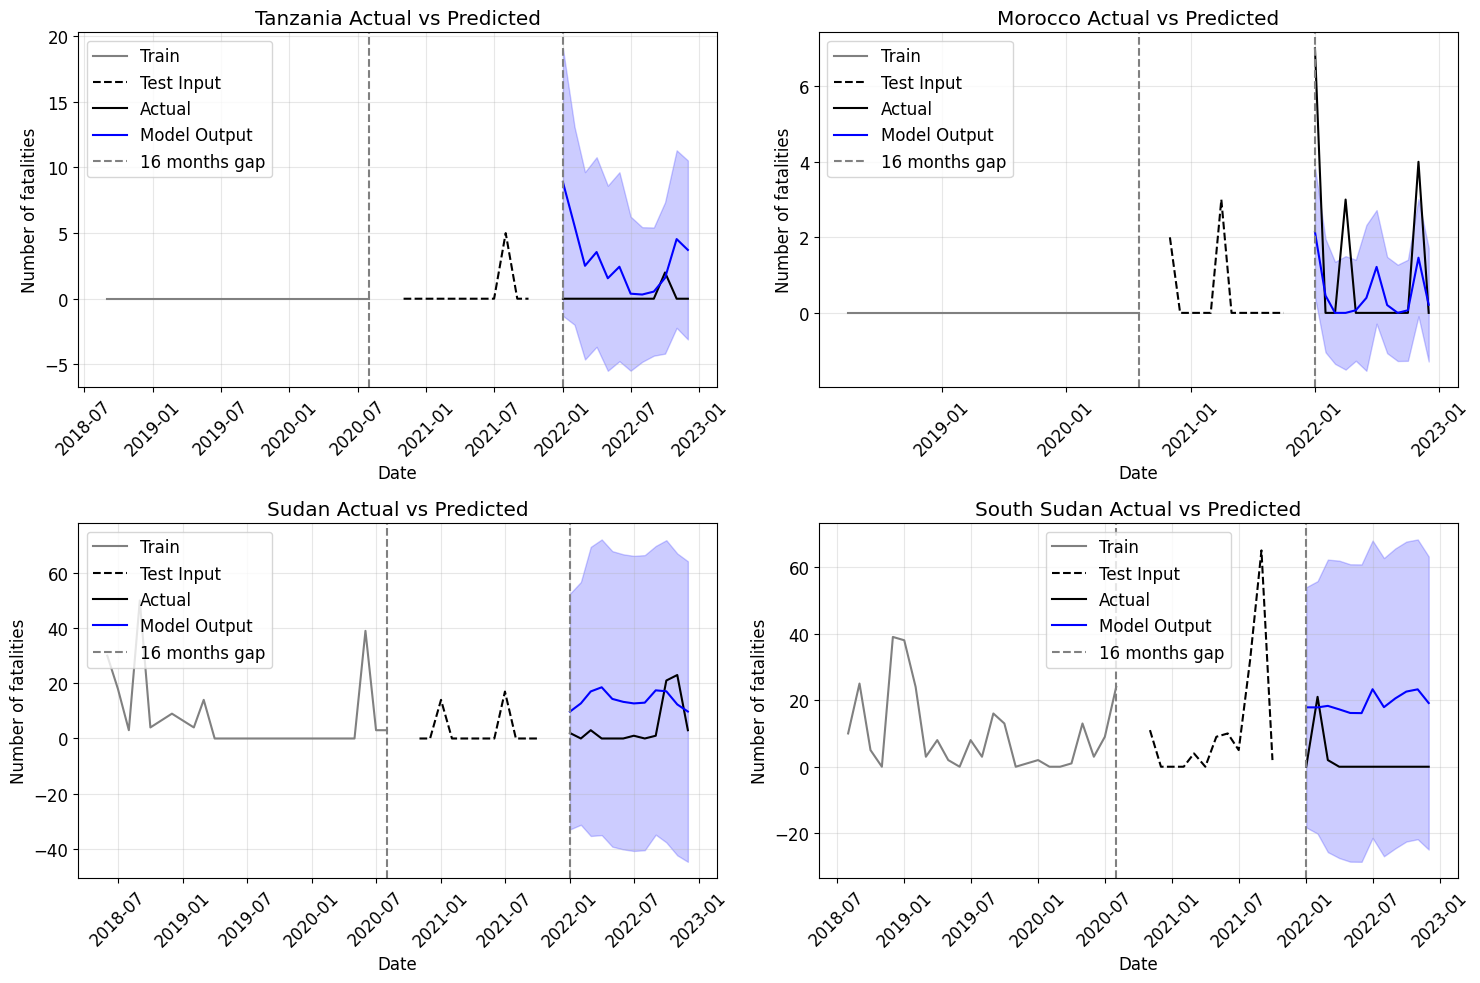

<Figure size 1500x1000 with 0 Axes>

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

# Load data
country_list = pd.read_csv('../data/country_list.csv')
country_ids = test_df['country_id'].unique().tolist()

# Settings
num_plots_per_figure = 4

plt.figure(figsize=(15, 10))  # New figure
plots_added = 0
# Continue looping until all countries have been considered
max_date_train = pd.to_datetime(train_df['date'].max())
min_date_test = pd.to_datetime(test_df['date'].min())
# 1 year buffer because of validation set
expected_min_date_test = max_date_train + relativedelta(years=0,
                                                        months=prediction_window + 3)  # 15 is window size + 1 is from Sep to Oct
print(f"Max date in training set: {max_date_train}")
print(f"Min date in test set: {min_date_test}")
print(f"Expected min date in test set: {expected_min_date_test}")
# assert the different is exactly 15 months
assert min_date_test == expected_min_date_test

for index, country_id in enumerate(country_ids):

    this_country_test = test_df[test_df['country_id'] == country_id]
    this_country_train = train_df[train_df['country_id'] == country_id]
    this_country_train = this_country_train.tail(24)

    country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

    # Check if country should be skipped due to no data
    if this_country_test[target].sum() == 0:
        print(f"Skipping {country_name} as all actual are 0")
        continue

    # Prepare the subplot for non-skipped countries
    plt.subplot(2, 2, plots_added + 1)

    # Plotting data
    plt.plot(this_country_train['date'], this_country_train["ged_sb"], label=f'Train', color='gray',
             linestyle='-', marker='')

    plt.plot(this_country_test['date'].apply(lambda x: x - relativedelta(months=14)), this_country_test["ged_sb"],
             label=f'Test Input', color='black', linestyle='--', marker='')
    plt.plot(this_country_test['date'], this_country_test[target], label=f'Actual', color='black',
             linestyle='-', marker='')
    # plt.plot(this_country_test['date'], this_country_test['predictions'], label=f'{country_name} Predicted XGB',
    #          color='red', linestyle='-', marker='')
    plt.plot(this_country_test['date'], this_country_test['ngb_predictions'], label=f'Model Output',
             color='blue', linestyle='-', marker='')
    # plot std
    if PLOT_STD:
        month_max_pred = this_country_test['ngb_predictions']
        if not normal_enabled:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions_min'],
                             this_country_test['ngb_predictions_max'],
                             color='blue',
                             alpha=0.2)
        else:
            plt.fill_between(this_country_test['date'],
                             this_country_test['ngb_predictions'] - this_country_test['ngb_predictions_std'],
                             this_country_test['ngb_predictions'] + this_country_test['ngb_predictions_std'],
                             color='blue',
                             alpha=0.2)

    # Benchmark plotting
    if prediction_year != 2022:
        benchmark_country = benchmark_model[benchmark_model['country_id'] == country_id]
        plt.plot(benchmark_country['date'], benchmark_country['outcome'], label=f'Benchmark',
                 color='green', linestyle='--', marker='')
        plt.fill_between(benchmark_country['date'], benchmark_country['outcome'] - benchmark_country['outcome_std'],
                         benchmark_country['outcome'] + benchmark_country['outcome_std'], color='green', alpha=0.15)

    # Adding title and labels
    plt.title(f"{country_name} Actual vs Predicted")
    plt.xlabel("Date")
    # turn dates 90 degrees
    plt.xticks(rotation=45)
    # make ticks more readable
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
    # add vertical lines for the training and testing split
    plt.axvline(x=min_date_test, color='gray', linestyle='--', label='16 months gap')
    plt.axvline(x=max_date_train, color='gray', linestyle='--')
    plt.ylabel("Number of fatalities")
    plt.legend()
    # add light grid
    plt.grid(alpha=0.3)

    # Increment counters
    plots_added += 1

    if plots_added % num_plots_per_figure == 0 or index == len(country_ids) - 1:
        # Adjust layout and display the figure
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(15, 10))  # New figure
        plots_added = 0

plt.show()


In [71]:
import plotly.graph_objects as go

PLOT_ONE_FIGURE = False
if PLOT_ONE_FIGURE:
    # Assuming country_list, test_df, and train_df are already loaded
    # Creating one figure for all countries
    fig = go.Figure()

    country_ids = test_df['country_id'].unique().tolist()

    for country_id in country_ids:
        # Data for this country
        this_country_test = test_df[test_df['country_id'] == country_id]
        this_country_train = train_df[train_df['country_id'] == country_id]
        country_name = country_list[country_list['country_id'] == country_id]['name'].values[0]

        # Add traces for Train Actual
        fig.add_trace(
            go.Scatter(x=this_country_train['date'], y=this_country_train[target], name=f'{country_name} Train',
                       mode='lines', line=dict(color='gray', width=1))
        )

        # Add traces for Test Actual
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test[target], name=f'{country_name} Test Actual',
                       mode='lines', line=dict(color='blue', width=1))
        )

        # Add traces for Predicted
        fig.add_trace(
            go.Scatter(x=this_country_test['date'], y=this_country_test['predictions'],
                       name=f'{country_name} Predicted', mode='lines', line=dict(color='red', dash='dot', width=1))
        )

    # Add figure title and adjust layout
    fig.update_layout(
        title_text="Actual vs Predicted Values Across Countries",
        xaxis_title="Date",
        yaxis_title="GED_SB Value",
        legend_title="Legend",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    # Show plot
    fig.show()

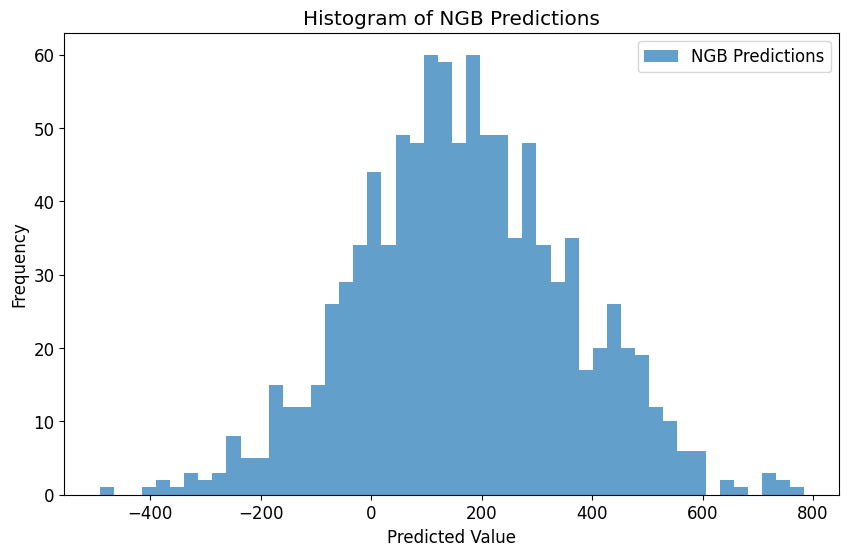

In [72]:
ngb_predictions_sampled = ngb_predictions_dist.sample(1000).T.astype(int)
# 
# concat to test_df
# test_df = pd.concat([test_df, ngb_predictions_sampled], axis=1)


# negative_mask = ngb_predictions_sampled < 0
# # print how many negative values are there
# print(negative_mask.sum().sum()) # 917442
# # print total number of values
# print(negative_mask.size) # 2028000
# # print percentage of negative values
# print(negative_mask.sum().sum() / negative_mask.size) #0.452387573964497
# # sample once more and fill in the previous negative values with values from new distribution
# ngb_predictions_sampled[negative_mask] = ngb_predictions_dist.sample(1000).T[negative_mask]
# # print again how many negative values are there
# negative_mask =  ngb_predictions_sampled < 0
# print(negative_mask.sum().sum())  # 423012

# # set 0 if negative
# # ngb_predictions_sampled = ngb_predictions_sampled.clip(min=0)
# ngb_predictions_sampled = ngb_predictions_sampled
# 
# 
# # plot histogram of the sampled predictions using plt
plt.figure(figsize=(10, 6))
plt.hist(ngb_predictions_sampled[325], bins=50, alpha=0.7, label='NGB Predictions')  # MAX
# plot a dot for the actual value
# plt.scatter([actuals_model['ged_sb'].max()], [0], color='red', label='Actual Value')
# plt.hist(ngb_predictions_sampled[20], bins=50, alpha=0.7, label='NGB Predictions') # MIN
plt.title('Histogram of NGB Predictions')
plt.xlabel('Predicted Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# ngb_predictions_sampled[0]

In [73]:

# len(set(benchmark_model['country_id'].unique()) - set(test_df['country_id'].unique()))
print(benchmark_model['month_id'].unique())
print(test_df['month_id'].unique())
print("Adjusted month_id for predictions:", test_df['month_id'].unique() + 15)
set(benchmark_model['month_id'].unique()) == set(test_df['month_id'].unique() + 15)

[493 494 495 496 497 498 499 500 501 502 503 504]
[491 492 493 494 495 496 497 498 499 500 501 502]
Adjusted month_id for predictions: [506 507 508 509 510 511 512 513 514 515 516 517]


False

In [74]:
test_df.index

RangeIndex(start=0, stop=2028, step=1)

In [75]:
# temp = test_df
# temp.reset_index(inplace=False, drop=False)
# 
# # get row with the highest number of deaths
# temp[temp['predictions'] == temp['predictions'].max()]
# print(temp[temp['predictions'] == temp['predictions'].min()])

# NOTE !!!!
# test_df.reset_index(inplace=True, drop=True)
test_df_edge = test_df.shape[1]
test_df_new = pd.concat([test_df, pd.DataFrame(ngb_predictions_sampled)], axis=1)
ngb_predictions_sampled[12] == test_df_new.iloc[12, test_df_edge:]

# get the row with the highest number of deaths
# actuals_model


# add to test_df_new the actuals based on month_id and country_id
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.merge(actuals_model[['month_id', 'country_id', 'actuals']], on=['month_id', 'country_id'])

# drop level 0 and index columns
# test_df.drop(columns=['level_0', 'index'], inplace=True, errors='ignore')
# test_df_new

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: 12, Length: 1000, dtype: bool

In [76]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# actuals_model.set_index(['month_id', 'country_id'], inplace=True)
# test_df_new.set_index(['month_id', 'country_id'], inplace=True)

In [77]:
# actuals_model.rename(columns={'ged_sb': 'actuals'}, inplace=True)
# test_df_new.reset_index(inplace=True, drop=True)
# actuals_model.reset_index(inplace=True, drop=True)


# drop actuals if it exists
# test_df_new = test_df_new.drop(columns='actuals', errors='ignore')

# join actuals to test_df_new
# test_df_new = test_df_new.join(actuals_model['actuals'], how='left')
# test_df_new.reset_index(inplace=True)
# actuals_model.reset_index(inplace=True)
# test_df_new
# actuals_model['actuals']
# test_df_new.head(10)
# test_df_new.head(1000)

In [78]:
print(list(test_df_new.columns).index(target))
print(len(test_df_new.columns))
print(test_df_edge)
test_df_new.head(100)[['month_id', 'country_id', target, 'ngb_predictions']]

149
1332
332


month_id country_id  ged_sb_14  ngb_predictions
0        491          1        0.0         0.002765
1        491          2        0.0         0.003560
2        491          3        0.0         0.000000
3        491          4        0.0         0.000000
4        491          7        0.0         0.000000
..       ...        ...        ...              ...
95       491        121        0.0         0.185128
96       491        122        0.0         0.046923
97       491        123        0.0         0.000000
98       491        124     1531.0       354.253911
99       491        125        3.0         1.219318

[100 rows x 4 columns]

In [79]:
# test_df_edge = test_df_new.shape[1]
# test_df_new = pd.concat([test_df_new, pd.DataFrame(ngb_predictions_sampled)], axis=1)
# ngb_predictions_sampled[1] == test_df_new.iloc[1, test_df_edge:]

In [80]:
test_df_new[(test_df_new['country_name'] == 'Pakistan') & (test_df_new['date'] == f'{prediction_year}-07')]

month_id  ged_sb  ged_ns  ged_os  acled_sb  acled_sb_count  acled_os  \
1124       497    44.0     0.0     0.0      33.0            17.0      23.0   

      ged_sb_tsum_24  wdi_sp_pop_totl  ged_sb_tlag_1  ...  990  991  992  993  \
1124           686.0      227196741.0           13.0  ...  -69 -108  -40  -51   

      994  995  996  997  998  999  
1124   24  -18   60  108   13   38  

[1 rows x 1332 columns]

In [81]:
# get id of test_df_new[target].max()
indices_to_plot = [test_df_new[target].idxmax(), test_df_new[target].idxmin()]

# add Pakistan 2020-07
indices_to_plot.append(
    test_df_new[(test_df_new['country_name'] == 'Pakistan') & (test_df_new['date'] == f'{prediction_year}-07')].index[
        0])
indices_to_plot.extend(highest_error_indices)

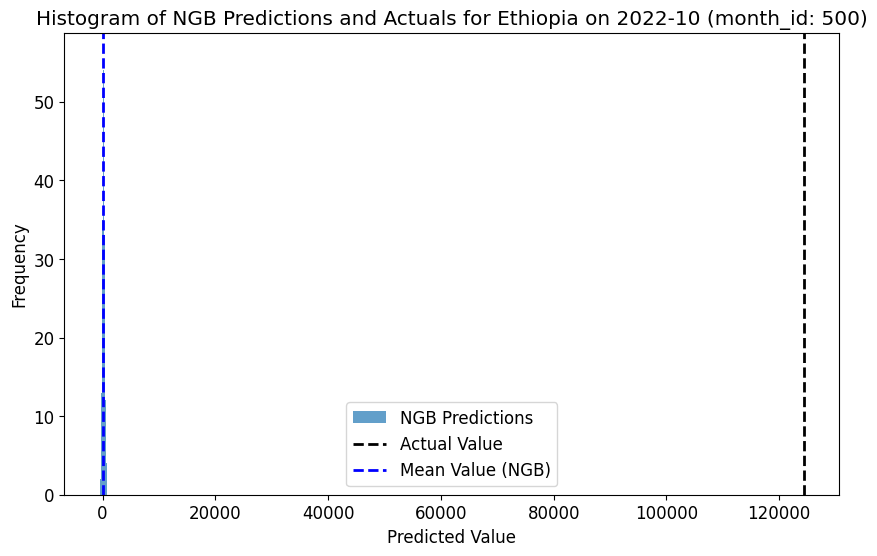

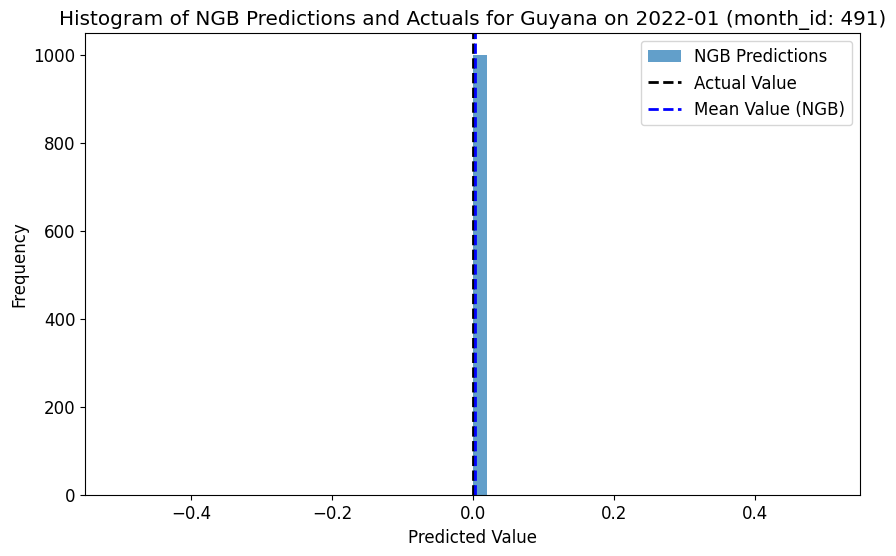

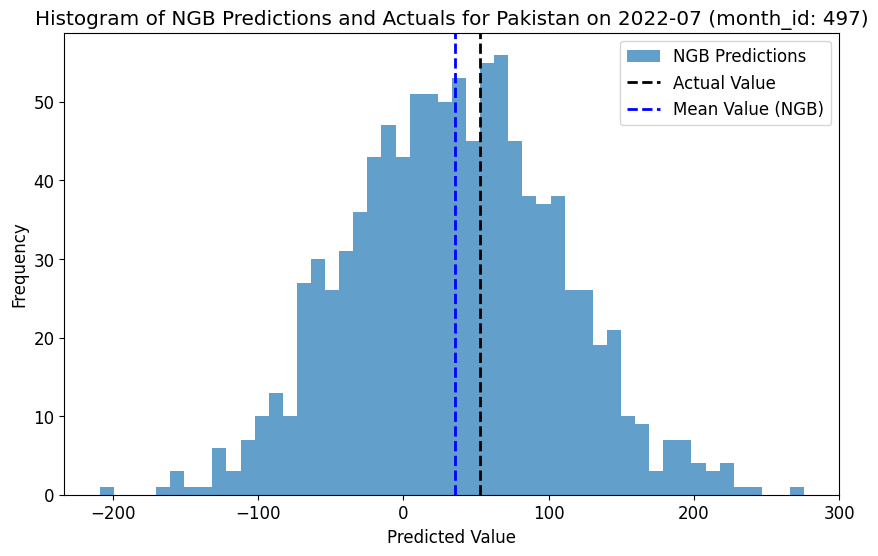

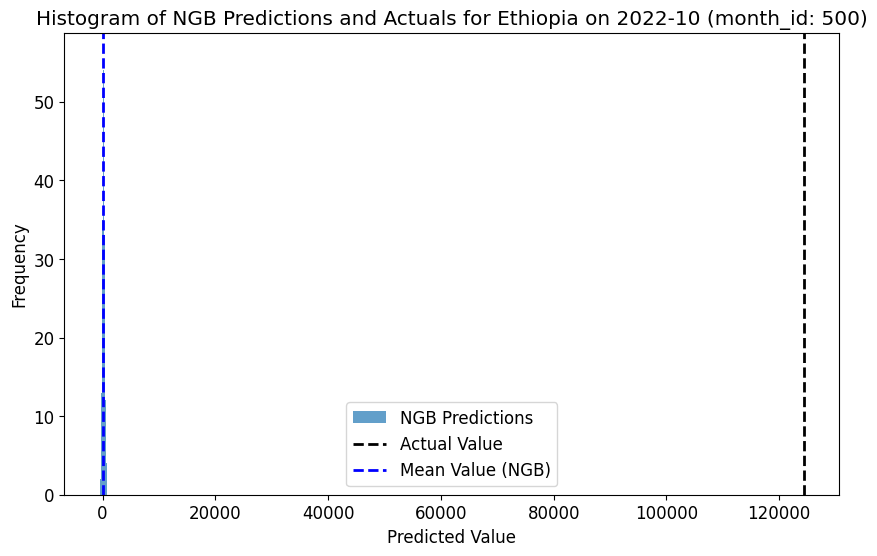

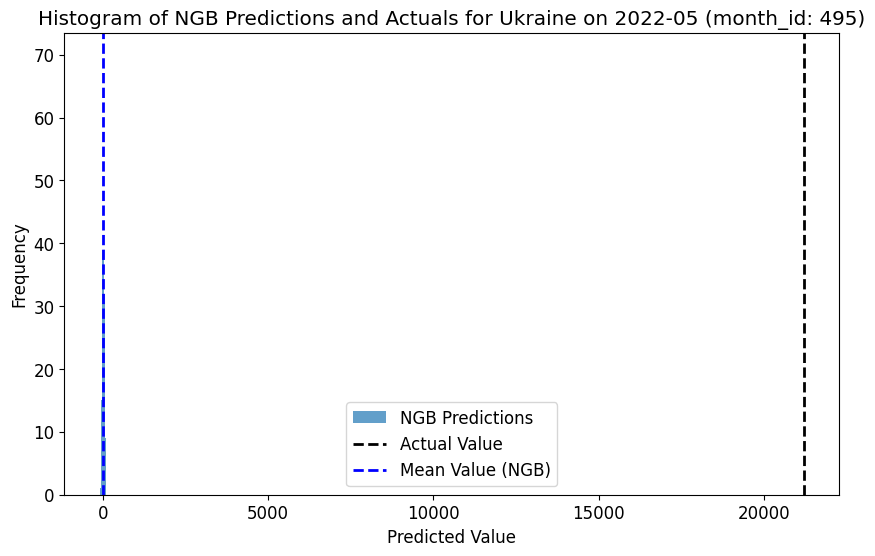

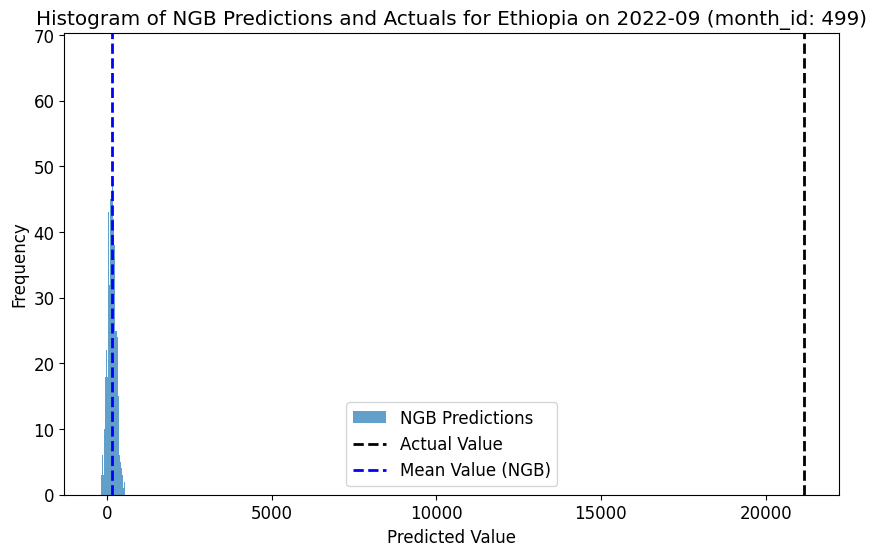

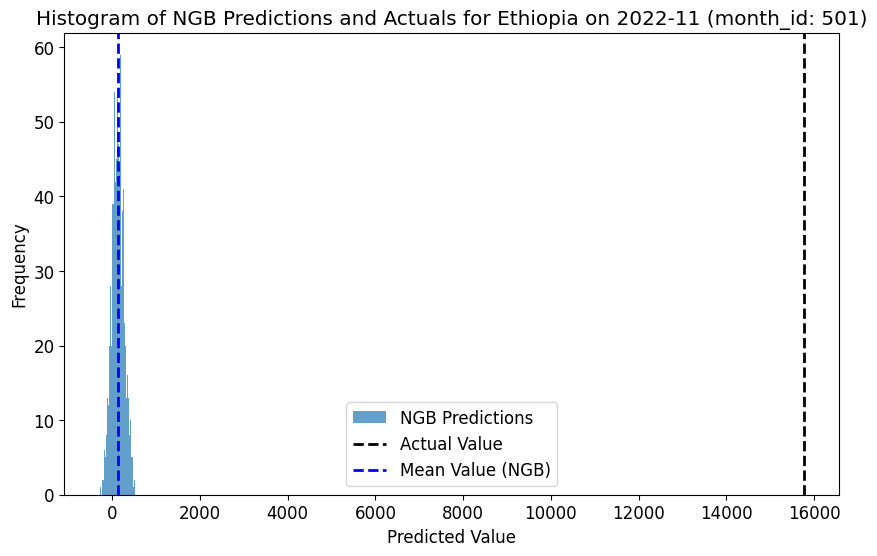

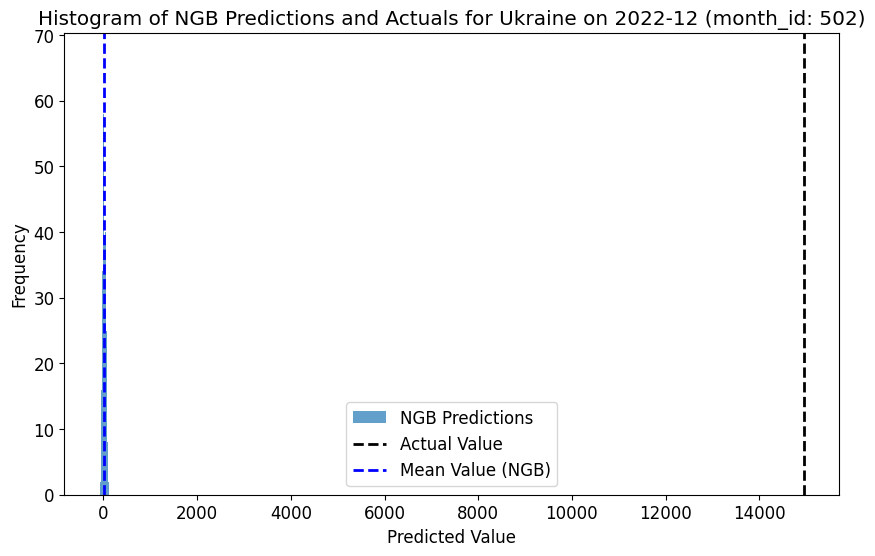

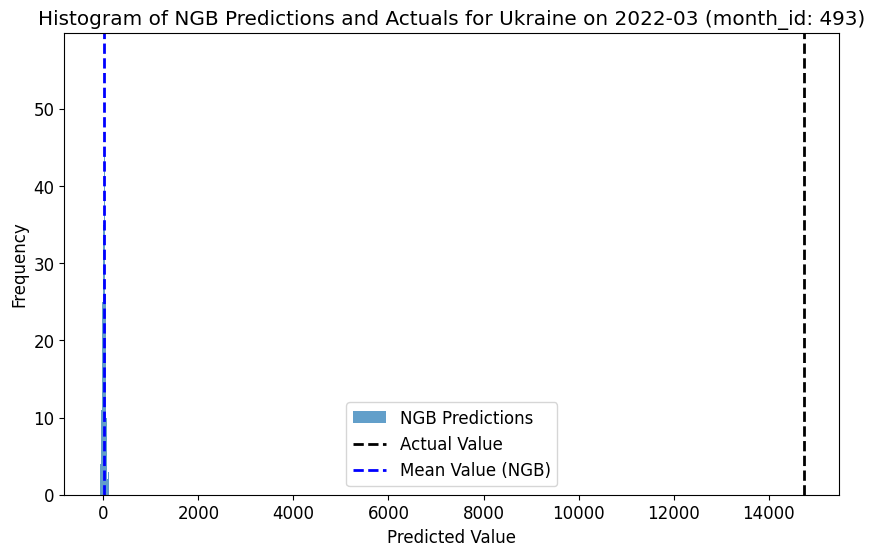

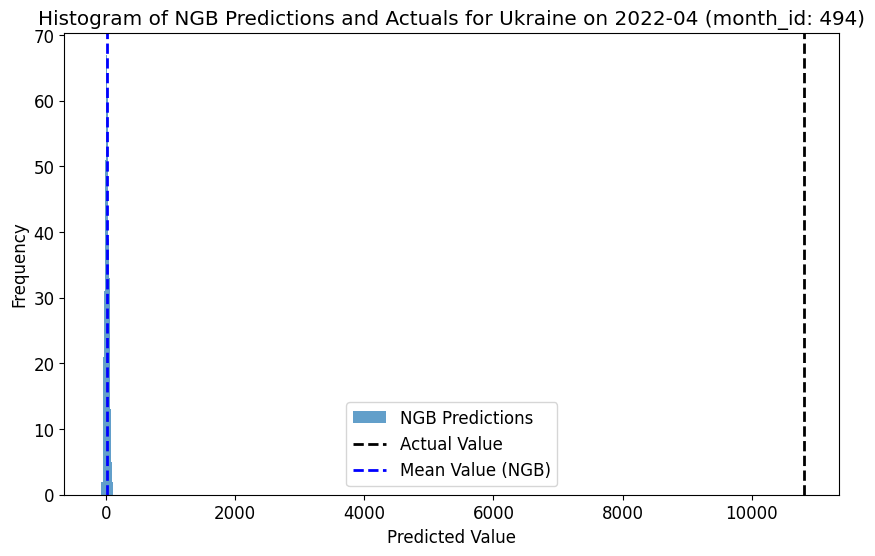

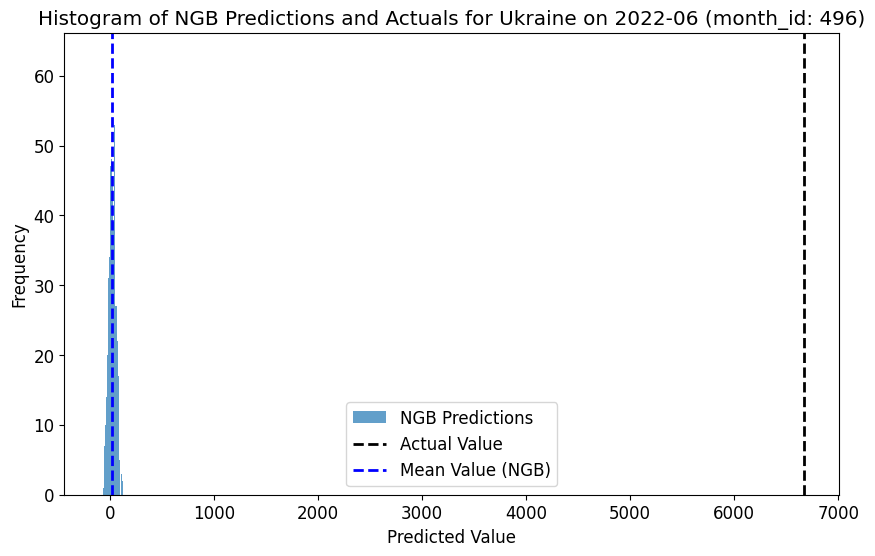

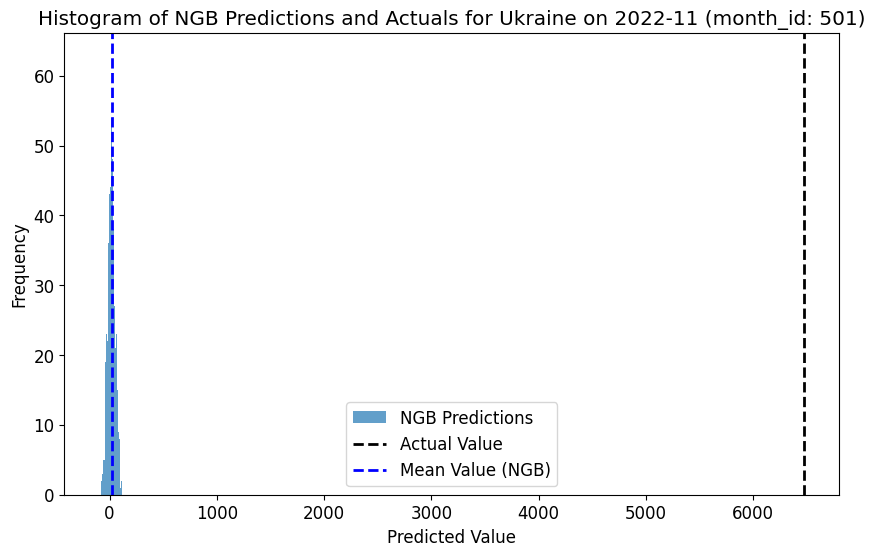

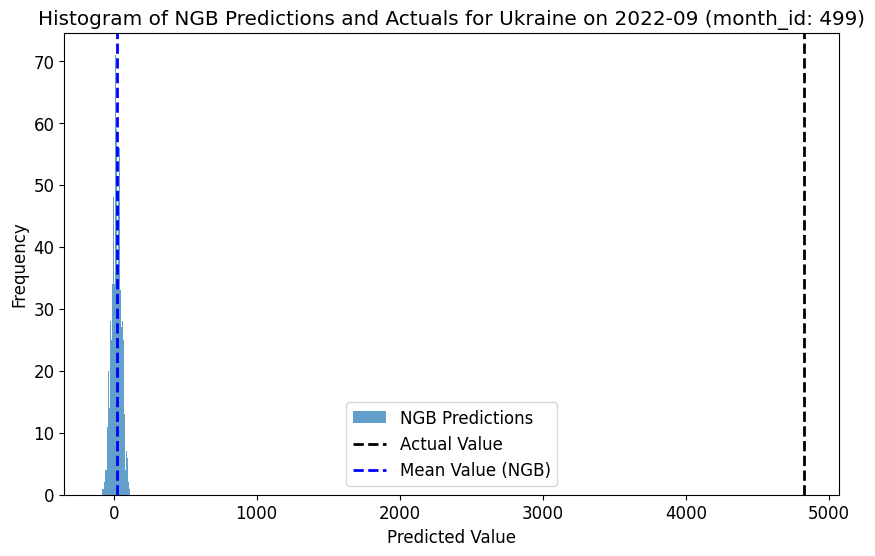

In [82]:

for index_id in indices_to_plot:
    rowww = test_df_new.iloc[[index_id]]

    actual_pred = rowww[target].values[0]

    hist_data_temp = rowww.iloc[:, test_df_edge:].values[0]
    # keep only samples that are in 95% confidence interval

    # Plot histogram of the sampled predictions using plt
    plt.figure(figsize=(10, 6))
    plt.hist(hist_data_temp, bins=50, alpha=0.7, label='NGB Predictions')

    # Plot vertical lines for actual value, mean value, and other relevant predictions
    plt.axvline(x=actual_pred, color='black', linestyle='dashed', linewidth=2, label='Actual Value')
    plt.axvline(x=rowww['ngb_predictions'].values[0], color='blue', linestyle='dashed', linewidth=2,
                label='Mean Value (NGB)')
    # plt.axvline(x=rowww['predictions'].values[0], color='red', linestyle='dashed', linewidth=2, label='XGBoost Prediction')
    formatted_date = rowww['date'].dt.strftime('%Y-%m').values[0]
    country_name = rowww['country_name'].values[0]
    plt.title(
        f'Histogram of NGB Predictions and Actuals for {country_name} on {formatted_date} (month_id: {int(rowww["month_id"].values[0])})')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


In [83]:
test_df_new[test_df_new[target] == test_df_new[target].max()]['ngb_predictions']

1564    163.347922
Name: ngb_predictions, dtype: float64

In [84]:
rowww[['month_id', 'country_id', target, 'ngb_predictions']]

month_id country_id  ged_sb_14  ngb_predictions
1443       499        117     4828.0        20.070692

In [85]:
dist_name = 'normal' if normal_enabled else 'poisson'
prediction_year

2022

In [86]:
if SAVE_PREDICTIONS:

    # Save predictions
    import numpy as np
    import os

    # TODO: for countries that are in actuals but not in the predictions, add them to the predictions with 0
    #  test_df['country_id'].unique()
    #  actuals_model['country_id'].unique()
    missing_countries = set(benchmark_model['country_id'].unique()) - set(test_df_new['country_id'].unique())

    # save predictions to a csv file
    # for each month for each country create 20 draws of the prediction named outcome
    # the structure of the file should be month_id, country_id, draw, outcome
    new_predictions_list = []
    all_countries = set(test_df_new['country_id'].unique()).union(missing_countries)
    for month_id in test_df_new['month_id'].unique():
        for country_id in all_countries:
            this_country_month = test_df_new[
                (test_df_new['month_id'] == month_id) & (test_df_new['country_id'] == country_id)]

            if country_id in missing_countries:
                outcomes = np.zeros(1000)
            else:
                outcomes = this_country_month.iloc[:, test_df_edge:].values[0]

                # remove all values smaller than 0
                non_negatives = outcomes[outcomes >= 0]
                negative_counts = np.sum(outcomes < 0)

                if negative_counts > 0:
                    # Sample from the non-negative distribution to replace negative values
                    # We assume the distribution of non-negatives is suitable for sampling
                    sampled_values = np.random.choice(non_negatives, size=negative_counts)
                    outcomes[outcomes < 0] = sampled_values

                assert all(outcomes >= 0), "There are still negative values in the outcomes"

            new_predictions_list.extend([{
                'month_id': month_id + prediction_window,  # adjust for prediction window
                'country_id': country_id,
                'draw': draw,
                'outcome': outcome
            } for draw, outcome in enumerate(outcomes, start=0)])

    # set month_id, country_id, draw as int and outcome as float
    new_predictions = pd.DataFrame(new_predictions_list)
    new_predictions['month_id'] = new_predictions['month_id'].astype(int)
    new_predictions['country_id'] = new_predictions['country_id'].astype(int)
    new_predictions['draw'] = new_predictions['draw'].astype(int)
    new_predictions['outcome'] = new_predictions['outcome'].astype(int)
    # set index to month_id, country_id, draw
    new_predictions.set_index(['month_id', 'country_id', 'draw'], inplace=True)
    # create folder if it does not exist recursively
    folder_to_str = f"ng_boost_cm_v{cm_features_version}_pw_{prediction_window}_{dist_name}_d_{DROP_0_ROWS_PERCENT}_n_{n_estimators}_s_{score.__name__.lower()}_c_{str(INCLUDE_COUNTRY_ID)[0]}_m_{str(INCLUDE_MONTH_ID)[0]}_bsd_{bs_max_depth}_mbf_{minibatch_frac}_dli_{35 if DROP_35_LEAST_IMPORTANT else 0}"
    folder = f"../submission/{folder_to_str}/cm/window=Y{prediction_year}"
    os.makedirs(folder, exist_ok=True)
    new_predictions.to_parquet(
        folder + f'/{folder_to_str}_Y{prediction_year}.parquet')
    print(f"Predictions saved")
    print(f'Saved to {folder}')
else:
    print("Predictions not saved")

Predictions saved
Saved to submission/ng_boost_cm_v2.4_pw_14_normal_d_20_n_300_s_crpscore_c_T_m_T_bsd_5_mbf_0.5_dli_0/cm/window=Y2022


In [87]:
print(train_df.shape)
print(test_df.shape)

(50408, 330)
(2028, 332)


In [88]:
new_predictions[new_predictions['outcome'] < 0]

Empty DataFrame
Columns: [outcome]
Index: []

In [89]:
import os

os.makedirs(f'../figures/{folder_to_str}', exist_ok=True)

# hist_color = 'blue'
mean_line_color = 'blue'
actual_value_color = 'black'

# set font size bigger
plt.rcParams.update({'font.size': 18})


# Define a function to plot histograms for a given instance
def plot_histograms(instance_to_plot):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    raw_predictions = test_df_new.iloc[instance_to_plot, test_df_edge:]
    processed_predictions = new_predictions.loc[(
        test_df_new.iloc[instance_to_plot]['month_id'] + prediction_window,
        test_df_new.iloc[instance_to_plot]['country_id']
    )][['outcome']]
    metadata = test_df_new.iloc[instance_to_plot][['month_id', 'country_id', 'country_name', 'date', target]]
    formatted_date = metadata['date'].strftime('%Y-%m')

    # Set title for the row of histograms
    # fig.suptitle(f'{metadata["country_name"]} on {formatted_date} (month_id: {int(metadata["month_id"])})', fontsize=16)

    # Raw predictions histogram
    raw_predictions = raw_predictions.apply(pd.to_numeric, errors='coerce')
    raw_prediction_crps = pscore(raw_predictions, metadata[target]).compute()[0]
    axs[0].hist(raw_predictions, bins=30, alpha=0.7)
    axs[0].axvline(raw_predictions.mean(), color=mean_line_color, linestyle='dashed', linewidth=2)
    axs[0].axvline(metadata[target], color=actual_value_color, linewidth=2)
    axs[0].set_title(
        f'Histogram of Raw Predictions\nCRPS: {raw_prediction_crps:.2f}')
    axs[0].set_xlabel('Predicted Values')
    axs[0].set_ylabel('Frequency')
    axs[0].legend(
        [f'Mean Value {raw_predictions.mean():.2f}', f'Actual Value {metadata[target]}'])

    # Processed predictions histogram
    processed_predictions = processed_predictions.apply(pd.to_numeric, errors='coerce')
    processed_prediction_crps = pscore(processed_predictions['outcome'], metadata[target]).compute()[0]
    axs[1].hist(processed_predictions, bins=30, alpha=0.7)
    axs[1].axvline(processed_predictions.mean().iloc[0], color=mean_line_color, linestyle='dashed', linewidth=2)
    axs[1].axvline(metadata[target], color=actual_value_color)
    axs[1].set_title(
        f'Histogram of Resampled Predictions\nCRPS: {processed_prediction_crps:.2f}')
    axs[1].set_xlabel('Predicted Values')
    axs[1].legend([f'Mean Value {processed_predictions.mean().iloc[0]:.2f}', f'Actual Value {metadata[target]}'])

    # Raw predictions histogram with non-negative values
    raw_predictions_non_neg = raw_predictions.clip(lower=0)
    raw_prediction_non_neg_crps = pscore(raw_predictions_non_neg, metadata[target]).compute()[0]
    axs[2].hist(raw_predictions_non_neg, bins=30, alpha=0.7)
    axs[2].axvline(raw_predictions_non_neg.mean(), color=mean_line_color, linestyle='dashed', linewidth=2)
    axs[2].axvline(metadata[target], color=actual_value_color)
    axs[2].set_title(
        f'Histogram of Clipped Predictions\nCRPS: {raw_prediction_non_neg_crps:.2f}')
    axs[2].set_xlabel('Predicted Values')
    axs[2].legend([f'Mean Value {raw_predictions_non_neg.mean():.2f}', f'Actual Value {metadata[target]}'])

    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(f'../figures/{folder_to_str}/histograms_{metadata["country_name"]}_{formatted_date}.png')
    else:
        plt.show()


# Plot histograms for the first set of indices
plot_histograms(indices_to_plot[8])
# Plot histograms for the second set of indices
plot_histograms(indices_to_plot[2])

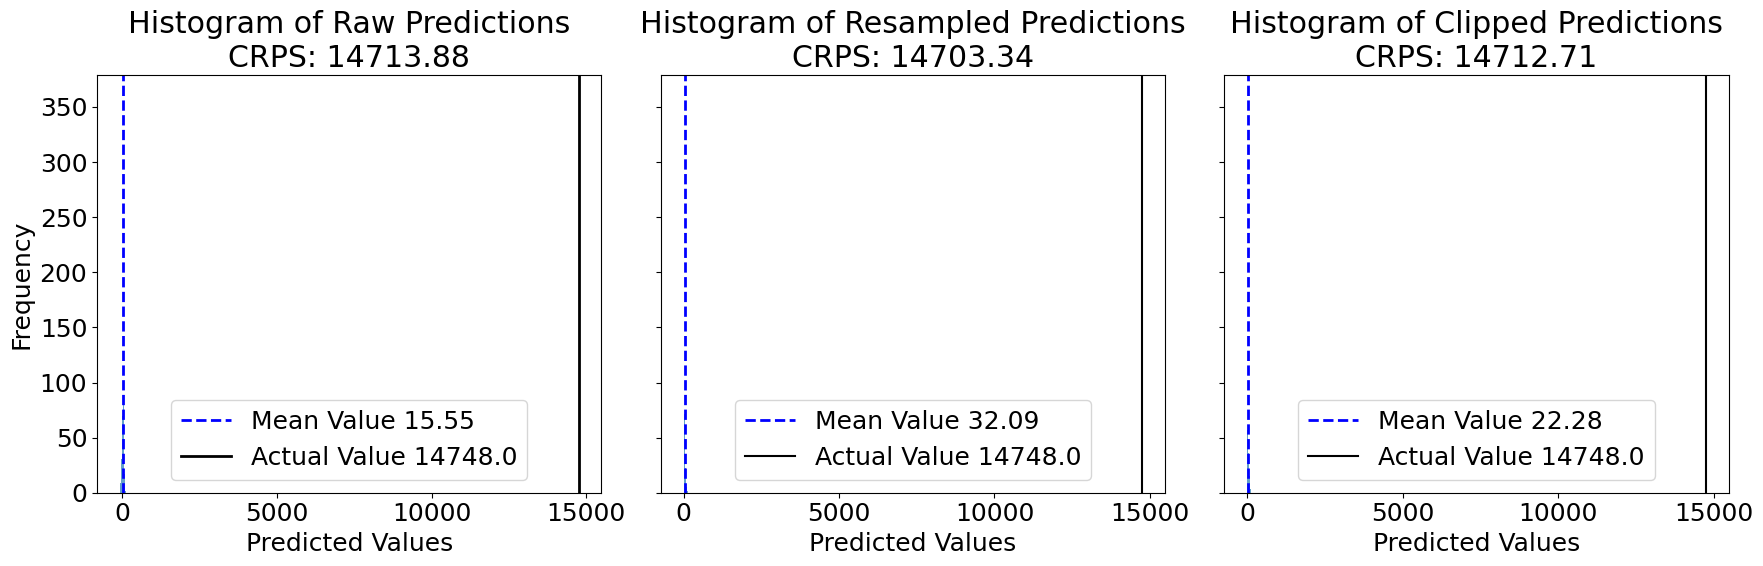

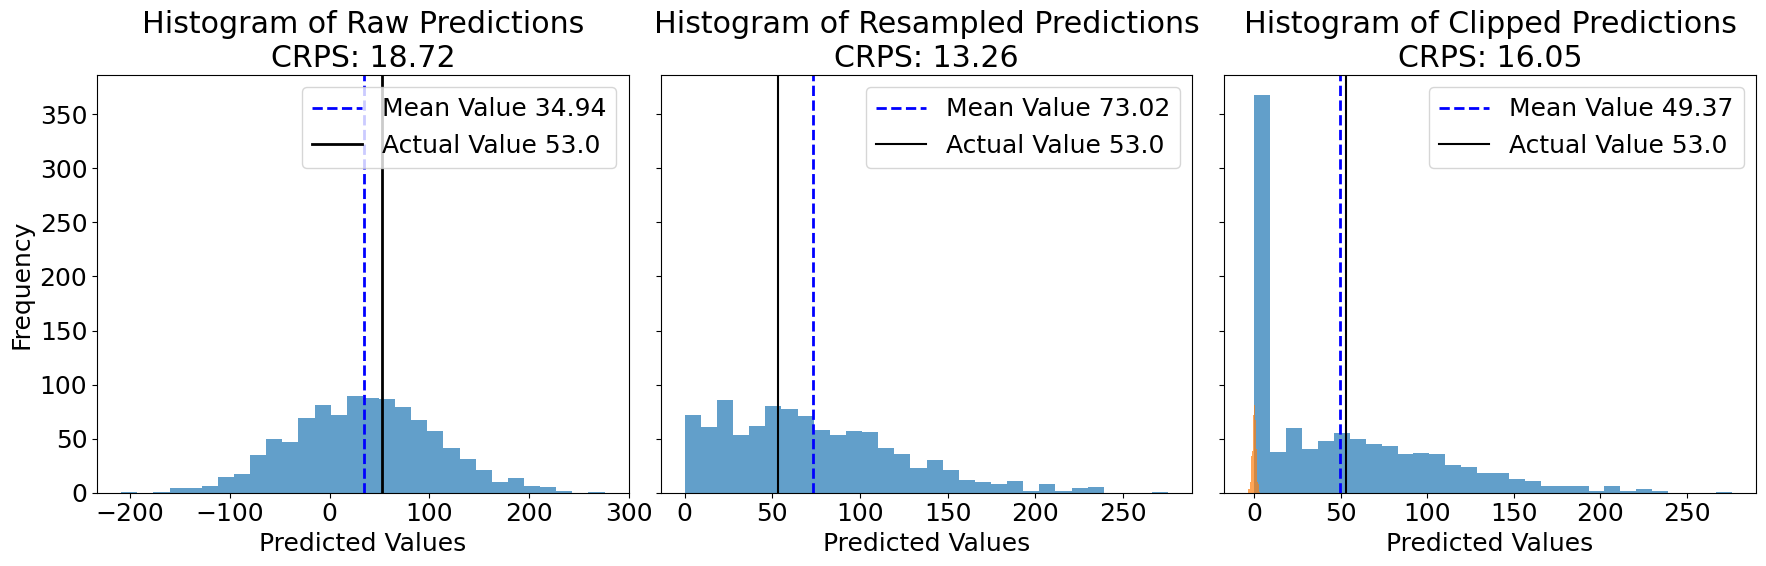

In [90]:
# plot histogram with random data
import numpy as np
import matplotlib.pyplot as plt

random_data = np.random.normal(0, 1, 1000)
plt.hist(random_data, bins=30, alpha=0.7)
plt.show()
